## Loading the model

In [225]:
import torch

noise_amplitude = 0.001 #*0
dim_recurrent = 100
simple_input = False
simple_output = True
reg_norm = 0.0000#/10
reg_lam = 2
noise = 0.1
hold_zero=False
init_random = "32_f_1"
parameter_updates = 0 # 0 = best network overall
redo_preanalysis = True # None = redo only if necessary

ORI_RES = 3

delay0_set = torch.arange(10, 51)
delay1_set = torch.arange(10, 51)
delay2_set = torch.arange(10, 51)
hold_orientation_for, hold_cue_for = 50, 50
#delay0, delay1, delay2 = delay0_set[-1].item(), delay1_set[-1].item(), delay2_set[-1].item()
#delay0, delay1, delay2 = torch.median(delay0_set).item(), torch.median(delay1_set).item(), torch.median(delay2_set).item()
delay0, delay1, delay2 = 50, 50, 50

hold_orientation_for = 10
hold_cue_for = 100
delay0_set = torch.tensor([0]) 
delay0_set = torch.arange(30, 50)
delay1_set = torch.arange(30, 50)
delay2_set = torch.arange(30, 50)
delay0, delay1, delay2 = 40, 40, 40

%run -i 'playground_prepare-flag.py'

t1, t1d = -1+delay0 if delay0>0 else 0, "before O1 presented"
t1_5, t1_5d = -1+delay0+hold_orientation_for//2, "amid 01 presentation"
t2, t2d = -1+delay0+hold_orientation_for, "after O1 presented"
t3, t3d = -1+delay0+hold_orientation_for+delay1, "before O2 presented"
t3_5, t3_5d = -1+delay0+hold_orientation_for+delay1+hold_orientation_for//2, "amid O2 presentation"
t4, t4d = -1+delay0+hold_orientation_for+delay1+hold_orientation_for, "after O2 presented"
t5, t5d = -1+delay0+hold_orientation_for+delay1+hold_orientation_for+delay2, "before go cue"
t6, t6d = -1+total_time, "end of task"
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
def calc_pref(units_i, timestep=t6, to=1, data_all=None):
    if data_all is None:
        data_all = megabatch_tuningdata
    w = torch.sum(data_all[timestep][units_i], dim=3-to).detach().numpy()
    a = np.angle(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1)/np.sum(np.abs(w), axis=1)) * 180 / np.pi / 2
    a[a<0] = a[a<0]+180
    return torch.round(torch.tensor(a))

perf = network_performance()
print(f"MSE: O1={perf[0]:.3f}, O2={perf[1]:.3f}")
print(f"MSA: O1={perf[2]:.2f}, O2={perf[3]:.2f}")

timestep = t6
sor = []
for i in range(dim_recurrent):
    data_in = megabatch_tuningdata[timestep][i]
    var1 = torch.var(torch.sum(data_in, axis=1))+0.01
    var2 = torch.var(torch.sum(data_in, axis=0))+0.01
    var = (var1/var2).item()
    #if var>10:
    sor.append({"id": i, "var": var, "pref": (1 if var1>var2 else 2)})
   # print(f"UNIT {i}: {var1/var2+var2/var1}")
sor = sorted(sor, reverse=True, key=lambda x: x["var"])
sor_i = [x["id"] for x in sor]
        
# s['var'] is (variance in O1 + 0.01)/(variance in O2 + 0.01)
# thus, for highly tuned units, s['var']+1/s['var'] is big. 
# for DT units, it's small. DT_threshold is an arbitrary threshold here.
DT_threshold = 10 # 0 for 50-50 R1/R2 with no DT units
DT_i = torch.tensor([i for i, s in enumerate(sor) if s['var']+1/s['var']<DT_threshold], dtype=int)
R1_ends_at_i = min(DT_i) if len(DT_i) > 0 else dim_recurrent//2
R2_starts_from_i = max(DT_i)+1 if len(DT_i) > 0 else dim_recurrent//2
R1_num = R1_ends_at_i
DT_num = len(DT_i)
R2_num = dim_recurrent - R1_num - DT_num
DT_i = torch.tensor([s["id"] for i, s in enumerate(sor) if s['var']+1/s['var']<DT_threshold], dtype=int)
print(f"{R1_num} R1 - {DT_num} DT - {R2_num} R2")
R1_i = megabatch_tuningindices[t6][:R1_ends_at_i]
R2_i = megabatch_tuningindices[t6][R2_starts_from_i:]
R1_indices = megabatch_tuningindices[:, :R1_ends_at_i]
DT_indices = megabatch_tuningindices[:, R1_ends_at_i:R2_starts_from_i]
R2_indices = megabatch_tuningindices[:, R2_starts_from_i:]
R1_pref, R2_pref = calc_pref(R1_i, timestep, to=1), calc_pref(R2_i, timestep, to=2)
R1_i = R1_i.clone()[torch.argsort(R1_pref)]
R1_pref = R1_pref.clone()[torch.argsort(R1_pref)]
R2_i = R2_i.clone()[torch.argsort(R2_pref)]
R2_pref = R2_pref.clone()[torch.argsort(R2_pref)]

Carrying out pre-analysis...
Generating megabatch...
Running the model...
Calculating data_all...
Calculating tuning indices...
Saving...
Done...
MSE: O1=0.005, O2=0.003
MSA: O1=1.84, O2=1.40
29 R1 - 46 DT - 25 R2


(0.0, 0.5)

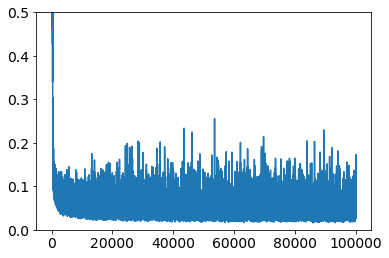

In [226]:
index = model_filename.split(".")[0]
with open(f"{directory}/i0.json", 'r', encoding='utf-8') as f:
    j = json.load(f)
plt.plot(j['error_store']) 
plt.ylim(0, 0.5)

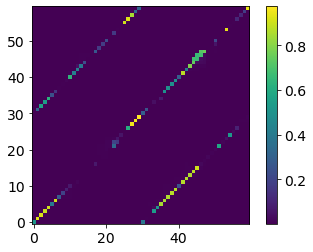

In [227]:
error = torch.sum((megabatch_output[0][megabatch_mask == 1] - megabatch_target[megabatch_mask == 1]) ** 2, dim=0) / torch.sum(megabatch_mask == 1)
MSE_O1 = (error[0]+error[1]).item()
MSE_O2 = (error[2]+error[3]).item()
trig = megabatch_output[0][:, t5+1:t6+1, :]
o1 = torch.atan2((trig[:, :, 0]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5), (trig[:, :, 1]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5)) / 2 * 180 / math.pi
o2 = torch.atan2((trig[:, :, 2]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5), (trig[:, :, 3]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5)) / 2 * 180 / math.pi
od = trig[:, -1, 4].reshape(180//ORI_RES, 180//ORI_RES)
trig = megabatch_target[:, t5+1:t6+1, :]
o1_t = torch.atan2((trig[:, :, 0]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5), (trig[:, :, 1]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5)) / 2 * 180 / math.pi
o2_t = torch.atan2((trig[:, :, 2]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5), (trig[:, :, 3]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5)) / 2 * 180 / math.pi
od_t = trig[:, -1, 4].reshape(180//ORI_RES, 180//ORI_RES)
error_o1 = torch.minimum(torch.minimum((o1-o1_t)**2, (o1-o1_t+180)**2), (o1-o1_t-180)**2)
error_o1 = torch.mean(error_o1, dim=1)**0.5
error_o2 = torch.minimum(torch.minimum((o2-o2_t)**2, (o2-o2_t+180)**2), (o2-o2_t-180)**2)
error_o2 = torch.mean(error_o2, dim=1)**0.5
error_o1 = error_o1.reshape(180//ORI_RES, 180//ORI_RES)
error_o2 = error_o2.reshape(180//ORI_RES, 180//ORI_RES)
plt.imshow(((od-od_t)**2).detach().numpy(), origin="lower")
plt.colorbar()

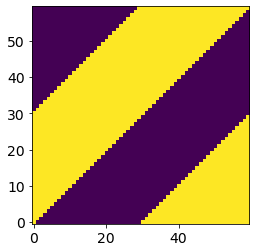

In [228]:
targ = megabatch_target[:, t5+1:t6+1, 4]
targ = torch.mean(targ, 1).reshape(180//ORI_RES, 180//ORI_RES)
plt.imshow(targ, origin='lower')

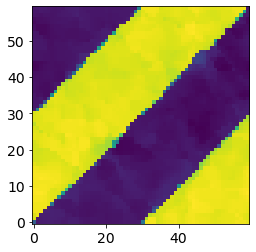

In [229]:
h = megabatch_output[0][:, -1, 4].reshape(180//ORI_RES, 180//ORI_RES, -1)
plt.imshow(h.detach().numpy(), origin='lower')

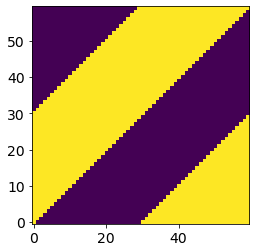

In [230]:
targ = megabatch_target[:, t5+1:t6+1, 4]
targ = torch.mean(targ, 1).reshape(180//ORI_RES, 180//ORI_RES)
plt.imshow(targ, origin='lower')


## Tunings of neurons

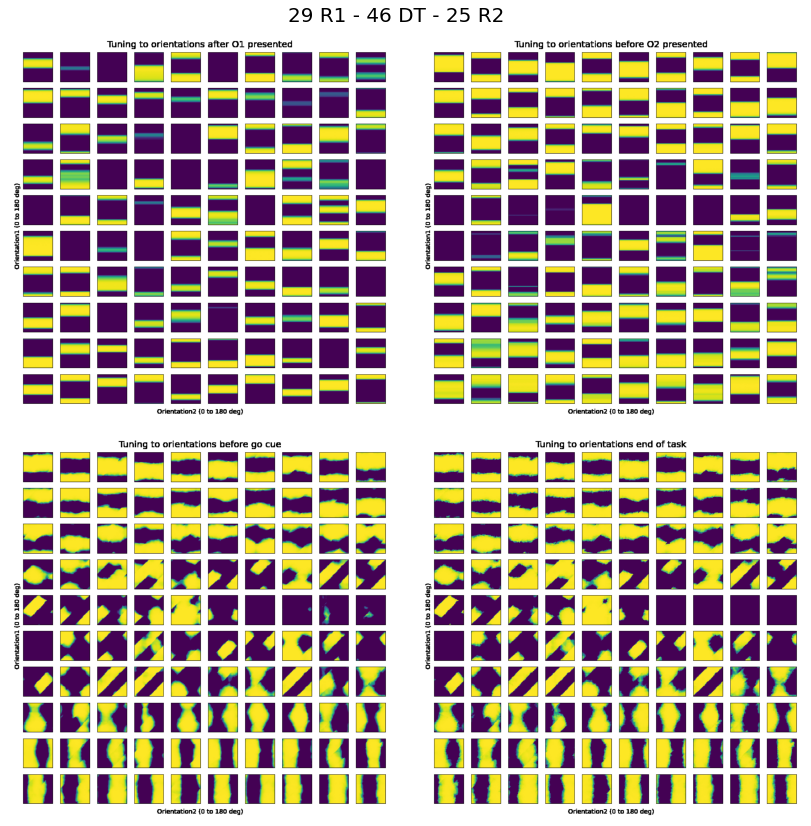

In [231]:
t=t6
images_side_by_side((
    plt_to_image(get_tuning_heatmaps(t2, t2d, sor_i=megabatch_tuningindices[t])),
    plt_to_image(get_tuning_heatmaps(t3, t3d, sor_i=megabatch_tuningindices[t])),
    plt_to_image(get_tuning_heatmaps(t5, t5d, sor_i=megabatch_tuningindices[t])),
    plt_to_image(get_tuning_heatmaps(t6, t6d, sor_i=megabatch_tuningindices[t])),
), save_to=make_saving_path("tunings.pdf"), title=f"{R1_num} R1 - {DT_num} DT - {R2_num} R2")

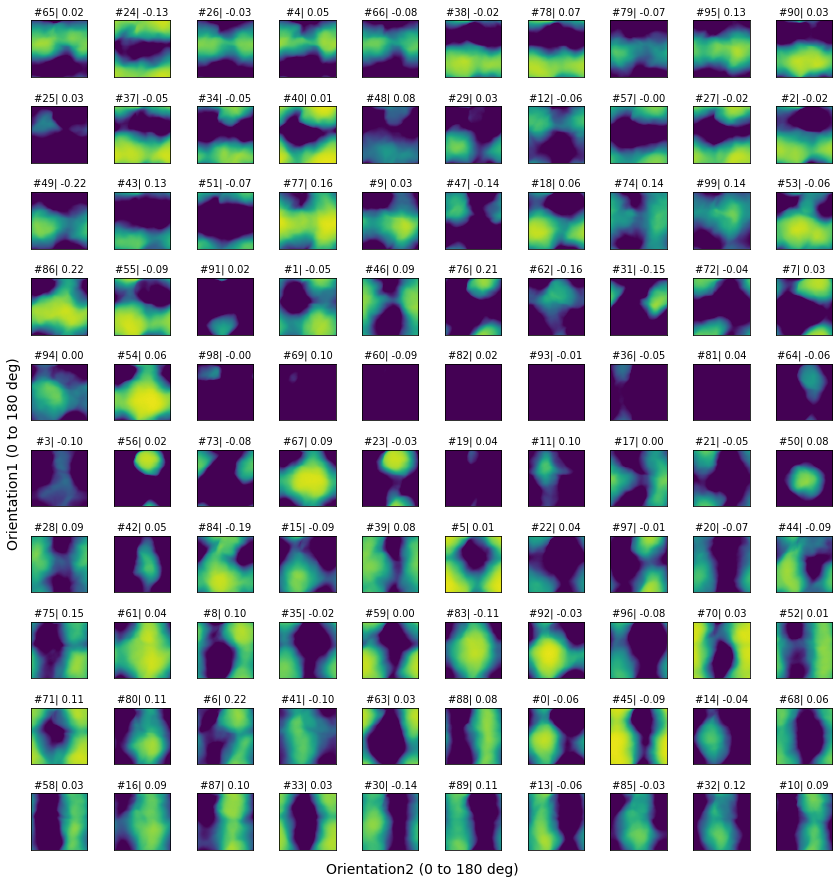

In [223]:
def get_tuning_heatmaps_n(timestep, timestep_description, data_all=None, sor_i=megabatch_tuningindices[-1]):
    plt.close('all')
    
    if data_all is None:
        data_all=megabatch_tuningdata
    if sor_i is None:
        sor_i = megabatch_tuningindices[timestep]
    
    n = len(sor_i)
    sqt = math.ceil(n ** 0.5)
    fig, ax = plt.subplots(nrows=math.ceil(n/sqt), ncols=sqt, figsize=(12, 12))
    for a in ax.ravel():
        #a.title.set_visible(False)
        a.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
        #a.axis('off')
    for i in range(n):
        a = ax[i // sqt][i % sqt]
        a.imshow(data_all[timestep][sor_i][i].detach().numpy(), vmin=0, vmax=1, origin='lower')

        #uncomment to see which unit has which id
        #a.title.set_visible(True)
        #a.set_title(f"{sor_i[i].item()}, {model.fc_h2y.weight[4, sor_i[i]].item():.2f}", fontsize=10)
        a.set_title(f"#{sor_i[i].item()}| {model.fc_h2ah.weight[88, sor_i[i]].item():.2f}", fontsize=10)
        #a.set_title(f"#{sor_i[i].item()}| {model.fc_h2y.weight[4, sor_i[i]].item():.2f}", fontsize=10)
    plt.tight_layout()
    #st = fig.suptitle(f"Tuning to orientations {timestep_description}", fontsize=20)
    fig.supxlabel('Orientation2 (0 to 180 deg)', fontsize=14)
    fig.supylabel('Orientation1 (0 to 180 deg)', fontsize=14)
    fig.subplots_adjust(top=1.0, left=0.04, bottom=0.04)
    return fig
get_tuning_heatmaps_n(t5, t5d)
plt.show()

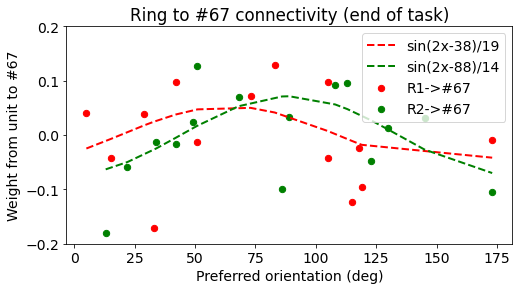

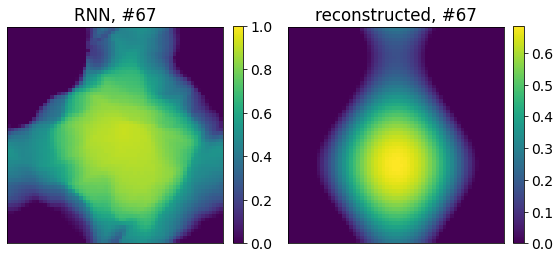

In [224]:
i = 67

O1 = torch.tensor(ORI_SET).repeat(len(ORI_SET), 1).T
O2 = O1.T
timestep, timestep_description = t6, t6d
fig = plt.figure(figsize=(8, 4))
min_k_sin, min_p_sin, min_err_sin = -1, -1, 1e10
for k in range(100):
    for p in range(-90, 90):
        err = torch.sum((model.fc_h2ah.weight[i, R1_i]-torch.sin((R1_pref+p)/180*3.14*2)/k)**2)
        if err<min_err_sin: 
            min_k_sin=k;
            min_p_sin = p;
            min_err_sin=err
r1_k, r1_p = min_k_sin, min_p_sin
min_k_sin, min_p_sin, min_err_sin = -1, -1, 1e10
for k in range(100):
    for p in range(-90, 90):
        err = torch.sum((model.fc_h2ah.weight[i, R2_i]-torch.sin((R2_pref+p)/180*3.14*2)/k)**2)
        if err<min_err_sin: 
            min_k_sin=k;
            min_p_sin = p;
            min_err_sin=err
r2_k, r2_p = min_k_sin, min_p_sin
#plt.plot(R1_pref, model.fc_h2ah.weight[i, R1_i].detach().numpy(), "r", linewidth=3.5, label=f"R1->#{i}")
#plt.plot(R2_pref, model.fc_h2ah.weight[i, R2_i].detach().numpy(), "g", linewidth=3.5, label=f"R2->#{i}")
plt.scatter(R1_pref, model.fc_h2ah.weight[i, R1_i].detach().numpy(), 40, color="r", label=f"R1->#{i}")
plt.scatter(R2_pref, model.fc_h2ah.weight[i, R2_i].detach().numpy(), 40, color="g", label=f"R2->#{i}")
plt.plot(R1_pref, torch.sin((R1_pref+r1_p)/180*3.14*2)/r1_k, "r--", linewidth=2, label=f"sin(2x{'+'if r1_p>0 else '-'}{2*abs(r1_p)})/{r1_k}")
plt.plot(R2_pref, torch.sin((R2_pref+r2_p)/180*3.14*2)/r2_k, "g--", linewidth=2, label=f"sin(2x{'+'if r2_p>0 else '-'}{2*abs(r2_p)})/{r2_k}")
plt.ylim(-0.2, 0.2)
plt.legend()
#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
plt.xlabel('Preferred orientation (deg)')
plt.ylabel(f'Weight from unit to #{i}')
plt.title(f'Ring to #{i} connectivity ({timestep_description})')
plt.legend()
plt.show()

h = torch.sin((2*O1+r1_p*2)/180*math.pi)/r1_k*len(R1_i)/2.2+torch.sin((2*O2+r2_p*2)/180*math.pi)/r2_k*len(R2_i)/2.2+model.fc_x2ah.bias[i]
#h = torch.sign(h)
#h -= megabatch_tuningdata[timestep][54]*3
#h -= megabatch_tuningdata[timestep][1]*3
h = torch.tanh(h)
h = torch.maximum(h, torch.zeros(h.shape))
h = h.detach().numpy()

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 2)
ax.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
ax.set_title(f"reconstructed, #{i}")
im = ax.imshow(h, origin="lower")#, vmin=0, vmax=1)
plt.colorbar(im, ax=ax, orientation="vertical",fraction=0.046, pad=0.04)
ax = fig.add_subplot(1, 2, 1)
ax.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
ax.set_title(f"RNN, #{i}")
im = ax.imshow(megabatch_tuningdata[timestep][i].detach().numpy(), origin="lower", vmin=0, vmax=1)
plt.colorbar(im, ax=ax, orientation="vertical",fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [ ]:
h = torch.sin(2*O1/180*math.pi)
h = np.zeros(O1.shape)
h[torch.logical_and(O2-O1<90, O2-O1>0)] = 1
h[O2-O1<-90] = 1
h = 1 - h
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
ax.set_title(f"target (O2 cw O1)")
ax.set_xlabel("O2 (0 to 180)")
ax.set_ylabel("O1 (0 to 180)")
im = ax.imshow(h, origin="lower")#, vmin=0, vmax=1)
plt.colorbar(im, ax=ax, orientation="vertical",fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

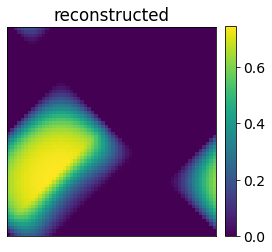

In [283]:
h1 = torch.sin((2*O1+0)/180*math.pi)/1+torch.sin((2*O2+0)/180*math.pi)/1
h1 = torch.maximum(torch.tanh(h1), torch.zeros(h1.shape))

h2 = torch.sin((2*O1+80)/180*math.pi)/1+torch.sin((2*O2-80)/180*math.pi)/1
h2 = torch.maximum(torch.tanh(h2), torch.zeros(h2.shape))

h = h1-h2
h = torch.maximum(torch.tanh(h), torch.zeros(h.shape))
h_a = h

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
ax.set_title(f"reconstructed")
im = ax.imshow(h, origin="lower")#, vmin=0, vmax=1)
plt.colorbar(im, ax=ax, orientation="vertical",fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

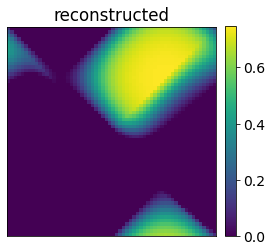

In [249]:
h1 = torch.sin((2*O1-180)/180*math.pi)/1+torch.sin((2*O2-180)/180*math.pi)/1
h1 = torch.maximum(torch.tanh(h1), torch.zeros(h1.shape))

h2 = torch.sin((2*O1-80)/180*math.pi)/1+torch.sin((2*O2-260)/180*math.pi)/1
h2 = torch.maximum(torch.tanh(h2), torch.zeros(h2.shape))

h = h1-h2
h = torch.maximum(torch.tanh(h), torch.zeros(h.shape))
h_b = h

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
ax.set_title(f"reconstructed")
im = ax.imshow(h, origin="lower")#, vmin=0, vmax=1)
plt.colorbar(im, ax=ax, orientation="vertical",fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

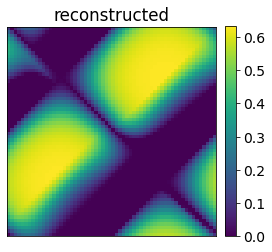

In [250]:
h = h_a+h_b
h = torch.maximum(torch.tanh(h), torch.zeros(h.shape))

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
ax.set_title(f"reconstructed")
im = ax.imshow(h, origin="lower")#, vmin=0, vmax=1)
plt.colorbar(im, ax=ax, orientation="vertical",fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

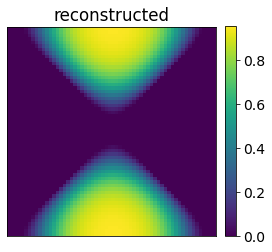

In [226]:
h = torch.sin((2*O1+90)/180*math.pi)/1+torch.sin((2*O2-90)/180*math.pi)/1+-0.1
#h = torch.sign(h)
#h -= megabatch_tuningdata[timestep][54]*3
#h -= megabatch_tuningdata[timestep][1]*3
h = torch.tanh(h)
h = torch.maximum(h, torch.zeros(h.shape))
h = h.detach().numpy()

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
ax.set_title(f"reconstructed")
im = ax.imshow(h, origin="lower")#, vmin=0, vmax=1)
plt.colorbar(im, ax=ax, orientation="vertical",fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

## Ring->Output

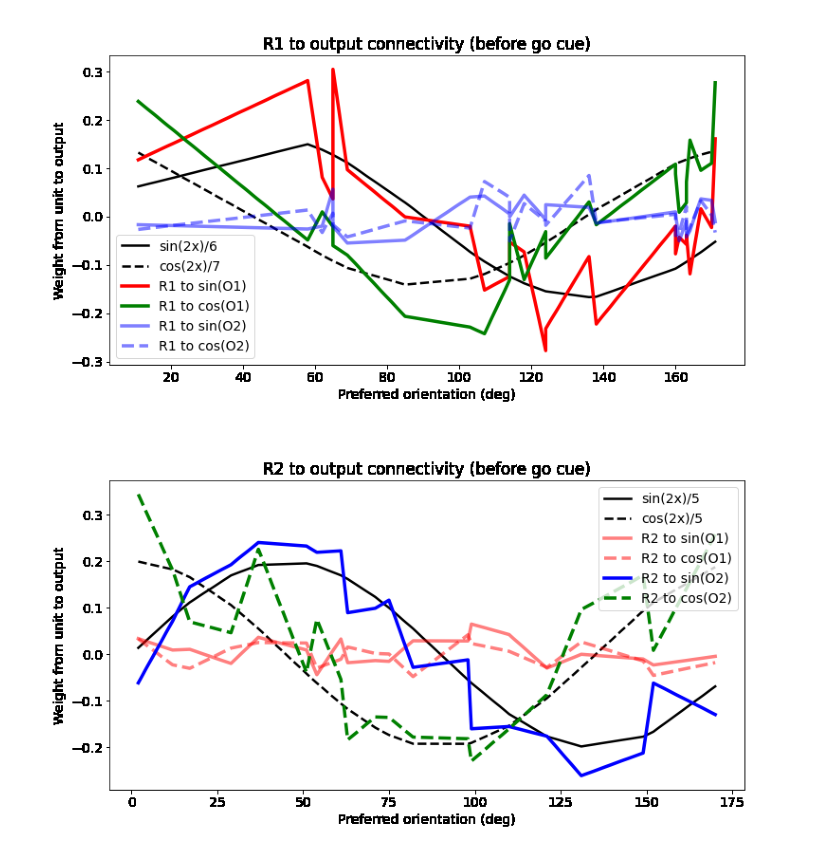

In [642]:
if simple_output:
    timestep = t5
    timestep_description = t5d
    R1_i = megabatch_tuningindices[timestep][:R1_ends_at_i]
    R2_i = megabatch_tuningindices[timestep][R2_starts_from_i:]
    R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
    R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
    
    w = model.fc_x2ah.weight[R2_i, :-1].detach().numpy()
    a = np.angle(np.sum(w*np.exp(1j*(np.arange(32)/32*2*np.pi)).reshape(1, -1), axis=1)/np.sum(np.abs(w), axis=1)) * 180 / np.pi / 2
    a[a<0] = a[a<0]+180
    #R2_pref = torch.tensor(a)
    w = model.fc_x2ah.weight[R1_i, :-1].detach().numpy()
    a = np.angle(np.sum(w*np.exp(1j*(np.arange(32)/32*2*np.pi)).reshape(1, -1), axis=1)/np.sum(np.abs(w), axis=1)) * 180 / np.pi / 2
    a[a<0] = a[a<0]+180
    #R1_pref = torch.tensor(a)
    
    w = torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2).detach().numpy()
    a = np.angle(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1)/np.sum(np.abs(w), axis=1)) * 180 / np.pi / 2
    a[a<0] = a[a<0]+180
    R1_pref = torch.tensor(a)
    w = torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1).detach().numpy()
    a = np.angle(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1)/np.sum(np.abs(w), axis=1)) * 180 / np.pi / 2
    a[a<0] = a[a<0]+180
    R2_pref = torch.tensor(a)
    
    R1_pref, R2_pref = calc_pref(R1_i, timestep, to=1), calc_pref(R2_i, timestep, to=2)
    
    #R2_pref = torch.max(model.fc_x2ah.weight[R2_i, :-1], dim=1).indices * 180 / 32
    #R1_pref = torch.max(model.fc_x2ah.weight[R1_i, :-1], dim=1).indices * 180 / 32
    #sort units within R1 and R2 by preferred angle
    R1_i = R1_i.clone()[torch.argsort(R1_pref)]
    R1_pref = R1_pref.clone()[torch.argsort(R1_pref)]
    R2_i = R2_i.clone()[torch.argsort(R2_pref)]
    R2_pref = R2_pref.clone()[torch.argsort(R2_pref)]

    # find closest sin and cos
    min_k_sin, min_k_cos, min_err_sin, min_err_cos = -1, -1, 1e10, 1e10
    for k in range(20):
        err = torch.sum((model.fc_h2y.weight[:, R1_i][0]-torch.sin(R1_pref/180*3.14*2)/k)**2)
        if err<min_err_sin: min_k_sin=k;min_err_sin=err
        err = torch.sum((model.fc_h2y.weight[:, R1_i][1]-torch.cos(R1_pref/180*3.14*2)/k)**2)
        if err<min_err_cos: min_k_cos=k;min_err_cos=err
    plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
    fig = plt.figure(figsize=(12, 6))
    plt.plot(R1_pref.cpu().detach().numpy(), torch.sin(R1_pref/180*3.14*2).cpu().detach().numpy()/min_k_sin, 
             "k-", linewidth=2.5, label=f"sin(2x)/{min_k_sin}")
    plt.plot(R1_pref.cpu().detach().numpy(), torch.cos(R1_pref/180*3.14*2).cpu().detach().numpy()/min_k_cos, 
             "k--", linewidth=2.5, label=f"cos(2x)/{min_k_cos}")
    plt.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][0].cpu().detach().numpy(), 
             "r-", linewidth=3.5, label="R1 to sin(O1)")
    plt.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][1].cpu().detach().numpy(), 
             "g-", linewidth=3.5, label="R1 to cos(O1)", alpha=1)
    plt.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][2].cpu().detach().numpy(), 
             "b-", linewidth=3.5, label="R1 to sin(O2)", alpha=0.5)
    plt.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][3].cpu().detach().numpy(), 
             "b--", linewidth=3.5, label="R1 to cos(O2)", alpha=0.5)

    #plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
    #plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
    plt.xlabel('Preferred orientation (deg)')
    plt.ylabel('Weight from unit to output')
    plt.title(f'R1 to output connectivity ({timestep_description})')
    plt.legend()
    im1 = plt_to_image(fig)

    # find closest sin and cos
    min_k_sin, min_k_cos, min_err_sin, min_err_cos = -1, -1, 1e10, 1e10
    for k in range(20):
        err = torch.sum((model.fc_h2y.weight[:, R2_i][2]-torch.sin(R2_pref/180*3.14*2)/k)**2)
        if err<min_err_sin: min_k_sin=k;min_err_sin=err
        err = torch.sum((model.fc_h2y.weight[:, R2_i][3]-torch.cos(R2_pref/180*3.14*2)/k)**2)
        if err<min_err_cos: min_k_cos=k;min_err_cos=err
    fig = plt.figure(figsize=(12, 6))
    plt.plot(R2_pref.cpu().detach().numpy(), torch.sin(R2_pref/180*3.14*2).cpu().detach().numpy()/min_k_sin, 
             "k-", linewidth=2.5, label=f"sin(2x)/{min_k_sin}")
    plt.plot(R2_pref.cpu().detach().numpy(), torch.cos(R2_pref/180*3.14*2).cpu().detach().numpy()/min_k_cos, 
             "k--", linewidth=2.5, label=f"cos(2x)/{min_k_cos}")
    plt.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][0].cpu().detach().numpy(), 
             "r-", linewidth=3.5, label="R2 to sin(O1)", alpha=0.5)
    plt.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][1].cpu().detach().numpy(), 
             "r--", linewidth=3.5, label="R2 to cos(O1)", alpha=0.5)
    plt.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][2].cpu().detach().numpy(), 
             "b-", linewidth=3.5, label="R2 to sin(O2)")
    plt.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][3].cpu().detach().numpy(), 
             "g--", linewidth=3.5, label="R2 to cos(O2)")
    #plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
    #plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
    plt.xlabel('Preferred orientation (deg)')
    plt.ylabel('Weight from unit to output')
    plt.title(f'R2 to output connectivity ({timestep_description})')
    plt.legend()
    im2 = plt_to_image(fig)

    images_side_by_side((im1, im2), vert_pref=True, figsize=(12, 12), save_to=make_saving_path("ring_output_connectivity.pdf"))

## Clustering

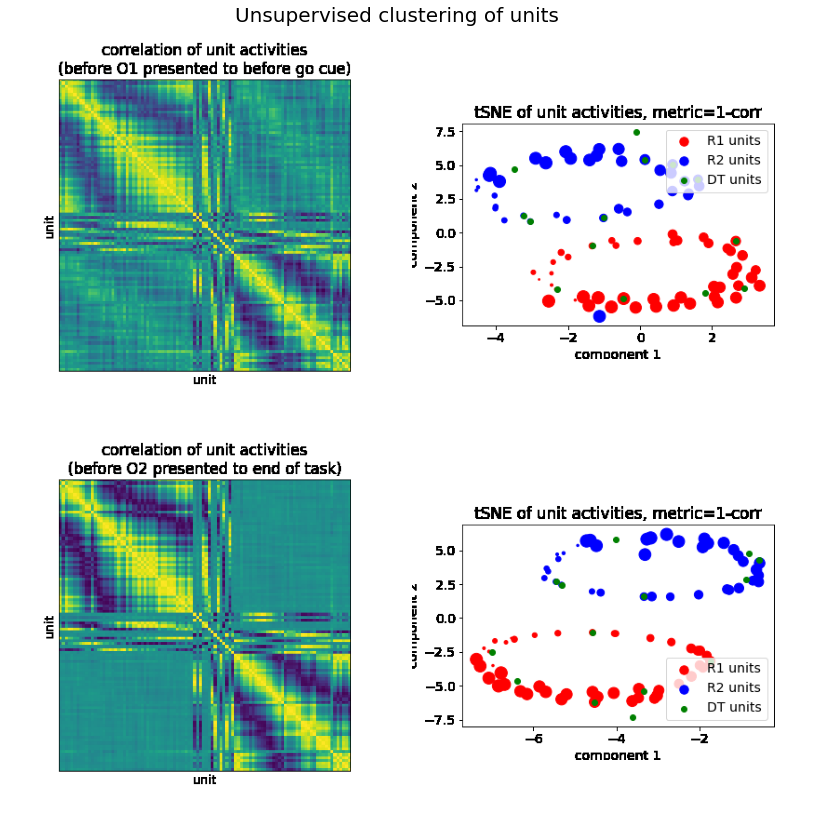

In [24]:
t_from, t_from_d = t1, t1d
t_to, t_to_d = t5, t5d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
#corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"correlation of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, dim_recurrent-1])
plt.yticks([0, dim_recurrent-1])
im1 = plt_to_image(fig)

tsne = TSNE(2, metric='precomputed', init='random', learning_rate='auto')
tsne_result = tsne.fit_transform(1-(corr))
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"tSNE of unit activities, metric=1-corr")
plt.legend()
im2 = plt_to_image(fig)

t_from, t_from_d = t3, t3d
t_to, t_to_d = t6, t6d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
#corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"correlation of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, dim_recurrent-1])
plt.yticks([0, dim_recurrent-1])
im3 = plt_to_image(fig)

tsne = TSNE(2, metric='precomputed', init='random', learning_rate='auto')
tsne_result = tsne.fit_transform(1-(corr))
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"tSNE of unit activities, metric=1-corr")
plt.legend()
im4 = plt_to_image(fig)

images_side_by_side((
    im1, im2, im3, im4
), save_to=make_saving_path("clustering.pdf"), title=f"Unsupervised clustering of units")

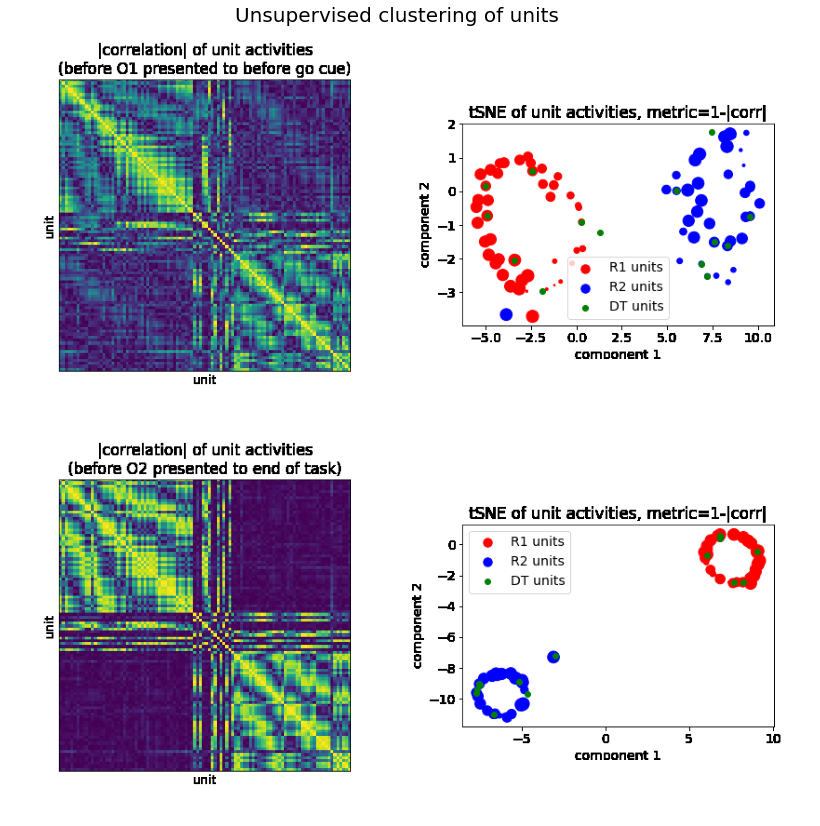

In [25]:
t_from, t_from_d = t1, t1d
t_to, t_to_d = t5, t5d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"|correlation| of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, dim_recurrent-1])
plt.yticks([0, dim_recurrent-1])
im1 = plt_to_image(fig)

tsne = TSNE(2, metric='precomputed', init='random', learning_rate='auto')
tsne_result = tsne.fit_transform(1-(corr))
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"tSNE of unit activities, metric=1-|corr|")
plt.legend()
im2 = plt_to_image(fig)

t_from, t_from_d = t3, t3d
t_to, t_to_d = t6, t6d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"|correlation| of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, dim_recurrent-1])
plt.yticks([0, dim_recurrent-1])
im3 = plt_to_image(fig)

tsne = TSNE(2, metric='precomputed', init='random', learning_rate='auto')
tsne_result = tsne.fit_transform(1-(corr))
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"tSNE of unit activities, metric=1-|corr|")
plt.legend()
im4 = plt_to_image(fig)

images_side_by_side((
    im1, im2, im3, im4
), save_to=make_saving_path("clustering_abs.pdf"), title=f"Unsupervised clustering of units")

In [147]:
import openTSNE

def oneminus_corr_xy(x, y):
    c = np.corrcoef(x, y)[0][1]
    return 1-c if c==c else 0
def oneminus_abs_corr_xy(x, y):
    c = np.corrcoef(x, y)[0][1]
    return 1-np.abs(c) if c==c else 0

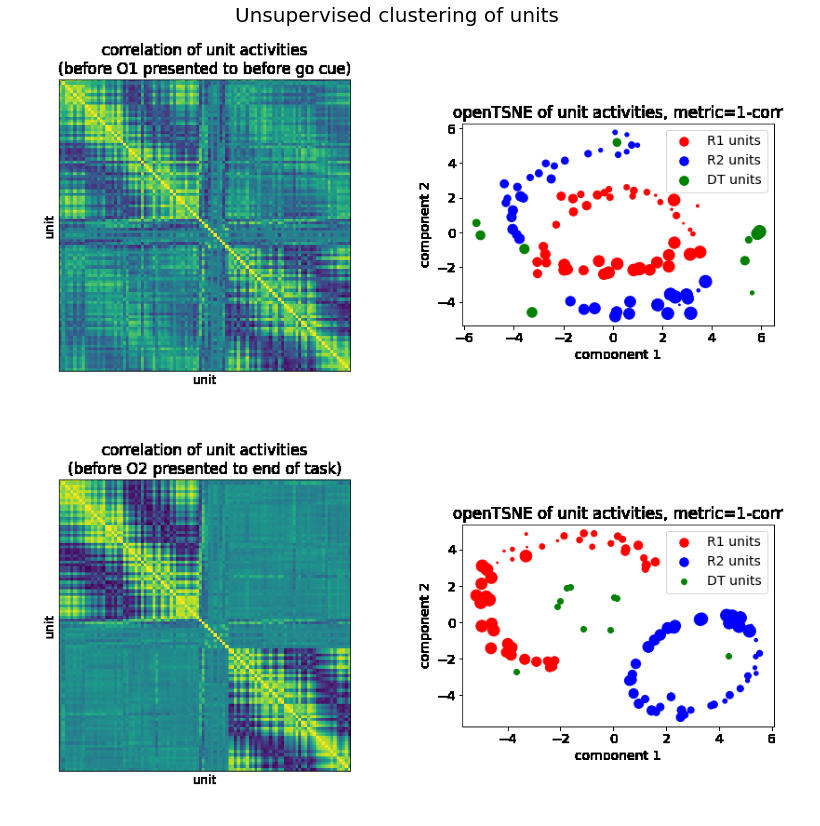

In [149]:
t_from, t_from_d = t1, t1d
t_to, t_to_d = t5, t5d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
#corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"correlation of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, 99])
plt.yticks([0, 99])
im1 = plt_to_image(fig)

tsne = openTSNE.TSNE(
    perplexity=30,
    metric=oneminus_corr_xy,
    n_jobs=8,
    random_state=42,
    verbose=False,
)
tsne_result = tsne.fit(arr)
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
DT_R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][DT_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], DT_R1_pref, color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"openTSNE of unit activities, metric=1-corr")
plt.legend()
im2 = plt_to_image(fig)


t_from, t_from_d = t3, t3d
t_to, t_to_d = t6, t6d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
#corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"correlation of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, 99])
plt.yticks([0, 99])
im3 = plt_to_image(fig)

tsne = openTSNE.TSNE(
    perplexity=30,
    metric=oneminus_corr_xy,
    n_jobs=8,
    random_state=42,
    verbose=False,
)
tsne_result = tsne.fit(arr)
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
DT_R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][DT_i], dim=2), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"openTSNE of unit activities, metric=1-corr")
plt.legend()
im4 = plt_to_image(fig)

images_side_by_side((
    im1, im2, im3, im4
), save_to=make_saving_path("clustering_opentsne.pdf"), title=f"Unsupervised clustering of units")

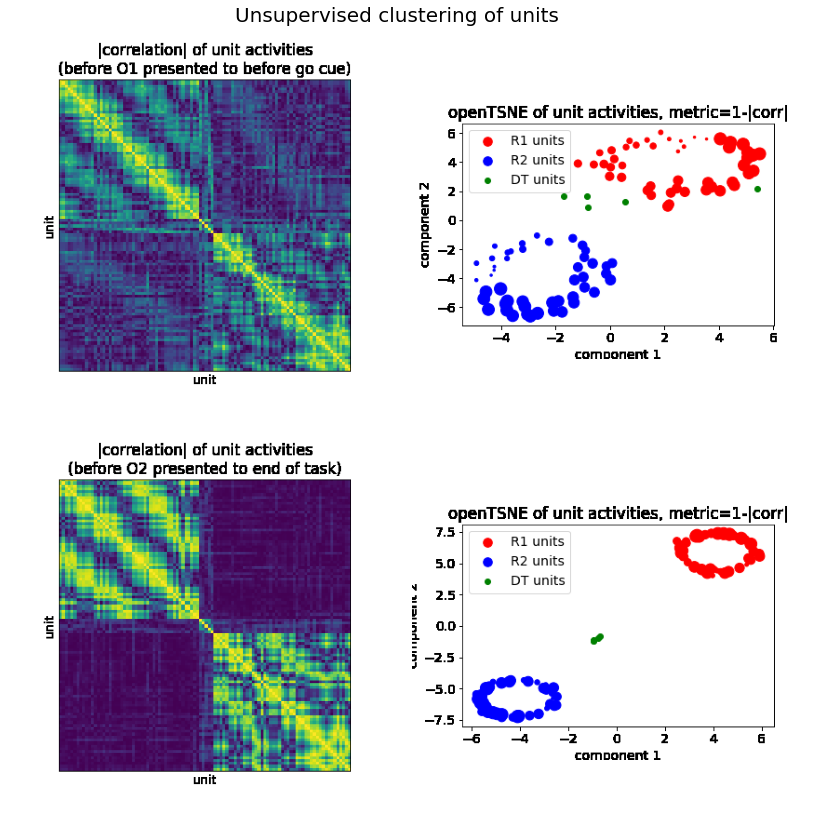

In [111]:
t_from, t_from_d = t1, t1d
t_to, t_to_d = t5, t5d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"|correlation| of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, 99])
plt.yticks([0, 99])
im1 = plt_to_image(fig)

tsne = openTSNE.TSNE(
    perplexity=30,
    metric=oneminus_abs_corr_xy,
    n_jobs=8,
    random_state=42,
    verbose=False,
)
tsne_result = tsne.fit(arr)
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"openTSNE of unit activities, metric=1-|corr|")
plt.legend()
im2 = plt_to_image(fig)

t_from, t_from_d = t3, t3d
t_to, t_to_d = t6, t6d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"|correlation| of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, 99])
plt.yticks([0, 99])
im3 = plt_to_image(fig)

tsne = openTSNE.TSNE(
    perplexity=30,
    metric=oneminus_abs_corr_xy,
    n_jobs=8,
    random_state=42,
    verbose=False,
)
tsne_result = tsne.fit(arr)
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"openTSNE of unit activities, metric=1-|corr|")
plt.legend()
im4 = plt_to_image(fig)

images_side_by_side((
    im1, im2, im3, im4
), save_to=make_saving_path("clustering_opentsne_abs.pdf"), title=f"Unsupervised clustering of units")

## Ring->Ring

In [67]:
def get_connplot_graph(timestep, R1_i=None, R2_i=None, R1_pref=None, R2_pref=None, cc_smoothing=True, R2_R1_pref=False):
    if R1_i is None:
        R1_i = megabatch_tuningindices[timestep][:R1_ends_at_i]
    if R2_i is None:
        R2_i = megabatch_tuningindices[timestep][R2_starts_from_i:]
    if R1_pref is None:
        R1_pref = calc_pref(R1_i, timestep, to=1)
    if R2_pref is None:
        if not R2_R1_pref:
            R2_pref = calc_pref(R2_i, timestep, to=2)
        else:
            R2_pref = calc_pref(R2_i, timestep, to=1)
    W = model.fc_h2ah.weight
    sm = 5 # size of smoothing
    distances_weights = {}
    for i in range(len(R1_i)):
        for j in range(len(R1_i)):
            if j == i: continue
            diff = (R1_pref[i]-R1_pref[j]).item()
            diff = (diff + 180 + 90) % 180 - 90
            if not cc_smoothing: 
                diff = (diff // sm) * sm
            w_ij = W[R1_i[j], R1_i[i]] # weight from i to j 
            for c in (range(-sm//2, sm//2+1) if cc_smoothing else [0]):
                if diff+c not in distances_weights: distances_weights[diff+c] = []
                distances_weights[diff+c].append(w_ij.item())
    r1_distances = np.array(sorted(distances_weights.keys()))
    r1_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in r1_distances]
    r1_weights_std = [np.std(distances_weights[diff]) for diff in r1_distances]
    distances_weights = {}
    for i in range(len(R2_i)):
        for j in range(len(R2_i)):
            if j == i: continue
            diff = (R2_pref[i]-R2_pref[j]).item()
            diff = (diff + 180 + 90) % 180 - 90
            if not cc_smoothing: 
                diff = (diff // sm) * sm
            w_ij = W[R2_i[j], R2_i[i]] # weight from i to j 
            for c in (range(-sm//2, sm//2+1) if cc_smoothing else [0]):
                if diff+c not in distances_weights: distances_weights[diff+c] = []
                distances_weights[diff+c].append(w_ij.item())
    r2_distances = np.array(sorted(distances_weights.keys()))
    r2_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in r2_distances] 
    r2_weights_std = [np.std(distances_weights[diff]) for diff in r2_distances]
    return r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std

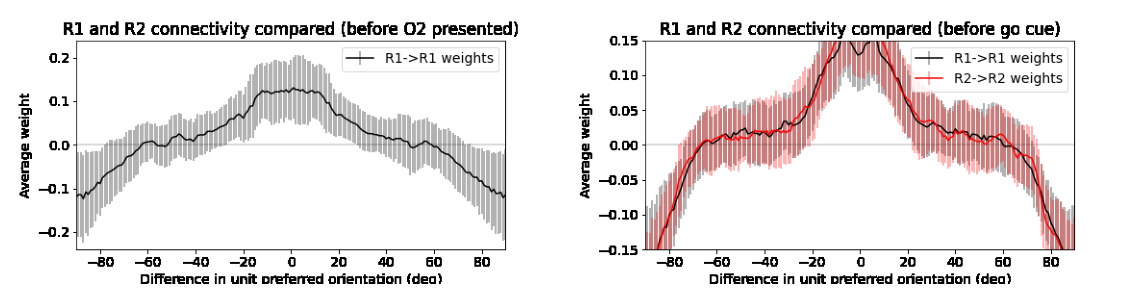

In [71]:
timestep, timestep_desc = t5, t5d
r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std = get_connplot_graph(timestep, R1_i=R1_i, R2_i=R2_i)
fig = plt.figure(figsize=(8, 4))
markers, caps, bars = plt.errorbar(r1_distances, r1_weights, r1_weights_std, color='k', markersize=10, label="R1->R1 weights", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
markers, caps, bars = plt.errorbar(r2_distances, r2_weights, r2_weights_std, color='r', markersize=10, label="R2->R2 weights", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
plt.xlabel('Difference in unit preferred orientation (deg)')
plt.ylabel('Average weight')
plt.title(f'R1 and R2 connectivity compared ({timestep_desc})')
plt.legend()
plt.xlim(-90, 90)
plt.ylim(-0.15, 0.15)

im1 = plt_to_image(fig)
timestep, timestep_desc = t3, t3d
r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std = get_connplot_graph(timestep, R1_i=R1_i, R2_i=R2_i, R2_R1_pref=True)
fig = plt.figure(figsize=(8, 4))
markers, caps, bars = plt.errorbar(r1_distances, r1_weights, r1_weights_std, color='k', markersize=10, label="R1->R1 weights", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
#markers, caps, bars = plt.errorbar(r2_distances, r2_weights, r2_weights_std, color='r', markersize=10, label="R2->R2 weights", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
plt.xlabel('Difference in unit preferred orientation (deg)')
plt.ylabel('Average weight')
plt.title(f'R1 and R2 connectivity compared ({timestep_desc})')
plt.legend()
plt.xlim(-90, 90)
plt.ylim(-0.24, 0.24)
im2 = plt_to_image(fig)

images_side_by_side((im2, im1), figsize=(16, 8), 
                    save_to=make_saving_path("ring_connectivity.pdf"))

In [72]:
def get_connplot_r1r2_graph(timestep, R1_i=None, R2_i=None, R1_pref=None, R2_pref=None, cc_smoothing=True, sm=10):
    if R1_i is None:
        R1_i = megabatch_tuningindices[timestep][:R1_ends_at_i]
    if R2_i is None:
        R2_i = megabatch_tuningindices[timestep][R2_starts_from_i:]
    if R1_pref is None:
        R1_pref = calc_pref(R1_i, timestep, to=1)
    if R2_pref is None:
        R2_pref = calc_pref(R2_i, timestep, to=2)
        
    W = model.fc_h2ah.weight
    distances_weights = {}
    for i in range(len(R1_i)):
        for j in range(len(R2_i)):
            #if j == i: continue
            diff = (R1_pref[i]-R2_pref[j]).item()
            diff = (diff + 180 + 90) % 180 - 90
            if not cc_smoothing: 
                diff = (diff // sm) * sm
            w_ij = W[R2_i[j], R1_i[i]] # weight from i to j 
            for c in (range(-sm//2, sm//2+1) if cc_smoothing else [0]):
                if diff+c not in distances_weights: distances_weights[diff+c] = []
                distances_weights[diff+c].append(w_ij.item())
    r1_distances = np.array(sorted(distances_weights.keys()))
    r1_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in r1_distances]
    r1_weights_std = [np.std(distances_weights[diff]) for diff in r1_distances]
    distances_weights = {}
    for i in range(len(R2_i)):
        for j in range(len(R1_i)):
            #if j == i: continue
            diff = (R2_pref[i]-R1_pref[j]).item()
            diff = (diff + 180 + 90) % 180 - 90
            if not cc_smoothing: 
                diff = (diff // sm) * sm
            w_ij = W[R1_i[j], R2_i[i]] # weight from i to j 
            for c in (range(-sm//2, sm//2+1) if cc_smoothing else [0]):
                if diff+c not in distances_weights: distances_weights[diff+c] = []
                distances_weights[diff+c].append(w_ij.item())
    r2_distances = np.array(sorted(distances_weights.keys()))
    r2_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in r2_distances] 
    r2_weights_std = [np.std(distances_weights[diff]) for diff in r2_distances]
    return r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std

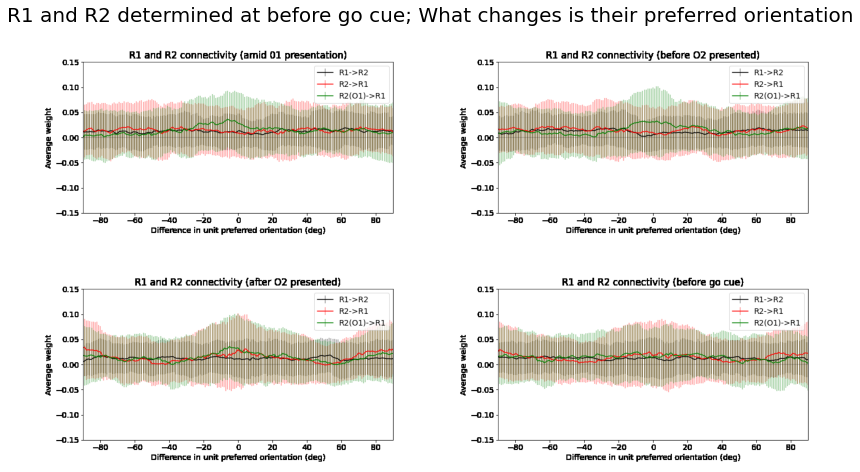

In [73]:
R1_i = megabatch_tuningindices[t5][:R1_ends_at_i]
R2_i = megabatch_tuningindices[t5][R2_starts_from_i:]
images = []
for i, x in enumerate([(t1_5, t1_5d), (t3, t3d), (t4, t4d), (t5, t5d)]):
    timestep, timestep_desc = x
    R1_pref = calc_pref(R1_i, timestep, to=1)
    R2_pref = calc_pref(R2_i, timestep, to=2)

    r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std = get_connplot_r1r2_graph(timestep, R1_i, R2_i, R1_pref, R2_pref)

    fig = plt.figure(figsize=(10, 5))
    markers, caps, bars = plt.errorbar(r1_distances, r1_weights, r1_weights_std, color='k', markersize=10, label="R1->R2", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    markers, caps, bars = plt.errorbar(r2_distances, r2_weights, r2_weights_std, color='r', markersize=10, label="R2->R1", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    if timestep < t4*100:
        R2_O1_pref = calc_pref(R2_i, timestep, to=1)
        r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std = get_connplot_r1r2_graph(timestep, R1_i, R2_i, R1_pref, R2_O1_pref)
        markers, caps, bars = plt.errorbar(r2_distances, r2_weights, r2_weights_std, color='g', markersize=10, label="R2(O1)->R1", capsize=0)
        [bar.set_alpha(0.4) for bar in bars]
        [cap.set_alpha(0.4) for cap in caps]
    plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
    plt.xlabel('Difference in unit preferred orientation (deg)')
    plt.ylabel('Average weight')
    plt.title(f'R1 and R2 connectivity ({timestep_desc})')
    plt.legend()
    plt.xlim(-90, 90)
    plt.ylim(-0.15, 0.15)
    images.append(plt_to_image(fig))
images_side_by_side(images, 
                    save_to=make_saving_path("r1_r2_connectivity.pdf"), 
                    title="R1 and R2 determined at before go cue; What changes is their preferred orientation",
                    figsize=(12, 7))

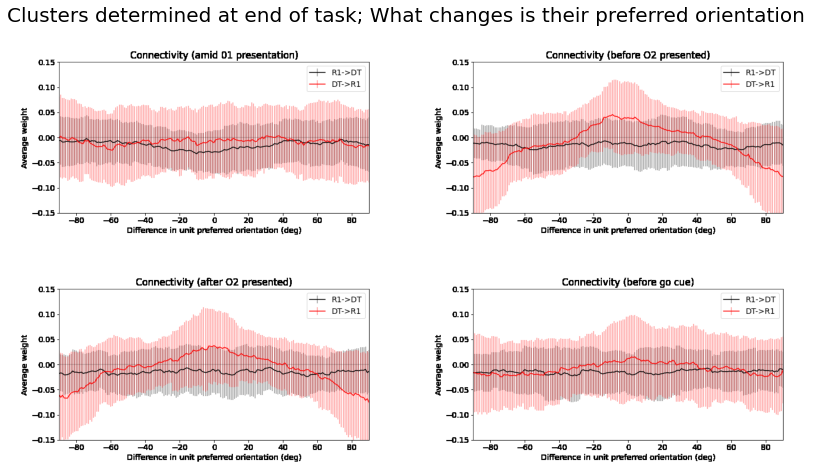

In [74]:
R1_i = megabatch_tuningindices[t6][:R1_ends_at_i]
R2_i = megabatch_tuningindices[t6][R2_starts_from_i:]
images = []
for i, x in enumerate([(t1_5, t1_5d), (t3, t3d), (t4, t4d), (t5, t5d)]):
    timestep, timestep_desc = x
    R1_pref = calc_pref(R1_i, timestep, to=1)
    R2_pref = calc_pref(R2_i, timestep, to=2)
    DT_R1_pref = calc_pref(DT_i, timestep, to=1)
    DT_R2_pref = calc_pref(DT_i, timestep, to=2)

    r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std = get_connplot_r1r2_graph(timestep, R1_i, DT_i, R1_pref, DT_R1_pref, sm=20)

    fig = plt.figure(figsize=(10, 5))
    markers, caps, bars = plt.errorbar(r1_distances, r1_weights, r1_weights_std, color='k', markersize=10, label="R1->DT", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    markers, caps, bars = plt.errorbar(r2_distances, r2_weights, r2_weights_std, color='r', markersize=10, label="DT->R1", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
    plt.xlabel('Difference in unit preferred orientation (deg)')
    plt.ylabel('Average weight')
    plt.title(f'Connectivity ({timestep_desc})')
    plt.legend()
    plt.xlim(-90, 90)
    plt.ylim(-0.15, 0.15)
    images.append(plt_to_image(fig))
images_side_by_side(images, 
                    save_to=make_saving_path("r1_r2_connectivity.pdf"), 
                    title="Clusters determined at end of task; What changes is their preferred orientation",
                    figsize=(12, 7))

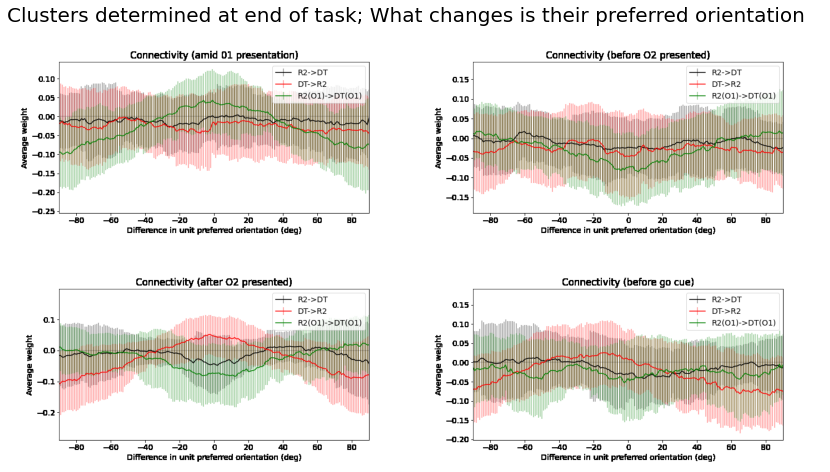

In [77]:
R1_i = megabatch_tuningindices[t6][:R1_ends_at_i]
R2_i = megabatch_tuningindices[t6][R2_starts_from_i:]
images = []
for i, x in enumerate([(t1_5, t1_5d), (t3, t3d), (t4, t4d), (t5, t5d)]):
    timestep, timestep_desc = x
    R1_pref = calc_pref(R1_i, timestep, to=1)
    R2_pref = calc_pref(R2_i, timestep, to=2)
    DT_R1_pref = calc_pref(DT_i, timestep, to=1)
    DT_R2_pref = calc_pref(DT_i, timestep, to=2)

    r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std = get_connplot_r1r2_graph(timestep, R2_i, DT_i, R2_pref, DT_R2_pref, sm=20)

    fig = plt.figure(figsize=(10, 5))
    markers, caps, bars = plt.errorbar(r1_distances, r1_weights, r1_weights_std, color='k', markersize=10, label="R2->DT", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    markers, caps, bars = plt.errorbar(r2_distances, r2_weights, r2_weights_std, color='r', markersize=10, label="DT->R2", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    if timestep < t4*100:
        R2_O1_pref = calc_pref(R2_i, timestep, to=1)
        r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std = get_connplot_r1r2_graph(timestep, R2_i, DT_i, R2_O1_pref, DT_R1_pref, sm=20)
        markers, caps, bars = plt.errorbar(r2_distances, r2_weights, r2_weights_std, color='g', markersize=10, label="R2(O1)->DT(O1)", capsize=0)
        [bar.set_alpha(0.4) for bar in bars]
        [cap.set_alpha(0.4) for cap in caps]
    plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
    plt.xlabel('Difference in unit preferred orientation (deg)')
    plt.ylabel('Average weight')
    plt.title(f'Connectivity ({timestep_desc})')
    plt.legend()
    plt.xlim(-90, 90)
    images.append(plt_to_image(fig))
images_side_by_side(images, 
                    save_to=make_saving_path("r1_r2_connectivity.pdf"), 
                    title="Clusters determined at end of task; What changes is their preferred orientation",
                    figsize=(12, 7))

## Input->Ring

In [4]:
def get_connplot_iu_graph(units_id, unit_pref, timestep, cc_smoothing=True, sm=0):
    distances_weights = {}
    for i in range(len(units_id)):
        for j in range(orientation_neurons):
            if j == i: continue
            diff = (unit_pref[i]-round(180*j/orientation_neurons)).item()
            diff = (diff + 180 + 90) % 180 - 90
            if not cc_smoothing: 
                diff = (diff // sm) * sm
            w_ij = model.fc_x2ah.weight[units_id[i], j] # weight from i to j 
            for c in (range(-sm//2, sm//2+1) if cc_smoothing else [0]):
                if diff+c not in distances_weights: distances_weights[diff+c] = []
                distances_weights[diff+c].append(w_ij.item())
                
    o1_distances = np.array(sorted(distances_weights.keys()))
    o1_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in o1_distances]
    o1_weights_std = [np.std(distances_weights[diff]) for diff in o1_distances]
    return o1_distances, o1_weights, o1_weights_std

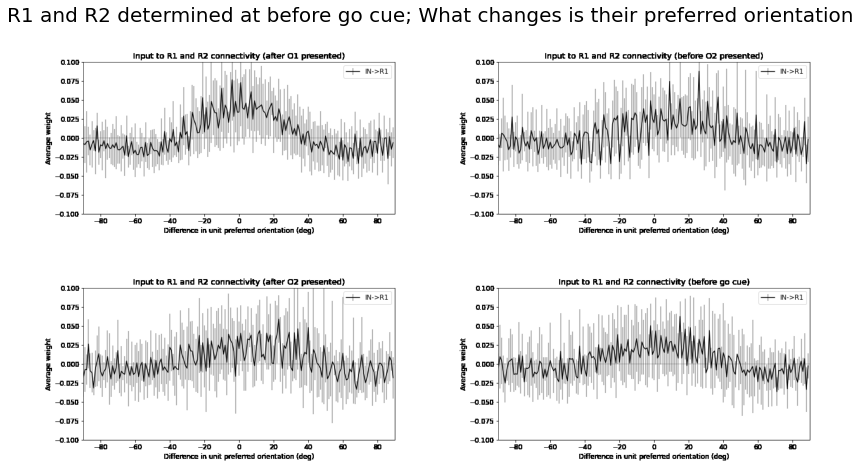

In [193]:
R1_i = megabatch_tuningindices[t5][:R1_ends_at_i]
R2_i = megabatch_tuningindices[t5][R2_starts_from_i:]
imagess = []
for i, x in enumerate([(t2, t2d), (t3, t3d), (t4, t4d), (t5, t5d)]):
    timestep, timestep_desc = x
    R1_pref = calc_pref(R1_i, timestep, to=1)
    R2_pref = calc_pref(R2_i, timestep, to=2)
    R2_O1_pref = calc_pref(R2_i, timestep, to=1)

    sm=0
    o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph(R1_i, R1_pref, timestep, sm=sm)
    o2_distances, o2_weights, o2_weights_std = get_connplot_iu_graph(R2_i, R2_pref, timestep, sm=sm)
    fig = plt.figure(figsize=(10, 5))
    markers, caps, bars = plt.errorbar(o1_distances, o1_weights, o1_weights_std, color='k', markersize=10, label="IN->R1", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    if False:
        if timestep >= t4:
            markers, caps, bars = plt.errorbar(o2_distances, o2_weights, o2_weights_std, color='r', markersize=10, label="IN->R2", capsize=0)
            [bar.set_alpha(0.4) for bar in bars]
            [cap.set_alpha(0.4) for cap in caps]
        else:
            o2_distances, o2_weights, o2_weights_std = get_connplot_iu_graph(R2_i, R2_O1_pref, timestep, sm=sm)
            markers, caps, bars = plt.errorbar(o2_distances, o2_weights, o2_weights_std, color='r', markersize=10, label="IN->R2(O1)", capsize=0)
            [bar.set_alpha(0.4) for bar in bars]
            [cap.set_alpha(0.4) for cap in caps]
    plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
    plt.xlabel('Difference in unit preferred orientation (deg)')
    plt.ylabel('Average weight')
    plt.title(f'Input to R1 and R2 connectivity ({timestep_desc})')
    plt.legend()
    plt.xlim(-90, 90)
    plt.ylim(-0.1, 0.1)
    imagess.append(plt_to_image(fig))
images_side_by_side(imagess, 
                    save_to=make_saving_path("ring_input_connectivity_1.pdf"), 
                    title="R1 and R2 determined at before go cue; What changes is their preferred orientation",
                    figsize=(12, 7))

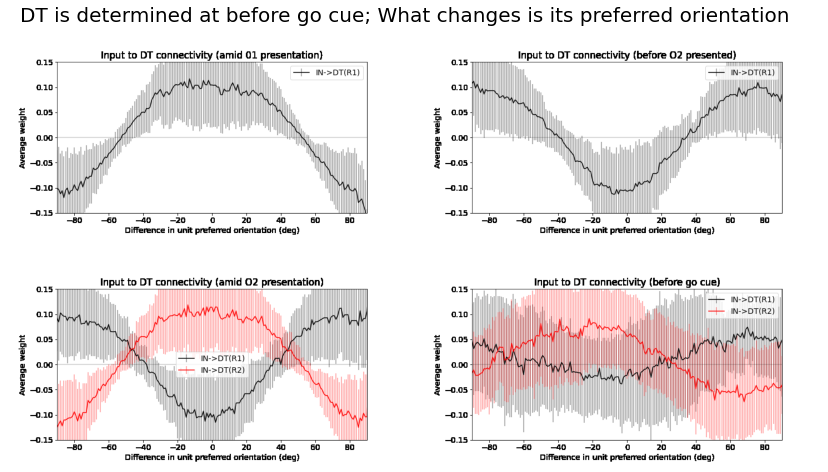

In [81]:
R1_i = megabatch_tuningindices[t5][:R1_ends_at_i]
R2_i = megabatch_tuningindices[t5][R2_starts_from_i:]
imagess = []
for i, x in enumerate([(t1_5, t1_5d), (t3, t3d), (t3_5, t3_5d), (t5, t5d)]):
    timestep, timestep_desc = x
    R1_pref = calc_pref(R1_i, timestep, to=1)
    R2_pref = calc_pref(R2_i, timestep, to=2)
    DT_R1_pref = calc_pref(DT_i, timestep, to=1)
    DT_R2_pref = calc_pref(DT_i, timestep, to=2)

    o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph(R1_i, R1_pref, timestep)
    o2_distances, o2_weights, o2_weights_std = get_connplot_iu_graph(R2_i, R2_pref, timestep)
    dt_o1_distances, dt_o1_weights, dt_o1_weights_std = get_connplot_iu_graph(DT_i, DT_R1_pref, timestep, sm=5)
    dt_o2_distances, dt_o2_weights, dt_o2_weights_std = get_connplot_iu_graph(DT_i, DT_R2_pref, timestep, sm=5)
    fig = plt.figure(figsize=(10, 5))
    markers, caps, bars = plt.errorbar(dt_o1_distances, dt_o1_weights, dt_o1_weights_std, color='k', markersize=10, label="IN->DT(R1)", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    if timestep >= t4-5:
        markers, caps, bars = plt.errorbar(dt_o2_distances, dt_o2_weights, dt_o2_weights_std, color='r', markersize=10, label="IN->DT(R2)", capsize=0)
        [bar.set_alpha(0.4) for bar in bars]
        [cap.set_alpha(0.4) for cap in caps]
    plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
    plt.xlabel('Difference in unit preferred orientation (deg)')
    plt.ylabel('Average weight')
    plt.title(f'Input to DT connectivity ({timestep_desc})')
    plt.legend()
    plt.xlim(-90, 90)
    plt.ylim(-0.15, 0.15)
    imagess.append(plt_to_image(fig))
images_side_by_side(imagess, 
                    save_to=make_saving_path("ring_input_connectivity_1.pdf"), 
                    title="DT is determined at before go cue; What changes is its preferred orientation",
                    figsize=(12, 7))

## Overlap with R1 and R2

findfont: Font family ['Ariel'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ariel'] not found. Falling back to DejaVu Sans.


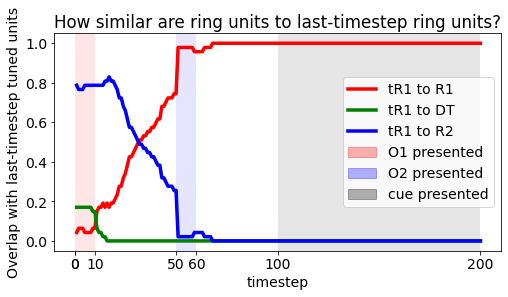

In [13]:
R1_indices = megabatch_tuningindices[:, :R1_ends_at_i]
DT_indices = megabatch_tuningindices[:, R1_ends_at_i:R2_starts_from_i]
R2_indices = megabatch_tuningindices[:, R2_starts_from_i:]
intersection_size_tr1_r1 = [np.intersect1d(R1_indices[-1], R1_indices[t]).shape[0]/R1_indices[-1].shape[0] for t in range(total_time)]
intersection_size_tr1_dt = [np.intersect1d(DT_indices[-1], R1_indices[t]).shape[0]/R1_indices[-1].shape[0] for t in range(total_time)]
intersection_size_tr1_r2 = [np.intersect1d(R2_indices[-1], R1_indices[t]).shape[0]/R1_indices[-1].shape[0] for t in range(total_time)]
intersection_size_r2 = [np.intersect1d(R2_indices[-1], R2_indices[t]).shape[0]/R2_indices[-1].shape[0] for t in range(total_time)]
time = range(1, total_time+1)

font = {'family' : 'Ariel',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

plt.figure(figsize=(8, 4))
plt.plot(time, intersection_size_tr1_r1, "r-", linewidth=3.5, markersize=10, label="tR1 to R1")
plt.plot(time, intersection_size_tr1_dt, "g-", linewidth=3.5, markersize=10, label="tR1 to DT")
plt.plot(time, intersection_size_tr1_r2, "b-", linewidth=3.5, markersize=10, label="tR1 to R2")
#plt.plot(time, intersection_size_r2, "b-", linewidth=3.5, markersize=10, label="R2 units")
plt.xlabel('timestep')
plt.ylabel('Overlap with last-timestep tuned units')
plt.title(f'How similar are ring units to last-timestep ring units?')
plt.legend()
annotate_task_on_plt(plt)
plt.savefig(make_saving_path("R1_similarity.pdf"), bbox_inches='tight')

## PCA

### PCA at all timestamps

In [82]:
from sklearn.decomposition import PCA

R1_i = megabatch_tuningindices[-1][:R1_ends_at_i]
DT_i = megabatch_tuningindices[-1][R1_ends_at_i:R2_starts_from_i]
R2_i = megabatch_tuningindices[-1][R2_starts_from_i:]
R1_pref = calc_pref(R1_i, timestep, to=1)
R2_pref = calc_pref(R2_i, timestep, to=2)

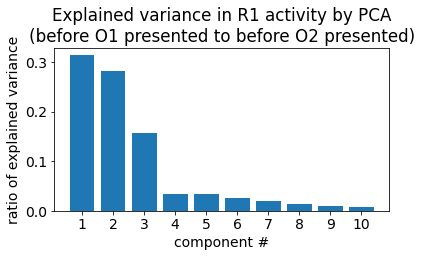

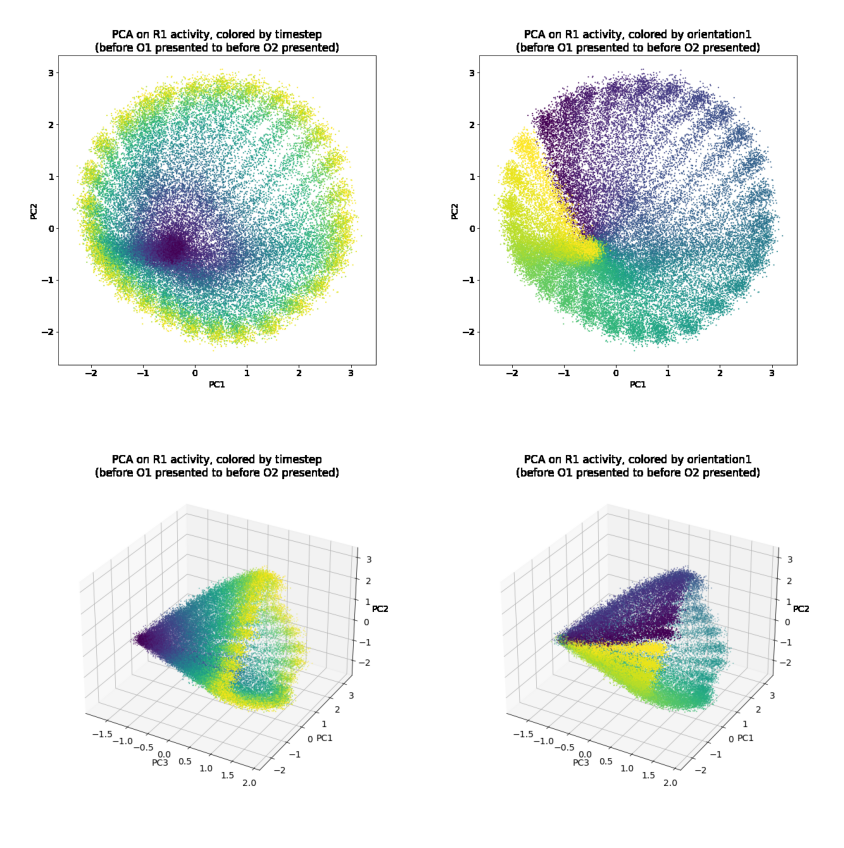

In [83]:
t_from, t_from_d = t1, t1d
t_to, t_to_d = t3, t3d

#timestep_from, timestep_to = 0, 300

indices = torch.cat((R1_i, ))
activity_of = "R1"
                    
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
#arr = arr[:, torch.cat((R1_i, DT_i))]#R2_indices[-1]]
arr = arr[:, indices]#R2_indices[-1]]
arr = arr.cpu().detach().numpy()

pca = PCA(n_components=10, svd_solver='full')
arr_pca = pca.fit_transform(arr)

fig = plt.figure(figsize=(6, 3))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.title(f"Explained variance in {activity_of} activity by PCA\n({t_from_d} to {t_to_d})")
plt.xlabel("component #")
plt.ylabel("ratio of explained variance")
plt.xticks(range(1, len(pca.explained_variance_ratio_)+1))
plt.savefig(make_saving_path(f"pca_{activity_of}_{t_from}to{t_to}_explainedvariance.pdf"), bbox_inches='tight')
plt.show()

arr_pca.shape
res = arr_pca.reshape(180//ORI_RES, 180//ORI_RES, t_to-t_from, 10)
#res = res[:, :, :]
c = [t for o1 in range(res.shape[0]) for o2 in range(res.shape[1]) for t in range(res.shape[2])]
res = res.reshape(-1, 10)
fig = plt.figure(figsize=(9, 9))
#ax = fig.add_subplot()
ax = fig.add_subplot()
#ax.scatter(tsne_result[:len(R1_indices[-1]), 0], tsne_result[:len(R1_indices[-1]), 1], color='r', label="R1 units")
#ax.scatter(tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 0], tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 1], color='g', label="DT units")
#ax.scatter(tsne_result[-len(R2_indices[-1]):, 0], tsne_result[-len(R2_indices[-1]):, 1], color='b', label="R2 units")
ax.scatter(res[:, 0], res[:, 1], c=c, s=1)
#ax.set_xlim(-3, 3)
#ax.set_ylim(-4.5, 5)
#ax.legend()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title(f"PCA on {activity_of} activity, colored by timestep\n({t_from_d} to {t_to_d})")
im1 = plt_to_image(fig)

arr_pca.shape
res = arr_pca.reshape(180//ORI_RES, 180//ORI_RES, t_to-t_from, 10)
res = res[:, :, :]
c = [o1 for o1 in range(res.shape[1]) for o2 in range(res.shape[0]) for t in range(res.shape[2])]
res = res.reshape(-1, 10)
fig = plt.figure(figsize=(9, 9))
#ax = fig.add_subplot()
ax = fig.add_subplot()
#ax.scatter(tsne_result[:len(R1_indices[-1]), 0], tsne_result[:len(R1_indices[-1]), 1], color='r', label="R1 units")
#ax.scatter(tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 0], tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 1], color='g', label="DT units")
#ax.scatter(tsne_result[-len(R2_indices[-1]):, 0], tsne_result[-len(R2_indices[-1]):, 1], color='b', label="R2 units")
ax.scatter(res[:, 0], res[:, 1], c=c, s=1)
#ax.set_xlim(-3, 3)
#ax.set_ylim(-4.5, 5)
#ax.legend()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title(f"PCA on {activity_of} activity, colored by orientation1\n({t_from_d} to {t_to_d})")
im2 = plt_to_image(fig)

arr_pca.shape
res = arr_pca.reshape(180//ORI_RES, 180//ORI_RES, t_to-t_from, 10)
res = res[:, :, :]
c = [t for o1 in range(res.shape[1]) for o2 in range(res.shape[0]) for t in range(res.shape[2])]
res = res.reshape(-1, 10)
fig = plt.figure(figsize=(9, 9))
#ax = fig.add_subplot()
ax = fig.add_subplot(projection='3d')
#ax.scatter(tsne_result[:len(R1_indices[-1]), 0], tsne_result[:len(R1_indices[-1]), 1], color='r', label="R1 units")
#ax.scatter(tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 0], tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 1], color='g', label="DT units")
#ax.scatter(tsne_result[-len(R2_indices[-1]):, 0], tsne_result[-len(R2_indices[-1]):, 1], color='b', label="R2 units")
ax.scatter(res[:, 2], res[:, 0], res[:, 1], c=c, s=1)
#ax.set_xlim(-3, 3)
#ax.set_ylim(-4.5, 5)
#ax.legend()
ax.set_xlabel("PC3")
ax.set_ylabel("PC1")
ax.set_zlabel("PC2")
ax.set_title(f"PCA on {activity_of} activity, colored by timestep\n({t_from_d} to {t_to_d})")
im3 = plt_to_image(fig)

arr_pca.shape
res = arr_pca.reshape(180//ORI_RES, 180//ORI_RES, t_to-t_from, 10)
res = res[:, :, :]
c = [o1 for o1 in range(res.shape[0]) for o2 in range(res.shape[1]) for t in range(res.shape[2])]
res = res.reshape(-1, 10)
fig = plt.figure(figsize=(9, 9))
#ax = fig.add_subplot()
ax = fig.add_subplot(projection='3d')
#ax.scatter(tsne_result[:len(R1_indices[-1]), 0], tsne_result[:len(R1_indices[-1]), 1], color='r', label="R1 units")
#ax.scatter(tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 0], tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 1], color='g', label="DT units")
#ax.scatter(tsne_result[-len(R2_indices[-1]):, 0], tsne_result[-len(R2_indices[-1]):, 1], color='b', label="R2 units")
ax.scatter(res[:, 2], res[:, 0], res[:, 1], c=c, s=1)
#ax.set_xlim(-3, 3)
#ax.set_ylim(-4.5, 5)
#ax.legend()
ax.set_xlabel("PC3")
ax.set_ylabel("PC1")
ax.set_zlabel("PC2")
ax.set_title(f"PCA on {activity_of} activity, colored by orientation1\n({t_from_d} to {t_to_d})")
im4 = plt_to_image(fig)

images_side_by_side((im1, im2, im3, im4), save_to=make_saving_path(f"pca_{activity_of}_{t_from}to{t_to}_plots.pdf"))

### PCA of R1 and R2 at select timestamps

In [84]:
def get_title(timestep):
    if timestep >= hold_orientation_for*2+hold_cue_for+delay0+delay1+delay2:
        return "cue2 presented"
    if timestep >= hold_orientation_for*2+delay0+delay1+delay2:
        return "cue1 presented"
    if timestep >= hold_orientation_for*2+delay0+delay1:
        return "delay2"
    if timestep >= hold_orientation_for+delay0+delay1:
        return "orientation2 presented"
    if timestep >= hold_orientation_for+delay0:
        return "delay1"
    if timestep >= delay0:
        return "orientation1 presented"
    return "delay0"

In [85]:
def _pca_3d(ax, timestep):
    a = timestep
    t = -t1+a
    res = arr_pca.reshape(180//ORI_RES, 180//ORI_RES, t_to-t_from, 10)
    res = res[:, :, t:t+1, :]
    c = [o1 for o1 in range(res.shape[1]) for o2 in range(res.shape[0]) for t in range(res.shape[2])]
    res = res.reshape(-1, 10)
    #ax.scatter(tsne_result[:len(R1_indices[-1]), 0], tsne_result[:len(R1_indices[-1]), 1], color='r', label="R1 units")
    #ax.scatter(tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 0], tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 1], color='g', label="DT units")
    #ax.scatter(tsne_result[-len(R2_indices[-1]):, 0], tsne_result[-len(R2_indices[-1]):, 1], color='b', label="R2 units")
    ax.scatter(res[:, 1], res[:, 0], res[:, 2], c=c, s=10)
    ax.set_xlim(np.min(arr_pca, axis=0)[1], np.max(arr_pca, axis=0)[1])
    ax.set_ylim(np.min(arr_pca, axis=0)[0], np.max(arr_pca, axis=0)[0])
    ax.set_zlim(np.min(arr_pca, axis=0)[2], np.max(arr_pca, axis=0)[2])
    ax.set_xlabel("PC2")
    ax.set_ylabel("PC1")
    ax.set_zlabel("PC3")
    ax.set_title(f"PCA on {activity_of} activity, colored by orientation1\n(PCA {t_from_d} to {t_to_d})"+
                 f"\n(t={get_title(a)})")
def _pca_2d(ax, timestep):
    a = timestep
    t = -t1+a
    res = arr_pca.reshape(180//ORI_RES, 180//ORI_RES, t_to-t_from, 10)
    res = res[:, :, t:t+1, :]
    c = [o1 for o1 in range(res.shape[1]) for o2 in range(res.shape[0]) for t in range(res.shape[2])]
    res = res.reshape(-1, 10)
    #ax.scatter(tsne_result[:len(R1_indices[-1]), 0], tsne_result[:len(R1_indices[-1]), 1], color='r', label="R1 units")
    #ax.scatter(tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 0], tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 1], color='g', label="DT units")
    #ax.scatter(tsne_result[-len(R2_indices[-1]):, 0], tsne_result[-len(R2_indices[-1]):, 1], color='b', label="R2 units")
    ax.scatter(res[:, 0], res[:, 1], c=c, s=20)
    ax.set_xlim(np.min(arr_pca, axis=0)[0], np.max(arr_pca, axis=0)[0])
    ax.set_ylim(np.min(arr_pca, axis=0)[1], np.max(arr_pca, axis=0)[1])
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA on {activity_of} activity, colored by orientation1\n(PCA {t_from_d} to {t_to_d})"+
                 f"\n(t={get_title(a)})")

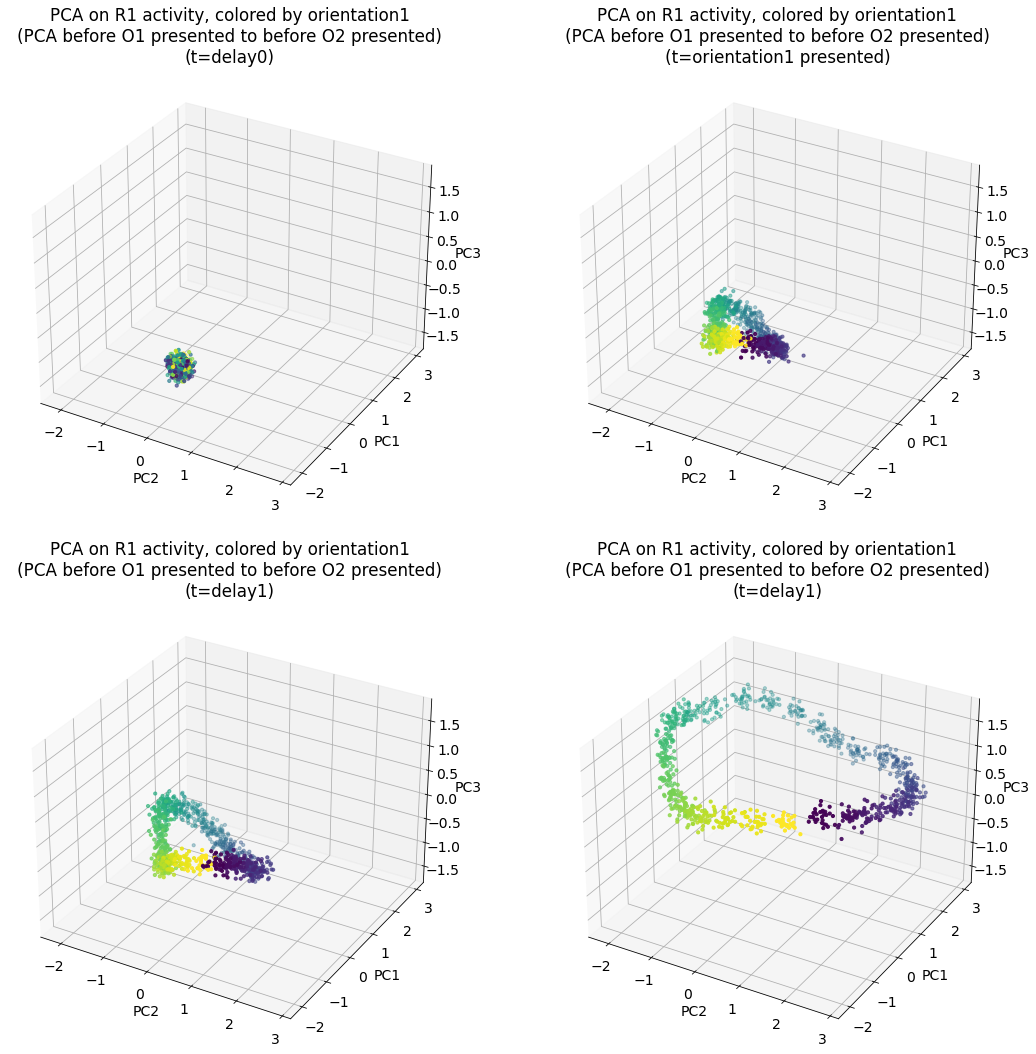

In [86]:
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
plt.close('all')
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(2, 2, 1, projection='3d')
_pca_3d(ax, t1)
ax = fig.add_subplot(2, 2, 2, projection='3d')
_pca_3d(ax, t2)
ax = fig.add_subplot(2, 2, 3, projection='3d')
_pca_3d(ax, t2+7)
ax = fig.add_subplot(2, 2, 4, projection='3d')
_pca_3d(ax, t3-1)
plt.show()

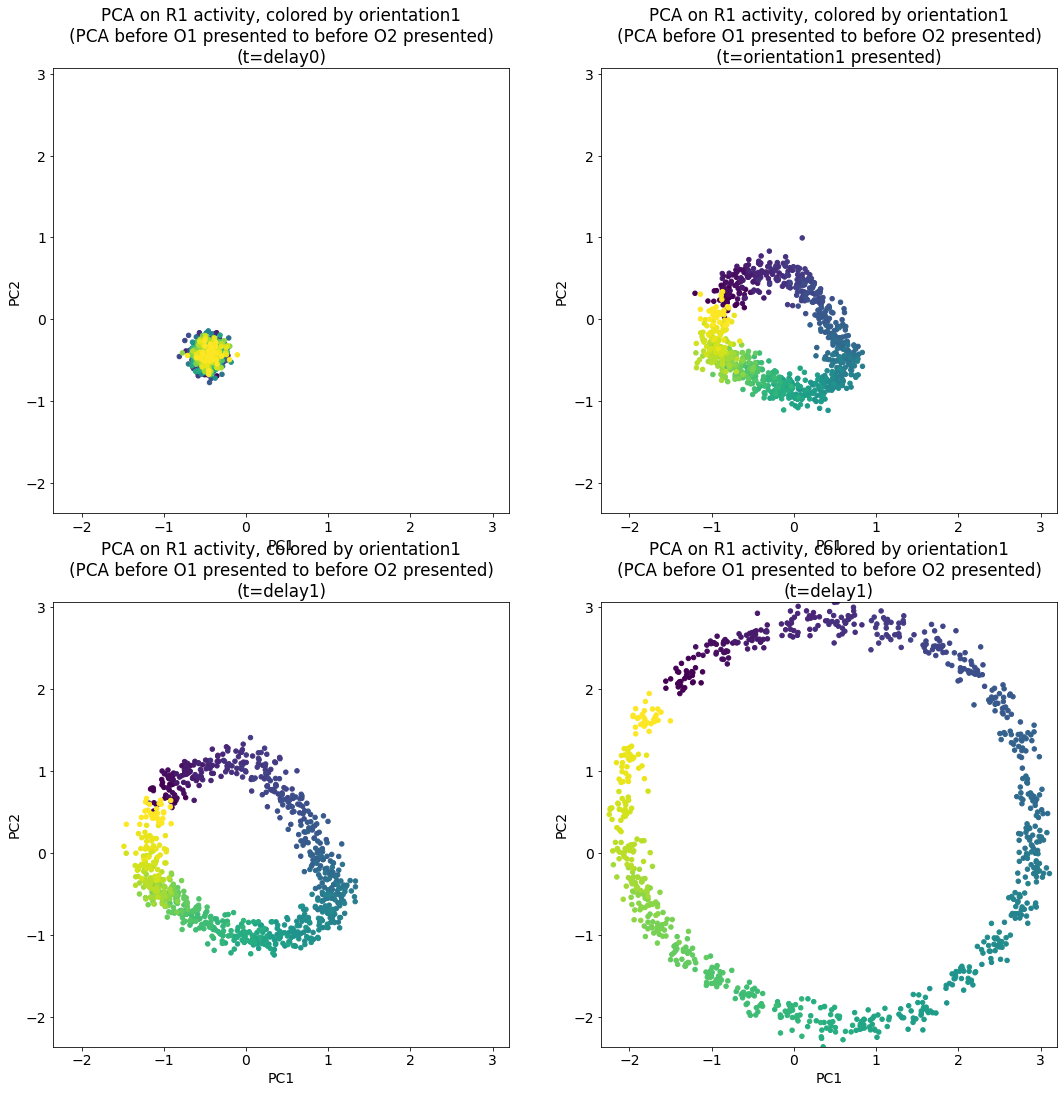

In [88]:
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
plt.close('all')
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(2, 2, 1)
_pca_2d(ax, t1)
ax = fig.add_subplot(2, 2, 2)
_pca_2d(ax, t2)
ax = fig.add_subplot(2, 2, 3)
_pca_2d(ax, t2+7)
ax = fig.add_subplot(2, 2, 4)
_pca_2d(ax, t3-1)
plt.show()

### PCA with reset

In [182]:
resRt = 1
res = resRt**2
timestep = delay0 + hold_orientation_for*2 + delay1 + delay2//2
reset_to=2
units_i=torch.cat((DT_indices[-1], ))
activity_of = "DT"

batch = megabatch_input, megabatch_target, megabatch_mask
sbatch = batch
soutput = megabatch_output[0][::res], megabatch_output[1][::res]
sbatch = batch[0][::res], batch[1][::res], batch[2][::res]
reset_mean = torch.zeros(total_time, dim_recurrent, dtype=int)
reset_mean[:][units_i] = 1
soutput_reset = model._forward(sbatch[0], bhneverlearn=torch.zeros(model.get_noise_shape(sbatch[0])), 
                                   reset_units=reset_mean, reset_to=reset_to)
error = torch.sum((soutput_reset[0][sbatch[2] == 1] - sbatch[1][sbatch[2] == 1]) ** 2, dim=0) / torch.sum(
        sbatch[2] == 1)
#print(error.shape)
error_o1_reset = (error[0]+error[1]).item()
error_o2_reset = (error[2]+error[3]).item()

indices = units_i
                    
arr = soutput_reset[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
#arr = arr[:, torch.cat((R1_i, DT_i))]#R2_indices[-1]]
arr = arr[:, indices]#R2_indices[-1]]
arr = arr.cpu().detach().numpy()
arr_pca = pca.transform(arr)
res = arr_pca.reshape(180//ORI_RES//resRt, 180//ORI_RES//resRt, t_to-t_from, 10)
#res = res[:, :, :]
c = [t for o1 in range(res.shape[0]) for o2 in range(res.shape[1]) for t in range(res.shape[2])]
res = res.reshape(-1, 10)

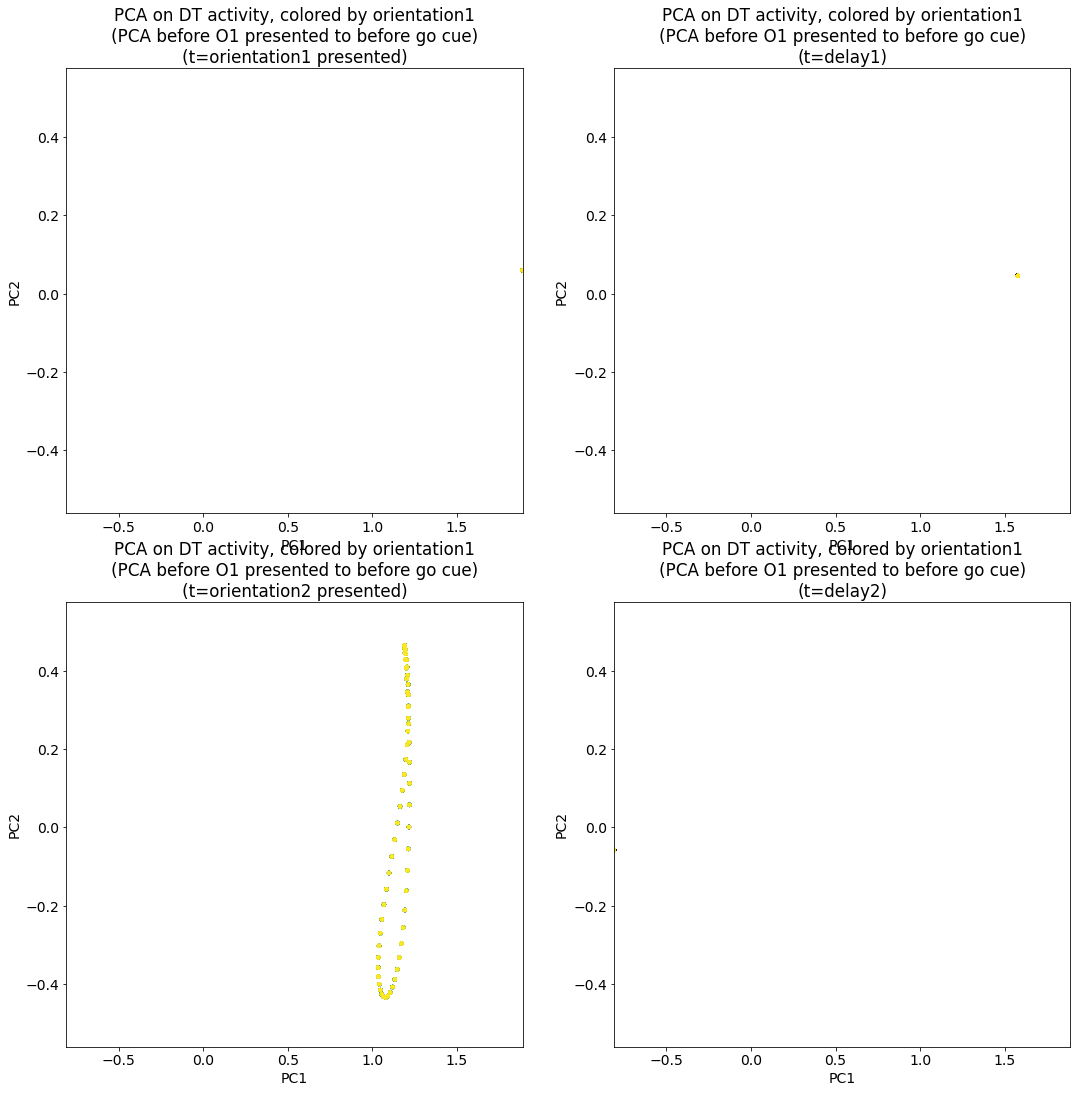

In [183]:
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
plt.close('all')
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(2, 2, 1)
_pca_2d(ax, t2)
ax = fig.add_subplot(2, 2, 2)
_pca_2d(ax, t3)
ax = fig.add_subplot(2, 2, 3)
_pca_2d(ax, t4)
ax = fig.add_subplot(2, 2, 4)
_pca_2d(ax, t5-1)
plt.show()

### Videos of PCA

In [345]:
def get_title(timestep):
    if timestep >= hold_orientation_for*2+hold_cue_for+delay0+delay1+delay2:
        return "cue2 presented"
    if timestep >= hold_orientation_for*2+delay0+delay1+delay2:
        return "cue1 presented"
    if timestep >= hold_orientation_for*2+delay0+delay1:
        return "delay2"
    if timestep >= hold_orientation_for+delay0+delay1:
        return "orientation2 presented"
    if timestep >= hold_orientation_for+delay0:
        return "delay1"
    if timestep >= delay0:
        return "orientation1 presented"
    return "delay0"

0(0.00%) 10(10.10%) 20(20.20%) 30(30.30%) 40(40.40%) 50(50.51%) 60(60.61%) 70(70.71%) 80(80.81%) 90(90.91%) 

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.5 (clang-1205.0.22.9)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enable-videotoolbox
  libavutil      5

0

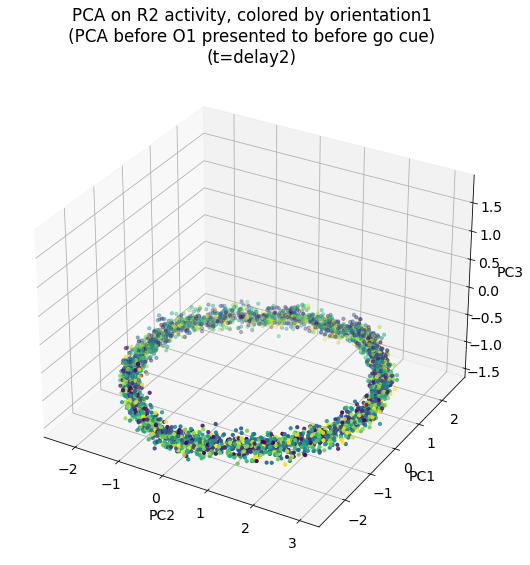

In [346]:
dirname = f"PCA_{activity_of}_fixed"
import pathlib
_path = pathlib.Path(f"{directory}/{index}/{dirname}/file.png")
_path.parent.mkdir(parents=True, exist_ok=True)
for a in range(t_from, t_to):
    res = arr_pca.reshape(180//ORI_RES, 180//ORI_RES, t_to-t_from, 10)
    t = -t1+a
    res = res[:, :, t:t+1, :]
    c = [o1 for o1 in range(res.shape[1]) for o2 in range(res.shape[0]) for t in range(res.shape[2])]
    res = res.reshape(-1, 10)
    plt.close('all')
    fig = plt.figure(figsize=(9, 9))
    #ax = fig.add_subplot()
    ax = fig.add_subplot(projection='3d')
    #ax.scatter(tsne_result[:len(R1_indices[-1]), 0], tsne_result[:len(R1_indices[-1]), 1], color='r', label="R1 units")
    #ax.scatter(tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 0], tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 1], color='g', label="DT units")
    #ax.scatter(tsne_result[-len(R2_indices[-1]):, 0], tsne_result[-len(R2_indices[-1]):, 1], color='b', label="R2 units")
    ax.scatter(res[:, 1], res[:, 0], res[:, 2], c=c, s=10)
    ax.set_xlim(np.min(arr_pca, axis=0)[1], np.max(arr_pca, axis=0)[1])
    ax.set_ylim(np.min(arr_pca, axis=0)[0], np.max(arr_pca, axis=0)[0])
    ax.set_zlim(np.min(arr_pca, axis=0)[2], np.max(arr_pca, axis=0)[2])
    ax.set_xlabel("PC2")
    ax.set_ylabel("PC1")
    ax.set_zlabel("PC3")
    ax.set_title(f"PCA on {activity_of} activity, colored by orientation1\n(PCA {t_from_d} to {t_to_d})"+
                 f"\n(t={get_title(a)})")

    plt.savefig(f"{directory}/{index}/{dirname}/fig{a:03}.png", bbox_inches='tight', dpi=530/fig.get_size_inches()[1])
    if a % 10 == 0: print(f"{t}({(a-t_from)/(t_to-t_from)*100:.2f}%)", end=" ")
os.system(f"ffmpeg -framerate 10 -y -pattern_type glob -i '{directory}/{index}/{dirname}/*.png' -c:v libx264 -pix_fmt yuv420p {directory}/{index}/{dirname}.mp4")

0(0.00%) 10(10.10%) 20(20.20%) 30(30.30%) 40(40.40%) 50(50.51%) 60(60.61%) 70(70.71%) 80(80.81%) 90(90.91%) 

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.5 (clang-1205.0.22.9)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enable-videotoolbox
  libavutil      5

256

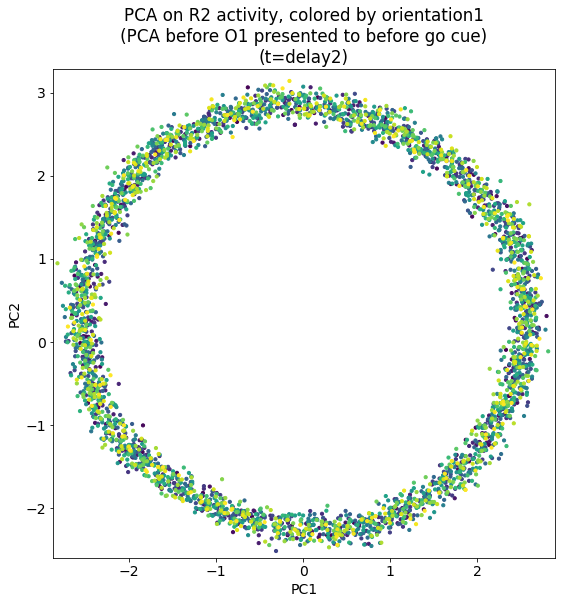

In [347]:
dirname = f"PCA_{activity_of}_2d_fixed"
import pathlib
_path = pathlib.Path(f"{directory}/{index}/{dirname}/file.png")
_path.parent.mkdir(parents=True, exist_ok=True)
for a in range(t_from, t_to):
    res = arr_pca.reshape(180//ORI_RES, 180//ORI_RES, t_to-t_from, 10)
    t = -t1+a
    res = res[:, :, t:t+1, :]
    c = [o1 for o1 in range(res.shape[1]) for o2 in range(res.shape[0]) for t in range(res.shape[2])]
    res = res.reshape(-1, 10)
    plt.close('all')
    fig = plt.figure(figsize=(9, 9))
    #ax = fig.add_subplot()
    ax = fig.add_subplot()
    #ax.scatter(tsne_result[:len(R1_indices[-1]), 0], tsne_result[:len(R1_indices[-1]), 1], color='r', label="R1 units")
    #ax.scatter(tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 0], tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 1], color='g', label="DT units")
    #ax.scatter(tsne_result[-len(R2_indices[-1]):, 0], tsne_result[-len(R2_indices[-1]):, 1], color='b', label="R2 units")
    ax.scatter(res[:, 0], res[:, 1], c=c, s=10)
    ax.set_xlim(np.min(arr_pca, axis=0)[0], np.max(arr_pca, axis=0)[0])
    ax.set_ylim(np.min(arr_pca, axis=0)[1], np.max(arr_pca, axis=0)[1])
    #ax.set_zlim(np.min(arr_pca, axis=0)[2], np.max(arr_pca, axis=0)[2])
    #ax.legend()
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA on {activity_of} activity, colored by orientation1\n(PCA {t_from_d} to {t_to_d})"+
                 f"\n(t={get_title(a)})")

    plt.savefig(f"{directory}/{index}/{dirname}/fig{a:03}.png", bbox_inches='tight', dpi=531//fig.get_size_inches()[1]*2)
    if a % 10 == 0: print(f"{t}({(a-t_from)/(t_to-t_from)*100:.2f}%)", end=" ")
os.system(f"ffmpeg -framerate 10 -y -pattern_type glob -i '{directory}/{index}/{dirname}/*.png' -c:v libx264 -pix_fmt yuv420p {directory}/{index}/{dirname}.mp4")

## Inputs to various R1 units

In [140]:
timestep_sort = t1_5
timestep_sort_description = t4d
R1_i = megabatch_tuningindices[-1][:R1_ends_at_i]
R2_i = megabatch_tuningindices[-1][R2_starts_from_i:]
R1_pref = calc_pref(R1_i, t6, to=1)
R2_pref = calc_pref(R2_i, t6, to=2)
##sort units within R1 and R2 by preferred angle
R1_i = R1_i.clone()[torch.argsort(R1_pref)]
#R1_pref = R1_pref.clone()[torch.argsort(R1_pref)]
R2_i = R2_i.clone()[torch.argsort(R2_pref)]
#R2_pref = R2_pref.clone()[torch.argsort(R2_pref)]
R1_pref = calc_pref(R1_i, t6, to=1)
R2_pref = calc_pref(R2_i, t6, to=2)

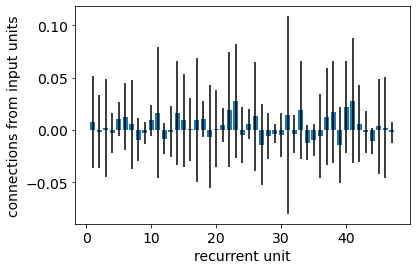

In [141]:
mean = torch.mean(model.fc_x2ah.weight[R1_i, :-1], dim=1).detach().numpy()
std = torch.std(model.fc_x2ah.weight[R1_i, :-1], dim=1).detach().numpy()
plt.bar(range(1, len(mean)+1), mean, yerr=std)
plt.xlabel("recurrent unit")
plt.ylabel("connections from input units")
plt.show()

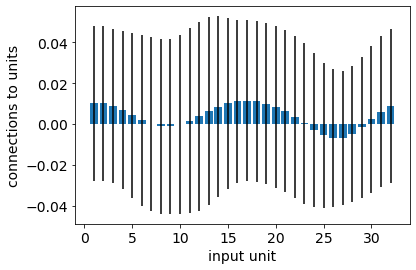

In [142]:
mean = torch.mean(model.fc_x2ah.weight[R1_i, :-1], dim=0).detach().numpy()
std = torch.std(model.fc_x2ah.weight[R1_i, :-1], dim=0).detach().numpy()
plt.bar(range(1, len(mean)+1), mean, yerr=std)
plt.xlabel("input unit")
plt.ylabel("connections to units")
plt.show()

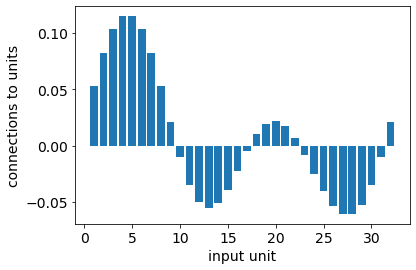

In [143]:
mean = model.fc_x2ah.weight[R2_i[5], :-1].detach().numpy()
#std = torch.std(model.fc_x2ah.weight[R1_i, :-1], dim=0).detach().numpy()
plt.bar(range(1, len(mean)+1), mean)#, yerr=std)
plt.xlabel("input unit")
plt.ylabel("connections to units")
plt.show()

In [144]:
def get_unit_input_conn(unit_ids, unit_label):
    plt.close('all')
    
    n = len(unit_ids)
    sqt = math.ceil(n ** 0.5)
    fig, ax = plt.subplots(nrows=math.ceil(n/sqt), ncols=sqt, figsize=(16, 16))
    for a in ax.ravel():
        a.title.set_visible(False)
        a.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
        #a.axis('off')
    for i in range(n):
        a = ax[i // sqt][i % sqt]
        m = torch.max((model.fc_x2ah.weight[unit_ids, :-1])).item()
        #m = torch.max(torch.abs(model.fc_x2ah.weight[:, :-1])).item()
        #m=0.26
        a.set_ylim(-m, m)
        mean = model.fc_x2ah.weight[unit_ids[i], :-1].detach().numpy()+model.fc_x2ah.bias[unit_ids[i]].detach().numpy()/32
        a.bar(range(1, len(mean)+1), (mean))#, yerr=std)
        a.axhline(y = 0.0, color = 'r', linestyle = '--', linewidth=0.5)
        #uncomment to see which unit has which id
        #a.title.set_visible(True)
        #a.set_title(sor_i[i])
    plt.tight_layout()
    st = fig.suptitle(f"Connectivity from input to {unit_label} units", fontsize=24)
    fig.supxlabel('input unit #', fontsize=20)
    fig.supylabel(f'weight to recurrent unit (-{m:.2f}, {m:.2f})', fontsize=20)
    fig.subplots_adjust(top=0.95, left=0.04, bottom=0.04)
    return fig

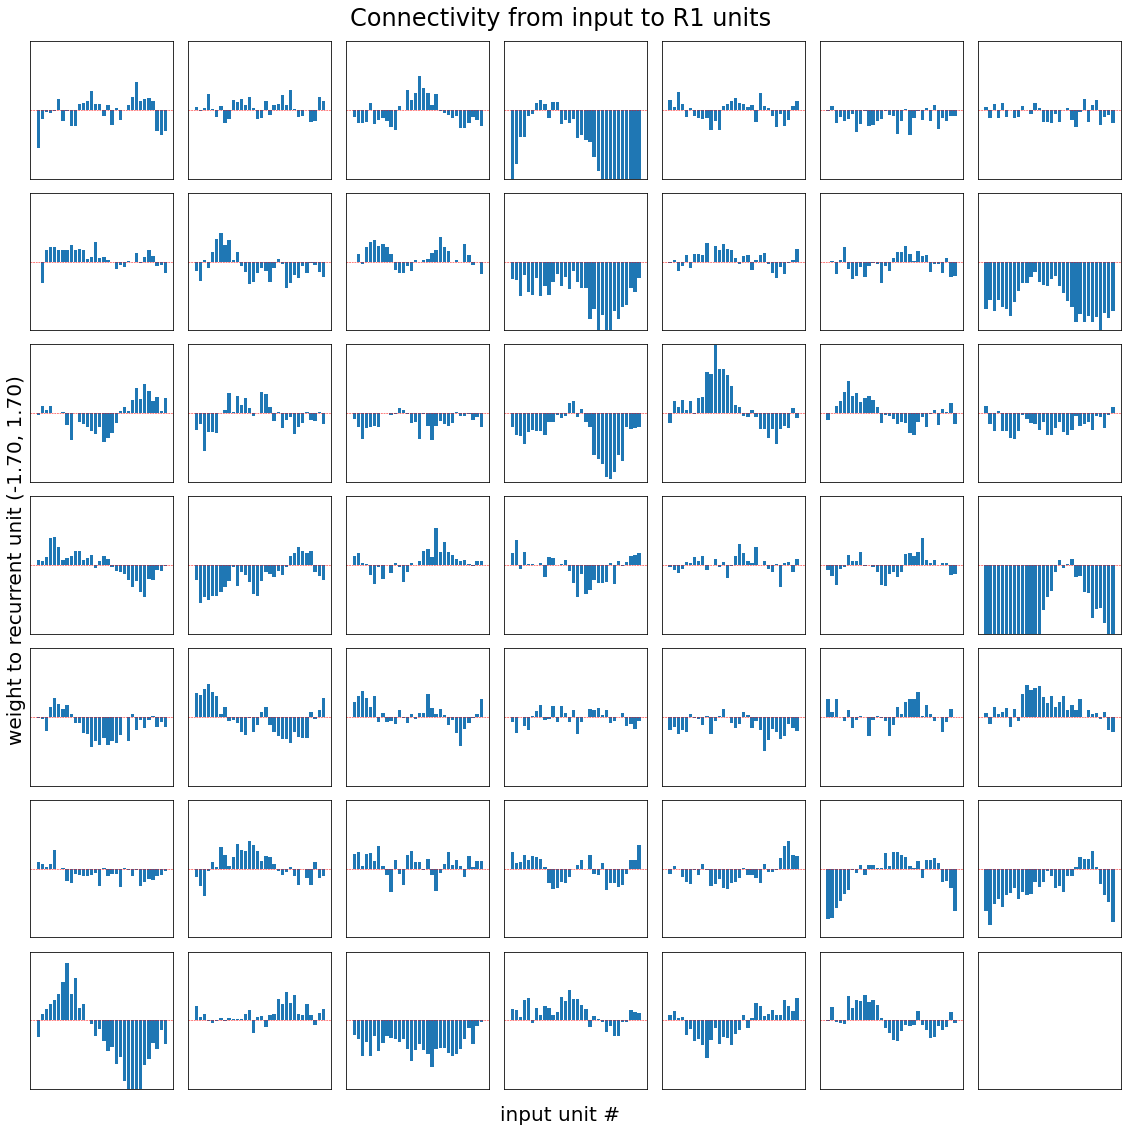

In [134]:
#get_unit_input_conn(R1_i[torch.argsort(torch.max(torch.abs(model.fc_x2ah.weight[R1_i, :-1]), dim=1).values)], "R1")
get_unit_input_conn(R1_i, "R1")
None

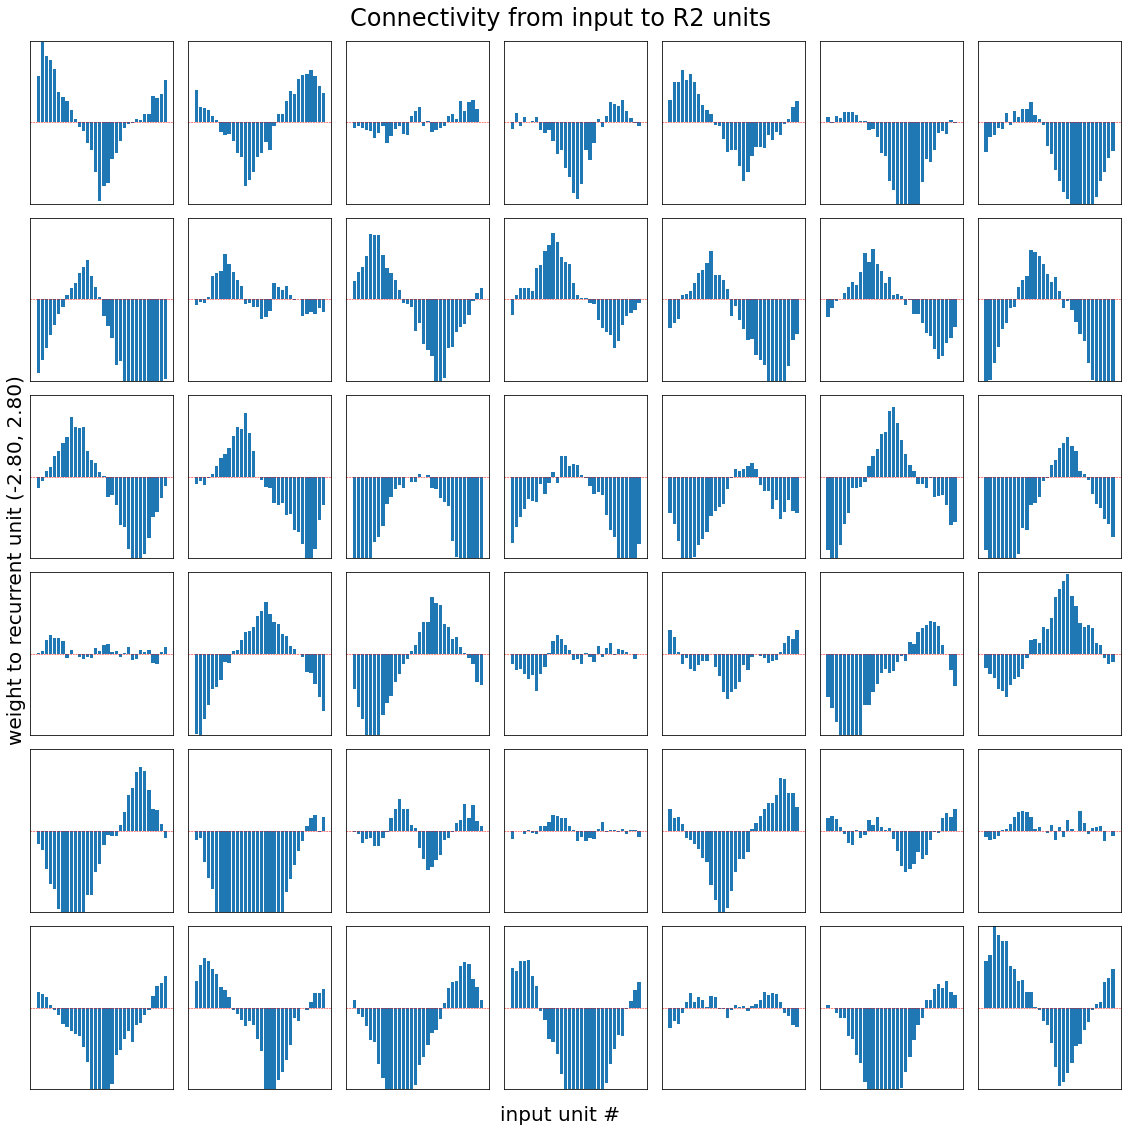

In [135]:
#get_unit_input_conn(R2_i[torch.argsort(torch.max(torch.abs(model.fc_x2ah.weight[R2_i, :-1]), dim=1).values)], "R2")
get_unit_input_conn(R2_i, "R2")
None

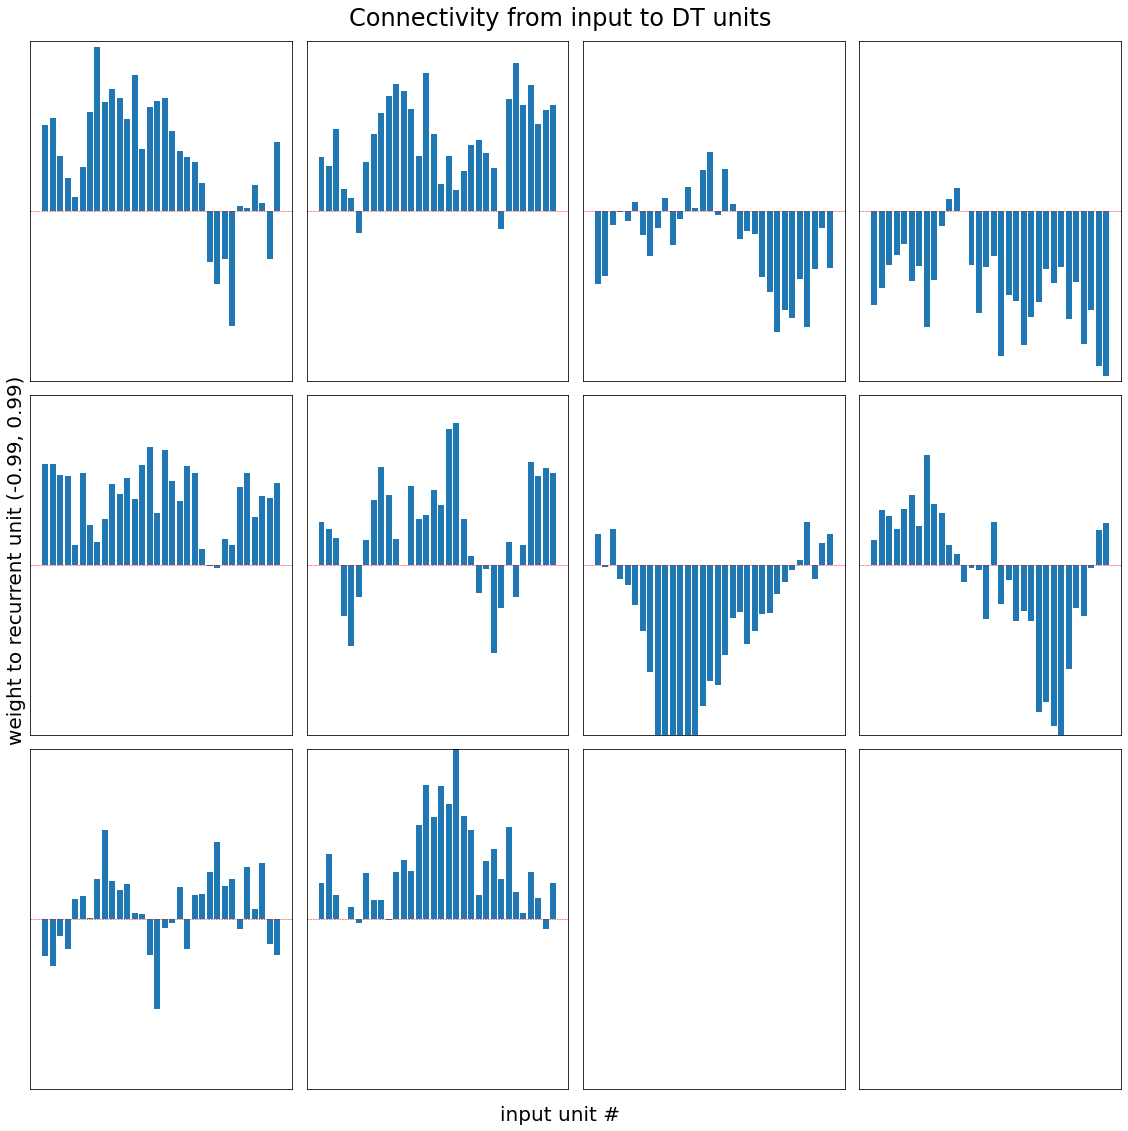

In [136]:
get_unit_input_conn(DT_i, "DT")
None

In [118]:
get_unit_input_conn(megabatch_tuningindices[t4], "ALL")
None

NameError: name 'get_unit_input_conn' is not defined

In [145]:
torch.max(model.fc_x2ah.weight[R2_i, :-1], dim=1).indices * 180 / 32

tensor([  0.0000, 101.2500, 174.3750,  39.3750,  11.2500,  22.5000,  33.7500,
         50.6250,  16.8750,  61.8750,  33.7500,  67.5000,  50.6250,  73.1250,
         67.5000,  78.7500,  84.3750,  84.3750, 101.2500,  84.3750,  61.8750,
        106.8750, 101.2500, 101.2500,  84.3750, 118.1250, 123.7500, 101.2500,
         45.0000, 135.0000, 174.3750, 146.2500, 157.5000, 118.1250, 157.5000,
         16.8750, 129.3750, 140.6250, 168.7500, 168.7500, 151.8750])

In [146]:
R2_pref

tensor([  6.,   7.,   9.,  16.,  19.,  21.,  26.,  29.,  33.,  39.,  39.,  45.,
         50.,  59.,  60.,  67.,  75.,  79.,  79.,  86.,  88.,  95., 105., 105.,
        105., 116., 126., 128., 137., 138., 140., 148., 148., 151., 156., 160.,
        160., 167., 172., 174., 176.], dtype=torch.float64)

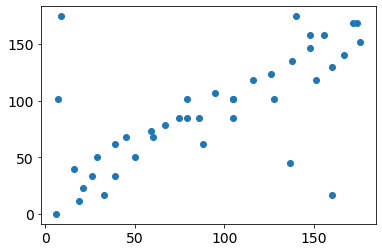

In [147]:
plt.scatter(R2_pref, torch.max(model.fc_x2ah.weight[R2_i, :-1], dim=1).indices * 180 / 32)

In [148]:
model.fc_x2ah.weight[R2_i, :-1].shape

torch.Size([41, 32])

In [149]:
np.angle(np.exp(1j*(np.arange(32)/32*2*np.pi))) * 180 / np.pi / 2

array([  0.   ,   5.625,  11.25 ,  16.875,  22.5  ,  28.125,  33.75 ,
        39.375,  45.   ,  50.625,  56.25 ,  61.875,  67.5  ,  73.125,
        78.75 ,  84.375,  90.   , -84.375, -78.75 , -73.125, -67.5  ,
       -61.875, -56.25 , -50.625, -45.   , -39.375, -33.75 , -28.125,
       -22.5  , -16.875, -11.25 ,  -5.625])

In [150]:
w = model.fc_x2ah.weight[R2_i, :-1].detach().numpy()
a = np.angle(np.sum(w*np.exp(1j*(np.arange(32)/32*2*np.pi)).reshape(1, -1), axis=1)/np.sum(np.abs(w), axis=1)) * 180 / np.pi / 2
a[a<0] = a[a<0]+180
a

array([1.74305862e+00, 9.98383771e+01, 3.21584829e-02, 1.97104100e+01,
       1.31990247e+01, 2.23859544e+01, 3.15243757e+01, 3.61526163e+01,
       2.84267931e+01, 4.21533093e+01, 3.85454395e+01, 5.25336292e+01,
       4.88461283e+01, 7.06897858e+01, 5.59191236e+01, 6.34052006e+01,
       7.86622299e+01, 8.46765736e+01, 8.49026622e+01, 8.39936321e+01,
       7.74534448e+01, 1.03596424e+02, 9.95202534e+01, 1.02356025e+02,
       1.07081003e+02, 1.17322047e+02, 1.27163852e+02, 1.29897666e+02,
       4.93541432e+01, 1.37514847e+02, 1.61924038e+02, 1.43878106e+02,
       1.49531904e+02, 1.27308493e+02, 1.55002184e+02, 1.89680232e+01,
       1.47116664e+02, 1.68387414e+02, 1.69188841e+02, 1.68292842e+02,
       1.71967196e+02])

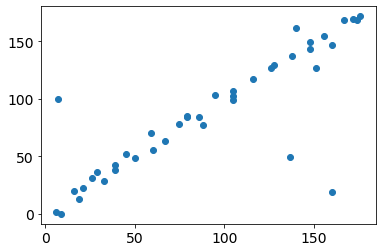

In [151]:
plt.scatter(R2_pref, a)

In [145]:
b = torch.abs(R2_pref-a)
b[b>90] = torch.abs(b[b>90]-180)
b

tensor([ 4.8794, 30.1039, 53.7821, 28.3499,  6.1250, 10.6540,  6.5877, 18.5520,
         5.9631, 14.6215, 11.3890,  1.0018,  3.6524, 14.9357, 13.2771,  9.5414,
         2.6896, 11.1056, 12.4919, 14.2172,  2.5607, 87.1495, 28.1254, 14.8228,
        22.1286, 31.9275, 15.8726, 33.0361,  6.3611, 13.0767, 41.6709, 80.2357,
         0.0916, 38.7175, 86.9837, 14.1603, 29.2451, 14.8868, 16.2913, 80.8524,
         8.2885, 24.4823], dtype=torch.float64)

In [98]:
torch.std((model.fc_h2ah.weight[R2_i, R2_i[0]]))

tensor(0.0771, grad_fn=<StdBackward0>)

In [99]:
torch.std((model.fc_h2ah.weight[R2_i, :][:, R2_i]))

tensor(0.1118, grad_fn=<StdBackward0>)

<BarContainer object of 48 artists>

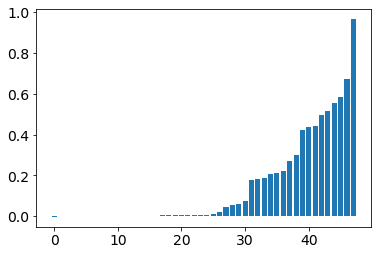

In [162]:
unit_ids=megabatch_tuningindices[t6]
unit_ids=R1_i

R1_i = megabatch_tuningindices[t6][:R1_ends_at_i]
R2_i = megabatch_tuningindices[t6][R2_starts_from_i:]
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[t6][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[t6][R2_i], dim=1), dim=1)*ORI_RES
#sort units within R1 and R2 by preferred angle
R1_i = R1_i.clone()[torch.argsort(R1_pref)]
R1_pref = R1_pref.clone()[torch.argsort(R1_pref)]
R2_i = R2_i.clone()[torch.argsort(R2_pref)]
R2_pref = R2_pref.clone()[torch.argsort(R2_pref)]
unit_ids=R1_i
#unit_ids = megabatch_tuningindices[t6][:R1_ends_at_i]

plt.bar(range(len(unit_ids)), sorted(torch.max((model.fc_x2ah.weight[unit_ids, :-1]), dim=1).values.detach().numpy()))

<BarContainer object of 22 artists>

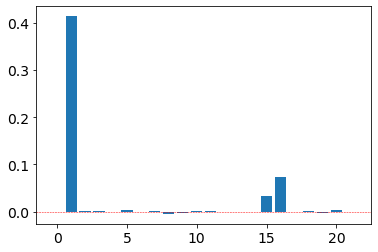

In [143]:
unit_ids = R1_i
m = model.fc_x2ah.weight[unit_ids, :-1]
m = m[torch.max(torch.abs(model.fc_x2ah.weight[unit_ids, :-1]), dim=1).values>0.1, :]
m = torch.argmax(m, dim=1)*180/32

m = model.fc_x2ah.weight[unit_ids[torch.sort(m).indices], 4]#+model.fc_x2ah.bias[unit_ids[torch.sort(m).indices]]/32
plt.axhline(y = 0.0, color = 'r', linestyle = '--', linewidth=0.5)

plt.bar(range(len(m)), m.detach().numpy())

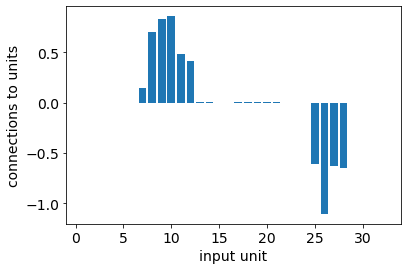

In [144]:
mean = model.fc_x2ah.weight[R2_i[5], :-1].detach().numpy()
#std = torch.std(model.fc_x2ah.weight[R1_i, :-1], dim=0).detach().numpy()
plt.bar(range(1, len(mean)+1), mean)#, yerr=std)
plt.xlabel("input unit")
plt.ylabel("connections to units")
plt.show()

## Pref change

### 1

In [197]:
timestep_sort = t2
timestep_sort_description = t2d
R1_i = megabatch_tuningindices[t6][:R1_ends_at_i]
R2_i = megabatch_tuningindices[t6][R2_starts_from_i:]
R1_pref = calc_pref(R1_i, timestep_sort, to=1)
R2_pref = calc_pref(R2_i, timestep_sort, to=2)
R2_O1_pref = calc_pref(R2_i, timestep_sort, to=1)
#sort units within R1 and R2 by preferred angle
R1_i = R1_i.clone()[torch.argsort(R1_pref)]
R1_pref = R1_pref.clone()[torch.argsort(R1_pref)]
R2_i = R2_i.clone()[torch.argsort(R2_O1_pref)]
R2_pref = R2_pref.clone()[torch.argsort(R2_pref)]
R1_pref = calc_pref(R1_i, timestep_sort, to=1)
R2_pref = calc_pref(R2_i, timestep_sort, to=2)
R1_pref

tensor([  5.,   6.,  14.,  15.,  15.,  21.,  24.,  26.,  29.,  32.,  33.,  34.,
         40.,  48.,  52.,  55.,  57.,  59.,  63.,  65.,  79.,  82.,  83.,  86.,
         88.,  88.,  91.,  96.,  99., 101., 102., 105., 110., 111., 117., 124.,
        125., 126., 131., 145., 146., 148., 149., 154., 170., 171., 177.],
       dtype=torch.float64)

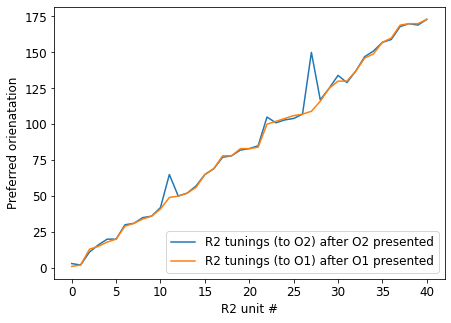

In [198]:
plt.figure(figsize=(7, 5))
plt.plot(calc_pref(R2_i, t4, to=2), label=f"R2 tunings (to O2) {t4d}")
plt.plot(calc_pref(R2_i, t2, to=1), label=f"R2 tunings (to O1) {t2d}")
#plt.plot(torch.argmax(torch.sum(megabatch_tuningdata[t1_5][R2_i], dim=2), dim=1)*ORI_RES, label=f"R2 tunings (to O1) {t1_5d}")
plt.xlabel("R2 unit #")
plt.ylabel("Preferred orienatation")
plt.legend()

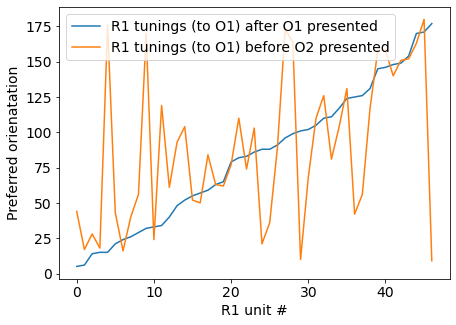

In [107]:
plt.figure(figsize=(7, 5))
plt.plot(calc_pref(R1_i, t2, to=1), label=f"R1 tunings (to O1) {t2d}")
plt.plot(calc_pref(R1_i, t3, to=1), label=f"R1 tunings (to O1) {t3d}")
#plt.plot(calc_pref(R1_i, t2, to=1), label=f"R1 tunings (to O1) {t2d}")
plt.xlabel("R1 unit #")
plt.ylabel("Preferred orienatation")
plt.legend()
#plt.plot(sorted(torch.argmax(torch.sum(megabatch_tuningdata[t2][R1_i], dim=2), dim=1)*ORI_RES))

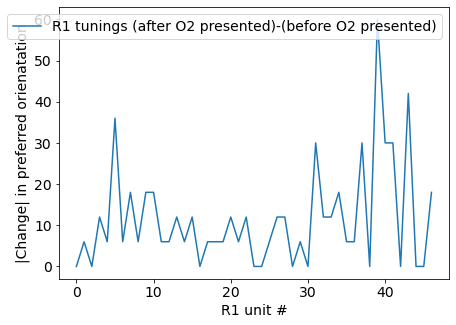

In [108]:
a = torch.argmax(torch.sum(megabatch_tuningdata[t4][R1_i], dim=2), dim=1)*ORI_RES
b = torch.argmax(torch.sum(megabatch_tuningdata[t3][R1_i], dim=2), dim=1)*ORI_RES
c = a - b
c = torch.minimum(torch.abs(c), 180-torch.abs(c))
for i in range(len(c)):
    #if c[i] > 90: c[i] = c[i]-180
    #if c[i] < -90: c[i] = c[i]+180
    pass
plt.figure(figsize=(7, 5))
plt.plot(c, label=f"R1 tunings ({t4d})-({t3d})")
#plt.plot(bS, label=f"R1 tunings (to O1) {t3d}")
#plt.plot(torch.argmax(torch.sum(megabatch_tuningdata[t1_5][R1_i], dim=2), dim=1)*ORI_RES, label=f"R1 tunings (to O1) {t1_5d}")
plt.xlabel("R1 unit #")
plt.ylabel("|Change| in preferred orienatation")
plt.legend()
#plt.plot(sorted(torch.argmax(torch.sum(megabatch_tuningdata[t2][R1_i], dim=2), dim=1)*ORI_RES))

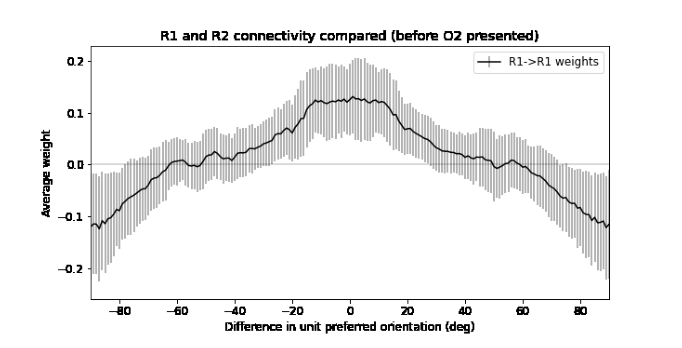

In [188]:
#get_connplot_graph(timestep, R1_i=None, R2_i=None, R1_pref=None, R2_pref=None, cc_smoothing=True)
timestep, timestep_desc = t3, t3d
r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std = get_connplot_graph(timestep, R1_i=R1_i, 
    R1_pref=calc_pref(R1_i, t3, to=1))

fig = plt.figure(figsize=(10, 5))
markers, caps, bars = plt.errorbar(r1_distances, r1_weights, r1_weights_std, color='k', markersize=10, label="R1->R1 weights", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
#markers, caps, bars = plt.errorbar(r2_distances, r2_weights, r2_weights_std, color='r', markersize=10, label="R2->R2 weights", capsize=0)
#[bar.set_alpha(0.4) for bar in bars]
#[cap.set_alpha(0.4) for cap in caps]
plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
plt.xlabel('Difference in unit preferred orientation (deg)')
plt.ylabel('Average weight')
plt.title(f'R1 and R2 connectivity compared ({timestep_desc})')
plt.legend()
plt.xlim(-90, 90)
images_side_by_side((plt_to_image(fig),), figsize=(10, 5), 
                    save_to=make_saving_path("ring_connectivity.pdf"))

### 2

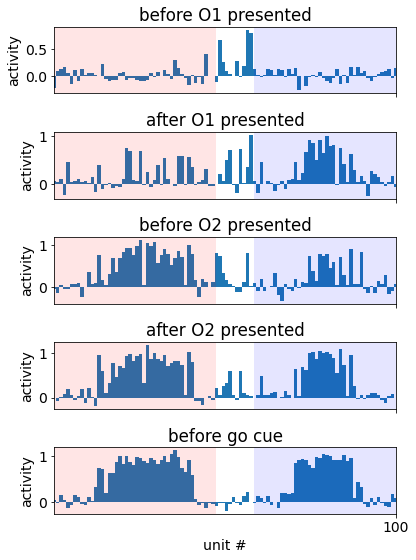

In [158]:
timesteps = {t1-1:t1d, t2:t2d, t3:t3d, t4:t4d, t5:t5d}
indices = torch.cat((R1_i, DT_i, R2_i))
o1, o2 = 90, 90
o1, o2 = o1//ORI_RES, o2//ORI_RES
out = megabatch_output[1].reshape(180//ORI_RES, 180//ORI_RES, total_time, dim_recurrent)[:, :, :, indices]
fig = plt.figure(figsize=(6, 8))
N = len(timesteps.items())
for i in range(N):
    t, t_d = list(timesteps.items())[i]
    ax = fig.add_subplot(N, 1, i+1)
    ax.bar(range(1, len(indices)+1), out[o1, o2, t, :].detach().numpy(), 1)
    ax.set_xlabel("unit #")
    ax.set_ylabel(f"activity")
    ax.set_xticks([0, R1_ends_at_i, R2_starts_from_i, 100])
    ax.set_xticks([0, 100])
    ax.set_title(f"{t_d}")
    ax.axvspan(0, R1_ends_at_i+1, facecolor="r", alpha=0.1)
    ax.axvspan(R2_starts_from_i, 100, facecolor="b", alpha=0.1)
    ax.set_xlim(1, 100)
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in fig.axes:
    ax.label_outer()
plt.tight_layout()
plt.show()

### Unit preference over time

In [159]:
pref_of_unit_at = torch.zeros(dim_recurrent, total_time)
fav_of_unit_at = torch.zeros(dim_recurrent, total_time)
mean_activity_of_unit_at = torch.zeros(dim_recurrent, total_time)
for i in range(dim_recurrent):
    for t in range(total_time):
        if torch.std(torch.sum(megabatch_tuningdata[t][i], dim=1), dim=0) > torch.std(torch.sum(megabatch_tuningdata[t][i], dim=0), dim=0):
            # unit prefers O1 at this point
            pref = calc_pref([i], t, to=1)[0].item()
            fav_of_unit_at[i, t] = 1
        else:
            pref = calc_pref([i], t, to=2)[0].item()
            fav_of_unit_at[i, t] = 2
        pref_of_unit_at[i, t] = pref
        mean_activity_of_unit_at[i, t] = torch.mean(megabatch_tuningdata[t][i])
mean_activity_of_unit_at = mean_activity_of_unit_at.detach().numpy()

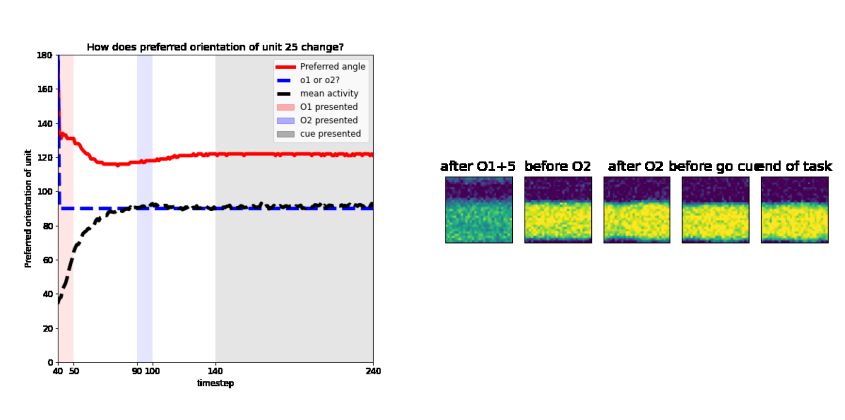

In [186]:
time = range(1, total_time+1)

font = {'family' : 'Ariel',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

#i = 100-5
#i = 100-14
#i = 17
#i = 12 #dead unit
#i = 13 semi dead unit
#i = 60 #1 bitok
#i = 89
#i=100-3 #two changes
#i=100-13 #two changes
#i = 17
i = 25
           
timesteps = {t2+5:"after O1+5", t3:"before O2", t4:"after O2", t5:"before go cue", t6:"end of task"}
fig = plt.figure(figsize=(6, 6))
N = len(timesteps.items())
for j in range(5):
    t, t_d = list(timesteps.items())[j]
    ax = fig.add_subplot(1, 5, j+1)
    ax.imshow(megabatch_tuningdata[t][tuning_indices[-1][i]].detach().numpy(), vmin=0, vmax=1)
    ax.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
    ax.set_title(t_d)
plt.tight_layout()
img2 = plt_to_image(fig)

fig = plt.figure(figsize=(8, 8))
plt.plot(time, pref_of_unit_at[tuning_indices[-1][i]], "r-", linewidth=5, markersize=10, label="Preferred angle")
plt.plot(time, fav_of_unit_at[tuning_indices[-1][i]]*90, "b--", linewidth=5, markersize=10, label="o1 or o2?")
plt.plot(time, mean_activity_of_unit_at[tuning_indices[-1][i]]*180, "k--", linewidth=5, markersize=10, label="mean activity")
plt.xlabel('timestep')
plt.ylabel('Preferred orientation of unit')
plt.title(f'How does preferred orientation of unit {i} change?')
plt.legend()
plt.ylim(0, 180)
annotate_task_on_plt(plt)
plt.xlim(delay0, total_time)
img1 = plt_to_image(fig)

images_side_by_side((img1, img2), vert_pref=False)

In [75]:
dirname = f"prefchanges"
import pathlib
_path = pathlib.Path(f"{directory}/{index}/{dirname}/file.png")

## Activity over time

(0.0, 1.0)

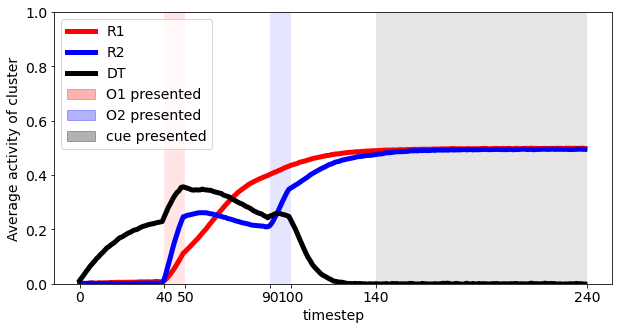

In [110]:
#plt.plot()
time = range(total_time)
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(10, 5))

R1_f_i = R1_i[torch.argsort(torch.max(torch.abs(model.fc_x2ah.weight[R1_i, :-1]), dim=1).values)][:len(R1_i)//2]
R1_s_i = R1_i[torch.argsort(torch.max(torch.abs(model.fc_x2ah.weight[R1_i, :-1]), dim=1).values)][len(R1_i)//2:]
R2_f_i = R2_i[torch.argsort(torch.max(torch.abs(model.fc_x2ah.weight[R2_i, :-1]), dim=1).values)][:len(R2_i)//2]
R2_s_i = R2_i[torch.argsort(torch.max(torch.abs(model.fc_x2ah.weight[R2_i, :-1]), dim=1).values)][len(R2_i)//2:]

plt.plot(time, torch.mean(megabatch_output[1][:, :, R1_i], dim=[0, 2]).detach().numpy(), "r-", linewidth=5, markersize=10, label="R1")
#plt.plot(time, torch.mean(megabatch_output[1][:, :, R1_f_i], dim=[0, 2]).detach().numpy(), "y--", linewidth=5, markersize=10, label="R1(f)")
#plt.plot(time, torch.mean(megabatch_output[1][:, :, R1_s_i], dim=[0, 2]).detach().numpy(), "y--", linewidth=5, markersize=10, label="R1(s)")
plt.plot(time, torch.mean(megabatch_output[1][:, :, R2_i], dim=[0, 2]).detach().numpy(), "b-", linewidth=5, markersize=10, label="R2")
#plt.plot(time, torch.mean(megabatch_output[1][:, :, R2_f_i], dim=[0, 2]).detach().numpy(), "p--", linewidth=5, markersize=10, label="R2(f)")
#plt.plot(time, torch.mean(megabatch_output[1][:, :, R2_s_i], dim=[0, 2]).detach().numpy(), "p--", linewidth=5, markersize=10, label="R2(s)")
plt.plot(time, torch.mean(megabatch_output[1][:, :, DT_i], dim=[0, 2]).detach().numpy(), "k-", linewidth=5, markersize=10, label="DT")
plt.xlabel('timestep')
plt.ylabel('Average activity of cluster')
#plt.title(f'How does preferred orientation of unit {i} change?')
plt.legend()
#plt.ylim(0, 180)
annotate_task_on_plt(plt)
plt.ylim(0, 1)
#plt.xlim(delay0, total_time)
#img1 = plt_to_image(fig)


## Input->R1 experiments

Remember PCA for R1

In [14]:
from sklearn.decomposition import PCA

R1_i = megabatch_tuningindices[-1][:R1_ends_at_i]
DT_i = megabatch_tuningindices[-1][R1_ends_at_i:R2_starts_from_i]
R2_i = megabatch_tuningindices[-1][R2_starts_from_i:]
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[-1][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[-1][R2_i], dim=1), dim=1)*ORI_RES

t_from, t_from_d = t1, t1d
t_to, t_to_d = t5, t5d

#timestep_from, timestep_to = 0, 300

indices = torch.cat((R1_i,))
activity_of = "R1"
                    
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
#arr = arr[:, torch.cat((R1_i, DT_i))]#R2_indices[-1]]
arr = arr[:, indices]#R2_indices[-1]]
arr = arr.cpu().detach().numpy()

pca = PCA(n_components=10, svd_solver='full')
arr_pca = pca.fit(arr)

In [486]:
mb = torch.vstack([task._orientation_representation(i, simple=False) for i in range(180)])

In [490]:
x2ah_w = model.fc_x2ah.weight[R1_i, :-1]
x2ah_b = model.fc_x2ah.bias[R1_i]
h2ah_w = model.fc_h2ah.weight[R1_i, :][:, R1_i]

mi = (mb @ x2ah_w.T+x2ah_b)

hstore = []
h, ah = np.zeros(mi.shape), np.zeros(mi.shape)
for i in range(50):


torch.Size([180, 45])

## Experiments w/ Networks

### Resetting units

In [30]:
def errors_when_reset_units_at_timestep(units_i, timestep, reset_to=0, res=1):
    res = res # resolution (1 to 180)
    batch = megabatch_input, megabatch_target, megabatch_mask
    sbatch = batch
    soutput = megabatch_output[0][::res], megabatch_output[1][::res]
    sbatch = batch[0][::res], batch[1][::res], batch[2][::res]
    reset_mean = torch.zeros(total_time, dim_recurrent, dtype=int)
    reset_mean[timestep][units_i] = 1
    soutput_reset = model._forward(sbatch[0], bhneverlearn=torch.zeros(model.get_noise_shape(sbatch[0])), 
                                       reset_units=reset_mean, reset_to=reset_to)
    error = torch.sum((soutput_reset[0][sbatch[2] == 1] - sbatch[1][sbatch[2] == 1]) ** 2, dim=0) / torch.sum(
            sbatch[2] == 1)
    #print(error.shape)
    error_o1_reset = (error[0]+error[1]).item()
    error_o2_reset = (error[2]+error[3]).item()
    
    trig = soutput_reset[0][:, t5+1:t6+1, :]
    o1 = torch.atan2((trig[:, :, 0]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5), (trig[:, :, 1]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5)) / 2 * 180 / math.pi
    o2 = torch.atan2((trig[:, :, 2]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5), (trig[:, :, 3]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5)) / 2 * 180 / math.pi
    trig = sbatch[1][:, t5+1:t6+1, :]
    o1_t = torch.atan2((trig[:, :, 0]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5), (trig[:, :, 1]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5)) / 2 * 180 / math.pi
    o2_t = torch.atan2((trig[:, :, 2]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5), (trig[:, :, 3]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5)) / 2 * 180 / math.pi
    error_o1 = torch.minimum(torch.minimum((o1-o1_t)**2, (o1-o1_t+180)**2), (o1-o1_t-180)**2)
    error_o1 = torch.mean(error_o1).item()**0.5
    error_o2 = torch.minimum(torch.minimum((o2-o2_t)**2, (o2-o2_t+180)**2), (o2-o2_t-180)**2)
    error_o2 = torch.mean(error_o2).item()**0.5
        
    
    return error_o1, error_o2, soutput_reset

In [31]:
error = torch.sum((megabatch_output[0][megabatch_mask == 1] - megabatch_target[megabatch_mask == 1]) ** 2, dim=0) / torch.sum(megabatch_mask == 1)
O1_error_no_reset = (error[0]+error[1]).item()
O2_error_no_reset = (error[2]+error[3]).item()
O1_error_no_reset, O2_error_no_reset = perf[2], perf[3]

In [32]:
time_res = 10
ori_res = 6
reset_to = "mean_batch"

R1_indices = megabatch_tuningindices[:, :R1_ends_at_i]
DT_indices = megabatch_tuningindices[:, R1_ends_at_i:R2_starts_from_i]
R2_indices = megabatch_tuningindices[:, R2_starts_from_i:]

O1_error_O1_reset, O2_error_O1_reset, O1_error_O2_reset, O2_error_O2_reset = [], [], [], []
O1_error_DT_reset, O2_error_DT_reset = [], []
O1_error_R1DT_reset, O2_error_R1DT_reset = [], []
O1_error_R2DT_reset, O2_error_R2DT_reset = [], []
O1_error_ALL_reset, O2_error_ALL_reset = [], []
timesteps = range(0, total_time, time_res)
for timestep in timesteps:
    print(timestep, end=" ")
    e_o1, e_o2, _ = errors_when_reset_units_at_timestep(R1_indices[-1], timestep, res=ori_res, reset_to=reset_to)
    O1_error_O1_reset.append(e_o1)
    O2_error_O1_reset.append(e_o2)
    e_o1, e_o2, _ = errors_when_reset_units_at_timestep(R2_indices[-1], timestep, res=ori_res, reset_to=reset_to)
    O1_error_O2_reset.append(e_o1)
    O2_error_O2_reset.append(e_o2)
    e_o1, e_o2, _ = errors_when_reset_units_at_timestep(DT_indices[-1], timestep, res=ori_res, reset_to=reset_to)
    O1_error_DT_reset.append(e_o1)
    O2_error_DT_reset.append(e_o2)
    e_o1, e_o2, _ = errors_when_reset_units_at_timestep(torch.cat((DT_indices[-1], R1_indices[-1])), timestep, res=ori_res, reset_to=reset_to)
    O1_error_R1DT_reset.append(e_o1)
    O2_error_R1DT_reset.append(e_o2)
    e_o1, e_o2, _ = errors_when_reset_units_at_timestep(torch.cat((DT_indices[-1], R2_indices[-1])), timestep, res=ori_res, reset_to=reset_to)
    O1_error_R2DT_reset.append(e_o1)
    O2_error_R2DT_reset.append(e_o2)
    e_o1, e_o2, _ = errors_when_reset_units_at_timestep(torch.cat((DT_indices[-1], R2_indices[-1], R1_indices[-1])), timestep, res=ori_res, reset_to=reset_to)
    O1_error_ALL_reset.append(e_o1)
    O2_error_ALL_reset.append(e_o2)
O1_error_O1_reset = np.array(O1_error_O1_reset)
O2_error_O1_reset = np.array(O2_error_O1_reset)
O1_error_O2_reset = np.array(O1_error_O2_reset)
O2_error_O2_reset = np.array(O2_error_O2_reset)
O1_error_DT_reset = np.array(O1_error_DT_reset)
O2_error_DT_reset = np.array(O2_error_DT_reset)
O1_error_R1DT_reset = np.array(O1_error_R1DT_reset)
O2_error_R1DT_reset = np.array(O2_error_R1DT_reset)
O1_error_R2DT_reset = np.array(O1_error_R2DT_reset)
O2_error_R2DT_reset = np.array(O2_error_R2DT_reset)
O1_error_ALL_reset = np.array(O1_error_ALL_reset)
O2_error_ALL_reset = np.array(O2_error_ALL_reset)
O1_error_R1_reset, O1_error_R2_reset = O1_error_O1_reset, O1_error_O2_reset
O2_error_R1_reset, O2_error_R2_reset = O2_error_O1_reset, O2_error_O2_reset

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 

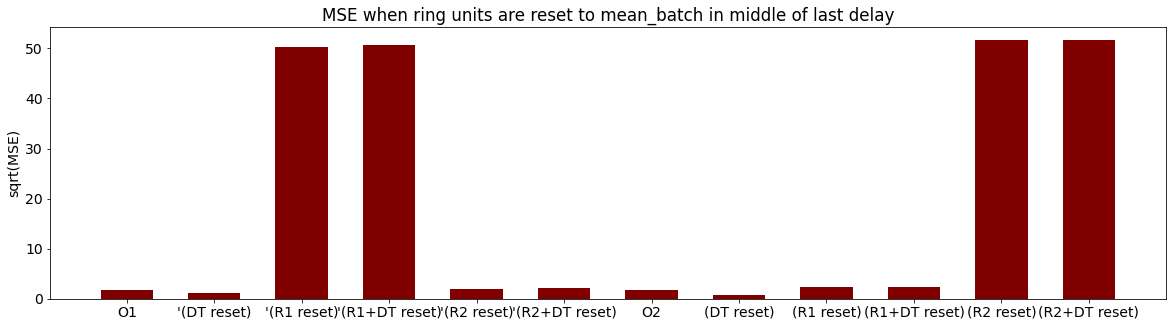

In [34]:
timestep = delay0 + hold_orientation_for*2 + delay1 + delay2//2
timestep_desc = "in middle of last delay"
timestep //= time_res

to_pow = 1#0.5
fig = plt.figure(figsize = (20, 5)) 
# creating the bar plot
plt.bar([
    "O1", 
    "'(DT reset)", 
    "'(R1 reset)", 
    "'(R1+DT reset)", 
    "'(R2 reset)", 
    "'(R2+DT reset)", 
    "O2", 
    "(DT reset)",
    "(R1 reset)",
    "(R1+DT reset)", 
    "(R2 reset)",
    "(R2+DT reset)"], 
        [
    O1_error_no_reset**to_pow, 
    O1_error_DT_reset[timestep]**to_pow, 
    O1_error_R1_reset[timestep]**to_pow, 
    O1_error_R1DT_reset[timestep]**to_pow, 
    O1_error_R2_reset[timestep]**to_pow, 
    O1_error_R2DT_reset[timestep]**to_pow, 
    O2_error_no_reset**to_pow, 
    O2_error_DT_reset[timestep]**to_pow, 
    O2_error_R1_reset[timestep]**to_pow, 
    O2_error_R1DT_reset[timestep]**to_pow, 
    O2_error_R2_reset[timestep]**to_pow, 
    O2_error_R2DT_reset[timestep]**to_pow], 
color ='maroon',width = 0.6)
#plt.xlabel("Error")
#plt.ylim(0, 0.4)
plt.ylabel("sqrt(MSE)")
plt.title(f"MSE when ring units are reset to {reset_to} " + timestep_desc)
plt.show()

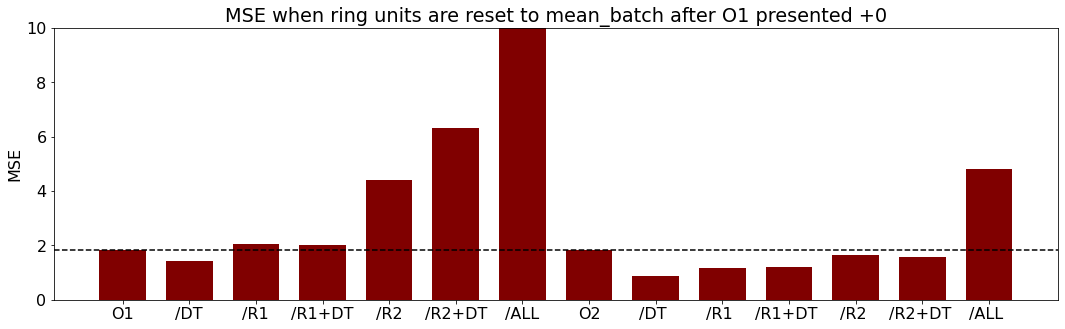

In [38]:
timestep = delay0 + hold_orientation_for + (delay1//10)*2# + delay2//2
k = 0
timestep = timestep // time_res + k #res
timestep_desc = "after O1 presented +"+str(k*time_res)

font = {'family' : 'Ariel',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

to_pow = 1#0.5
fig = plt.figure(figsize = (18, 5)) 
plt.axhline(y=((O2_error_no_reset+O1_error_no_reset)/2)**to_pow, color='k', linestyle='--')
# creating the bar plot
plt.bar([
    "O1", 
    "/DT", 
    "/R1", 
    "/R1+DT", 
    "/R2", 
    "/R2+DT", 
    "/ALL", 
    "O2", 
    "/DT ", 
    "/R1 ", 
    "/R1+DT ", 
    "/R2 ", 
    "/R2+DT ", 
    "/ALL ", ], 
        [
    O1_error_no_reset**to_pow, 
    O1_error_DT_reset[timestep]**to_pow, 
    O1_error_R1_reset[timestep]**to_pow, 
    O1_error_R1DT_reset[timestep]**to_pow, 
    O1_error_R2_reset[timestep]**to_pow, 
    O1_error_R2DT_reset[timestep]**to_pow, 
    O1_error_ALL_reset[timestep]**to_pow, 
    O2_error_no_reset**to_pow, 
    O2_error_DT_reset[timestep]**to_pow, 
    O2_error_R1_reset[timestep]**to_pow, 
    O2_error_R1DT_reset[timestep]**to_pow, 
    O2_error_R2_reset[timestep]**to_pow, 
    O2_error_R2DT_reset[timestep]**to_pow,
    O2_error_ALL_reset[timestep]**to_pow, ], 
color ='maroon',width = 0.7)
#plt.xlabel("Error")
#plt.ylim(0, (0.25**2)**to_pow)
plt.ylim(0, 10)
plt.ylabel("MSE" if to_pow == 1 else "sqrt(MSE)")
plt.title(f"MSE when ring units are reset to {reset_to} " + timestep_desc)
plt.show()

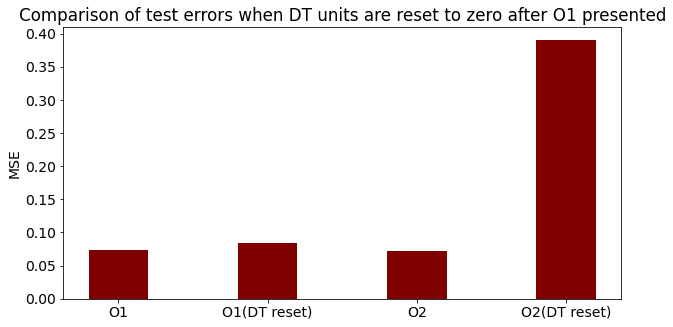

In [308]:
timestep, timestep_desc = t2, t2d

e_o1, e_o2, _ = errors_when_reset_units_at_timestep(DT_i, timestep, res=ori_res)

fig = plt.figure(figsize = (10, 5)) 
# creating the bar plot
plt.bar(["O1", "O1(DT reset)", "O2", "O2(DT reset)"], 
        [O1_error_no_reset**to_pow, e_o1**to_pow, 
         O2_error_no_reset**to_pow, e_o2**to_pow], 
        color ='maroon',width = 0.4)
#plt.xlabel("Error")
plt.ylabel("MSE")
plt.title("Comparison of test errors when DT units are reset to zero " + timestep_desc)
plt.show()

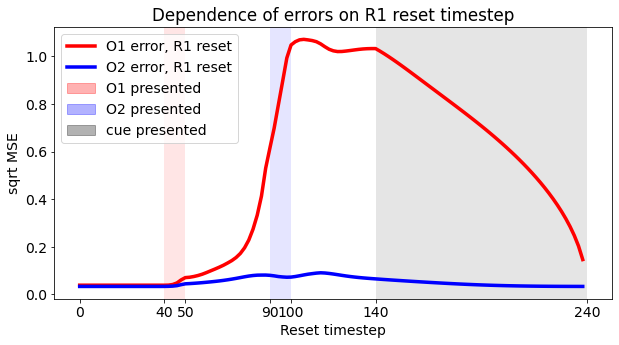

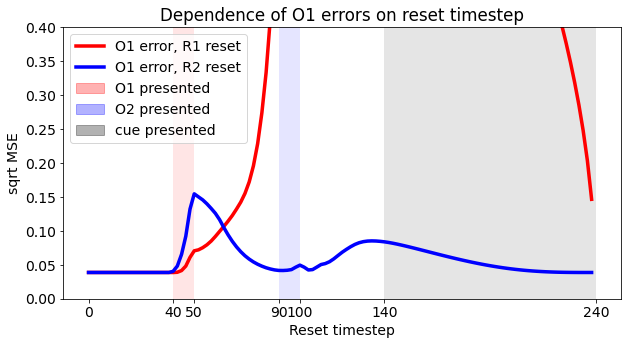

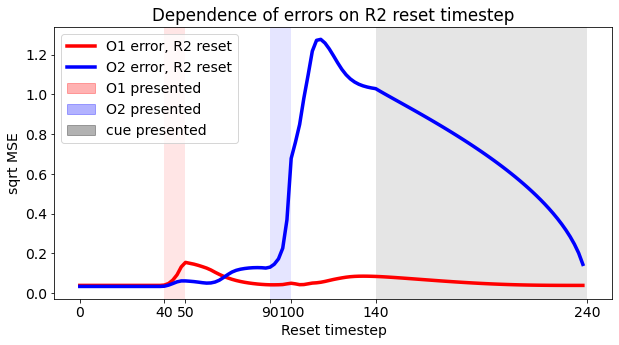

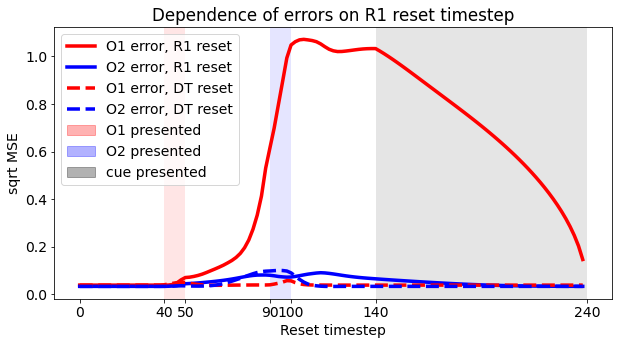

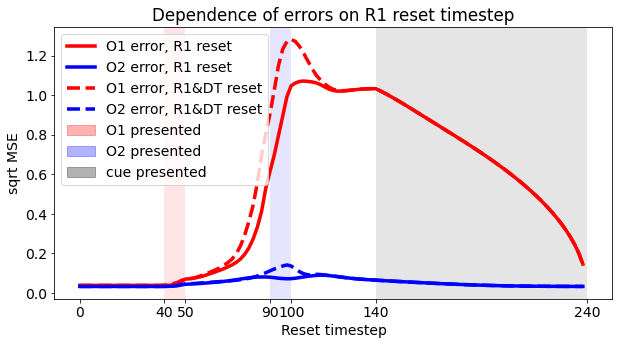

In [117]:
font = {'family' : 'Ariel',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

plt.figure(figsize=(10, 5))
plt.plot(timesteps, O1_error_O1_reset**to_pow, "r-", linewidth=3.5, label="O1 error, R1 reset")
#plt.plot(timesteps, O1_error_O1_reset_O2, "r--", linewidth=3.5, label="O1 error to O2, R1 reset")
plt.plot(timesteps, O2_error_O1_reset**to_pow, "b-", linewidth=3.5, label="O2 error, R1 reset")
#plt.plot(timesteps, O1_error_DT_reset, "r--", markersize=10, label="R1 error, DT reset")
#plt.plot(timesteps, O2_error_DT_reset, "b--", markersize=10, label="R2 error, DT reset")
#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
plt.xlabel('Reset timestep')
plt.ylabel('sqrt MSE')
plt.title(f'Dependence of errors on R1 reset timestep')
plt.legend()
annotate_task_on_plt(plt)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(timesteps, O1_error_O1_reset**to_pow, "r-", linewidth=3.5, label="O1 error, R1 reset")
#plt.plot(timesteps, O1_error_O1_reset_O2, "r--", linewidth=3.5, label="O1 error to O2, R1 reset")
plt.plot(timesteps, O1_error_O2_reset**to_pow, "b-", linewidth=3.5, label="O1 error, R2 reset")
#plt.plot(timesteps, O1_error_DT_reset, "r--", markersize=10, label="R1 error, DT reset")
#plt.plot(timesteps, O2_error_DT_reset, "b--", markersize=10, label="R2 error, DT reset")
#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
plt.xlabel('Reset timestep')
plt.ylabel('sqrt MSE')
plt.title(f'Dependence of O1 errors on reset timestep')
plt.ylim(0, 0.4)
plt.legend()
annotate_task_on_plt(plt)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(timesteps, O1_error_O2_reset**to_pow, "r-", linewidth=3.5, label="O1 error, R2 reset")
plt.plot(timesteps, O2_error_O2_reset**to_pow, "b-", linewidth=3.5, label="O2 error, R2 reset")
#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
plt.xlabel('Reset timestep')
plt.ylabel('sqrt MSE')
plt.title(f'Dependence of errors on R2 reset timestep')
plt.legend()
annotate_task_on_plt(plt)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(timesteps, O1_error_O1_reset**to_pow, "r-", linewidth=3.5, label="O1 error, R1 reset")
plt.plot(timesteps, O2_error_O1_reset**to_pow, "b-", linewidth=3.5, label="O2 error, R1 reset")
plt.plot(timesteps, O1_error_DT_reset**to_pow, "r--", linewidth=3.5, label="O1 error, DT reset")
plt.plot(timesteps, O2_error_DT_reset**to_pow, "b--", linewidth=3.5, label="O2 error, DT reset")
#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
plt.xlabel('Reset timestep')
plt.ylabel('sqrt MSE')
plt.title(f'Dependence of errors on R1 reset timestep')
plt.legend()
annotate_task_on_plt(plt)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(timesteps, O1_error_O1_reset**to_pow, "r-", linewidth=3.5, label="O1 error, R1 reset")
plt.plot(timesteps, O2_error_O1_reset**to_pow, "b-", linewidth=3.5, label="O2 error, R1 reset")
plt.plot(timesteps, O1_error_R1DT_reset**to_pow, "r--", linewidth=3.5, label="O1 error, R1&DT reset")
plt.plot(timesteps, O2_error_R1DT_reset**to_pow, "b--", linewidth=3.5, label="O2 error, R1&DT reset")
#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
plt.xlabel('Reset timestep')
plt.ylabel('sqrt MSE')
plt.title(f'Dependence of errors on R1 reset timestep')
plt.legend()
annotate_task_on_plt(plt)
plt.show()

## Linear decoder

In [286]:
O2_SET = torch.tensor(ORI_SET).repeat(180//ORI_RES).float() / 180 * np.pi * 2
O1_SET = torch.tensor(ORI_SET).repeat_interleave(180//ORI_RES).float() / 180 * np.pi * 2
O1_SET_S, O1_SET_C = torch.sin(O1_SET), torch.cos(O1_SET)
O2_SET_S, O2_SET_C = torch.sin(O2_SET), torch.cos(O2_SET)

0 20 40 60 80 100 120 140 160 180 200 220 

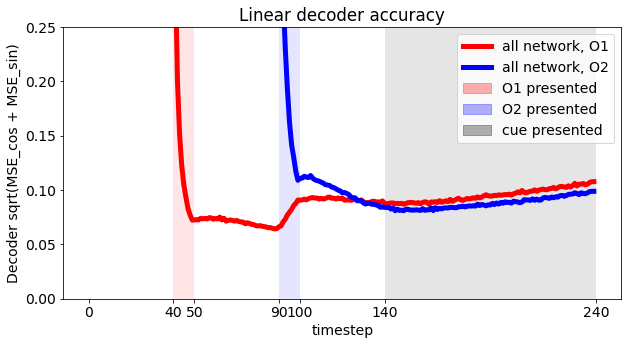

In [287]:
ALL_O1_L_S, ALL_O2_L_S, ALL_O1_E_S, ALL_O2_E_S = [], [], [], []
ALL_O1_L_C, ALL_O2_L_C, ALL_O1_E_C, ALL_O2_E_C = [], [], [], []
for t in range(total_time):
    if t % 20 == 0: print(t, end = " ")
    A = megabatch_output[1][:, t, :][:, :]
    P = torch.linalg.pinv(A)
    P_O1_S = P @ O1_SET_S
    P_O1_C = P @ O1_SET_C
    P_O2_S = P @ O2_SET_S
    P_O2_C = P @ O2_SET_C
    ALL_O1_L_S.append(P_O1_S.unsqueeze(0))
    ALL_O1_L_C.append(P_O1_C.unsqueeze(0))
    ALL_O1_E_S.append( torch.mean((A@P_O1_S - O1_SET_S)**2) )
    ALL_O1_E_C.append( torch.mean((A@P_O1_C - O1_SET_C)**2) )
    ALL_O2_L_S.append(P_O2_S.unsqueeze(0))
    ALL_O2_L_C.append(P_O2_C.unsqueeze(0))
    ALL_O2_E_S.append( torch.mean((A@P_O2_S - O2_SET_S)**2) )
    ALL_O2_E_C.append( torch.mean((A@P_O2_C - O2_SET_C)**2) )
ALL_O1_L_S = torch.cat(ALL_O1_L_S)
ALL_O1_L_C = torch.cat(ALL_O1_L_C)
ALL_O1_E_S = torch.tensor(ALL_O1_E_S)
ALL_O1_E_C = torch.tensor(ALL_O1_E_C)
ALL_O2_L_S = torch.cat(ALL_O2_L_S)
ALL_O2_L_C = torch.cat(ALL_O2_L_C)
ALL_O2_E_S = torch.tensor(ALL_O2_E_S)
ALL_O2_E_C = torch.tensor(ALL_O2_E_C)
time = range(total_time)

plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(10, 5))
plt.plot(time, (ALL_O1_E_S + ALL_O1_E_C)**0.5, "r-", linewidth=5, markersize=10, label="all network, O1")
plt.plot(time, (ALL_O2_E_S + ALL_O2_E_C)**0.5, "b-", linewidth=5, markersize=10, label="all network, O2")
plt.xlabel('timestep')
plt.ylabel('Decoder sqrt(MSE_cos + MSE_sin)')
#plt.title(f'How does preferred orientation of unit {i} change?')
plt.legend()
plt.title("Linear decoder accuracy")
plt.ylim(0, 0.25)
annotate_task_on_plt(plt)

0 20 40 60 80 100 120 140 160 180 200 220 

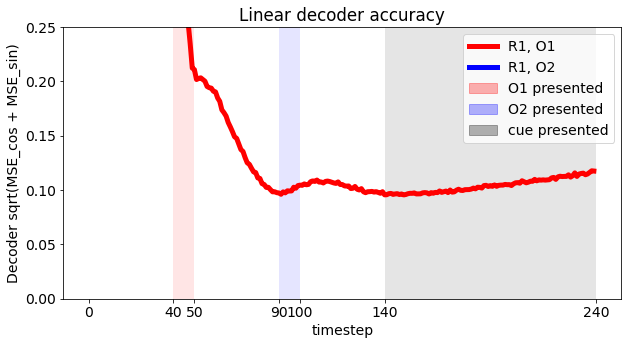

In [288]:
ALL_O1_L_S, ALL_O2_L_S, ALL_O1_E_S, ALL_O2_E_S = [], [], [], []
ALL_O1_L_C, ALL_O2_L_C, ALL_O1_E_C, ALL_O2_E_C = [], [], [], []
R1_f_i = R1_i[torch.argsort(torch.max(torch.abs(model.fc_x2ah.weight[R1_i, :-1]), dim=1).values)][:len(R1_i)//2]
R1_s_i = R1_i[torch.argsort(torch.max(torch.abs(model.fc_x2ah.weight[R1_i, :-1]), dim=1).values)][len(R1_i)//2:]
R2_f_i = R2_i[torch.argsort(torch.max(torch.abs(model.fc_x2ah.weight[R2_i, :-1]), dim=1).values)][:len(R2_i)//2]
R2_s_i = R2_i[torch.argsort(torch.max(torch.abs(model.fc_x2ah.weight[R2_i, :-1]), dim=1).values)][len(R2_i)//2:]

for t in range(total_time):
    if t % 20 == 0: print(t, end = " ")
    A = megabatch_output[1][:, t, :][:, R1_i]
    P = torch.linalg.pinv(A)
    P_O1_S = P @ O1_SET_S
    P_O1_C = P @ O1_SET_C
    P_O2_S = P @ O2_SET_S
    P_O2_C = P @ O2_SET_C
    ALL_O1_L_S.append(P_O1_S.unsqueeze(0))
    ALL_O1_L_C.append(P_O1_C.unsqueeze(0))
    ALL_O1_E_S.append( torch.mean((A@P_O1_S - O1_SET_S)**2) )
    ALL_O1_E_C.append( torch.mean((A@P_O1_C - O1_SET_C)**2) )
    ALL_O2_L_S.append(P_O2_S.unsqueeze(0))
    ALL_O2_L_C.append(P_O2_C.unsqueeze(0))
    ALL_O2_E_S.append( torch.mean((A@P_O2_S - O2_SET_S)**2) )
    ALL_O2_E_C.append( torch.mean((A@P_O2_C - O2_SET_C)**2) )
ALL_O1_L_S = torch.cat(ALL_O1_L_S)
ALL_O1_L_C = torch.cat(ALL_O1_L_C)
ALL_O1_E_S = torch.tensor(ALL_O1_E_S)
ALL_O1_E_C = torch.tensor(ALL_O1_E_C)
ALL_O2_L_S = torch.cat(ALL_O2_L_S)
ALL_O2_L_C = torch.cat(ALL_O2_L_C)
ALL_O2_E_S = torch.tensor(ALL_O2_E_S)
ALL_O2_E_C = torch.tensor(ALL_O2_E_C)
time = range(total_time)

plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(10, 5))
plt.plot(time, (ALL_O1_E_S + ALL_O1_E_C)**0.5, "r-", linewidth=5, markersize=10, label="R1, O1")
plt.plot(time, (ALL_O2_E_S + ALL_O2_E_C)**0.5, "b-", linewidth=5, markersize=10, label="R1, O2")
plt.xlabel('timestep')
plt.ylabel('Decoder sqrt(MSE_cos + MSE_sin)')
#plt.title(f'How does preferred orientation of unit {i} change?')
plt.legend()
plt.title("Linear decoder accuracy")
plt.ylim(0, 0.25)
annotate_task_on_plt(plt)

0 20 40 60 80 100 120 140 160 180 200 220 

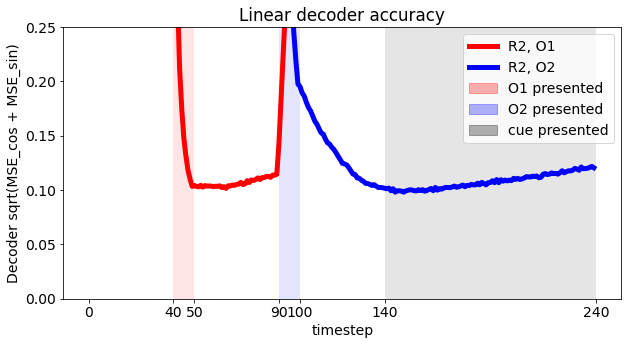

In [289]:
ALL_O1_L_S, ALL_O2_L_S, ALL_O1_E_S, ALL_O2_E_S = [], [], [], []
ALL_O1_L_C, ALL_O2_L_C, ALL_O1_E_C, ALL_O2_E_C = [], [], [], []
for t in range(total_time):
    if t % 20 == 0: print(t, end = " ")
    A = megabatch_output[1][:, t, :][:, R2_i]
    P = torch.linalg.pinv(A)
    P_O1_S = P @ O1_SET_S
    P_O1_C = P @ O1_SET_C
    P_O2_S = P @ O2_SET_S
    P_O2_C = P @ O2_SET_C
    ALL_O1_L_S.append(P_O1_S.unsqueeze(0))
    ALL_O1_L_C.append(P_O1_C.unsqueeze(0))
    ALL_O1_E_S.append( torch.mean((A@P_O1_S - O1_SET_S)**2) )
    ALL_O1_E_C.append( torch.mean((A@P_O1_C - O1_SET_C)**2) )
    ALL_O2_L_S.append(P_O2_S.unsqueeze(0))
    ALL_O2_L_C.append(P_O2_C.unsqueeze(0))
    ALL_O2_E_S.append( torch.mean((A@P_O2_S - O2_SET_S)**2) )
    ALL_O2_E_C.append( torch.mean((A@P_O2_C - O2_SET_C)**2) )
ALL_O1_L_S = torch.cat(ALL_O1_L_S)
ALL_O1_L_C = torch.cat(ALL_O1_L_C)
ALL_O1_E_S = torch.tensor(ALL_O1_E_S)
ALL_O1_E_C = torch.tensor(ALL_O1_E_C)
ALL_O2_L_S = torch.cat(ALL_O2_L_S)
ALL_O2_L_C = torch.cat(ALL_O2_L_C)
ALL_O2_E_S = torch.tensor(ALL_O2_E_S)
ALL_O2_E_C = torch.tensor(ALL_O2_E_C)
time = range(total_time)

plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(10,5))
plt.plot(time, (ALL_O1_E_S + ALL_O1_E_C)**0.5, "r-", linewidth=5, markersize=10, label="R2, O1")
plt.plot(time, (ALL_O2_E_S + ALL_O2_E_C)**0.5, "b-", linewidth=5, markersize=10, label="R2, O2")
plt.xlabel('timestep')
plt.ylabel('Decoder sqrt(MSE_cos + MSE_sin)')
#plt.title(f'How does preferred orientation of unit {i} change?')
plt.legend()
plt.title("Linear decoder accuracy")
plt.ylim(0, 0.25)
annotate_task_on_plt(plt)

0 20 40 60 80 100 120 140 160 180 200 220 

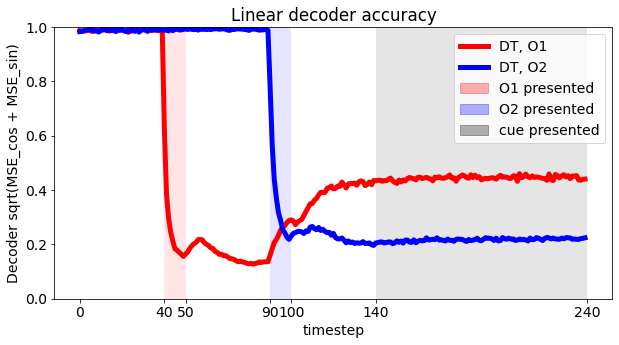

In [36]:
ALL_O1_L_S, ALL_O2_L_S, ALL_O1_E_S, ALL_O2_E_S = [], [], [], []
ALL_O1_L_C, ALL_O2_L_C, ALL_O1_E_C, ALL_O2_E_C = [], [], [], []
for t in range(total_time):
    if t % 20 == 0: print(t, end = " ")
    A = megabatch_output[1][:, t, :][:, DT_i]
    P = torch.linalg.pinv(A)
    P_O1_S = P @ O1_SET_S
    P_O1_C = P @ O1_SET_C
    P_O2_S = P @ O2_SET_S
    P_O2_C = P @ O2_SET_C
    ALL_O1_L_S.append(P_O1_S.unsqueeze(0))
    ALL_O1_L_C.append(P_O1_C.unsqueeze(0))
    ALL_O1_E_S.append( torch.mean((A@P_O1_S - O1_SET_S)**2) )
    ALL_O1_E_C.append( torch.mean((A@P_O1_C - O1_SET_C)**2) )
    ALL_O2_L_S.append(P_O2_S.unsqueeze(0))
    ALL_O2_L_C.append(P_O2_C.unsqueeze(0))
    ALL_O2_E_S.append( torch.mean((A@P_O2_S - O2_SET_S)**2) )
    ALL_O2_E_C.append( torch.mean((A@P_O2_C - O2_SET_C)**2) )
ALL_O1_L_S = torch.cat(ALL_O1_L_S)
ALL_O1_L_C = torch.cat(ALL_O1_L_C)
ALL_O1_E_S = torch.tensor(ALL_O1_E_S)
ALL_O1_E_C = torch.tensor(ALL_O1_E_C)
ALL_O2_L_S = torch.cat(ALL_O2_L_S)
ALL_O2_L_C = torch.cat(ALL_O2_L_C)
ALL_O2_E_S = torch.tensor(ALL_O2_E_S)
ALL_O2_E_C = torch.tensor(ALL_O2_E_C)
time = range(total_time)

plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(10, 5))
plt.plot(time, (ALL_O1_E_S + ALL_O1_E_C)**0.5, "r-", linewidth=5, markersize=10, label="DT, O1")
plt.plot(time, (ALL_O2_E_S + ALL_O2_E_C)**0.5, "b-", linewidth=5, markersize=10, label="DT, O2")
plt.xlabel('timestep')
plt.ylabel('Decoder sqrt(MSE_cos + MSE_sin)')
#plt.title(f'How does preferred orientation of unit {i} change?')
plt.legend()
plt.title("Linear decoder accuracy")
plt.ylim(0, 1)
annotate_task_on_plt(plt)

0 20 40 60 80 100 120 140 160 180 200 220 

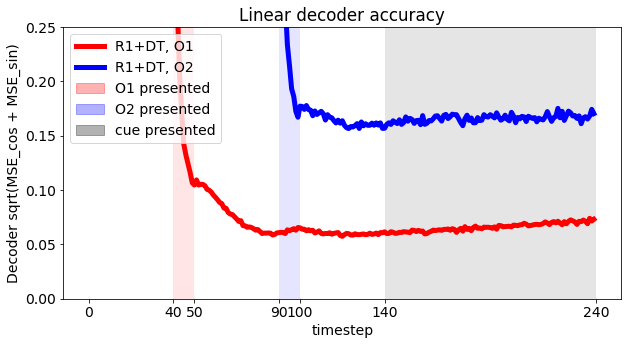

In [37]:
ALL_O1_L_S, ALL_O2_L_S, ALL_O1_E_S, ALL_O2_E_S = [], [], [], []
ALL_O1_L_C, ALL_O2_L_C, ALL_O1_E_C, ALL_O2_E_C = [], [], [], []
for t in range(total_time):
    if t % 20 == 0: print(t, end = " ")
    A = megabatch_output[1][:, t, :][:, torch.cat((R1_i, DT_i))]
    B = torch.ones((A.shape[0], 1))
    #A = torch.hstack((A, B))
    #print(A.shape)
    P = torch.linalg.pinv(A)
    P_O1_S = P @ O1_SET_S
    P_O1_C = P @ O1_SET_C
    P_O2_S = P @ O2_SET_S
    P_O2_C = P @ O2_SET_C
    ALL_O1_L_S.append(P_O1_S.unsqueeze(0))
    ALL_O1_L_C.append(P_O1_C.unsqueeze(0))
    ALL_O1_E_S.append( torch.mean((A@P_O1_S - O1_SET_S)**2) )
    ALL_O1_E_C.append( torch.mean((A@P_O1_C - O1_SET_C)**2) )
    ALL_O2_L_S.append(P_O2_S.unsqueeze(0))
    ALL_O2_L_C.append(P_O2_C.unsqueeze(0))
    ALL_O2_E_S.append( torch.mean((A@P_O2_S - O2_SET_S)**2) )
    ALL_O2_E_C.append( torch.mean((A@P_O2_C - O2_SET_C)**2) )
ALL_O1_L_S = torch.cat(ALL_O1_L_S)
ALL_O1_L_C = torch.cat(ALL_O1_L_C)
ALL_O1_E_S = torch.tensor(ALL_O1_E_S)
ALL_O1_E_C = torch.tensor(ALL_O1_E_C)
ALL_O2_L_S = torch.cat(ALL_O2_L_S)
ALL_O2_L_C = torch.cat(ALL_O2_L_C)
ALL_O2_E_S = torch.tensor(ALL_O2_E_S)
ALL_O2_E_C = torch.tensor(ALL_O2_E_C)
time = range(total_time)

plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(10, 5))
plt.plot(time, (ALL_O1_E_S + ALL_O1_E_C)**0.5, "r-", linewidth=5, markersize=10, label="R1+DT, O1")
plt.plot(time, (ALL_O2_E_S + ALL_O2_E_C)**0.5, "b-", linewidth=5, markersize=10, label="R1+DT, O2")
plt.xlabel('timestep')
plt.ylabel('Decoder sqrt(MSE_cos + MSE_sin)')
#plt.title(f'How does preferred orientation of unit {i} change?')
plt.legend()
plt.title("Linear decoder accuracy")
plt.ylim(0, 0.25)
annotate_task_on_plt(plt)

0 20 40 60 80 100 120 140 160 180 200 220 

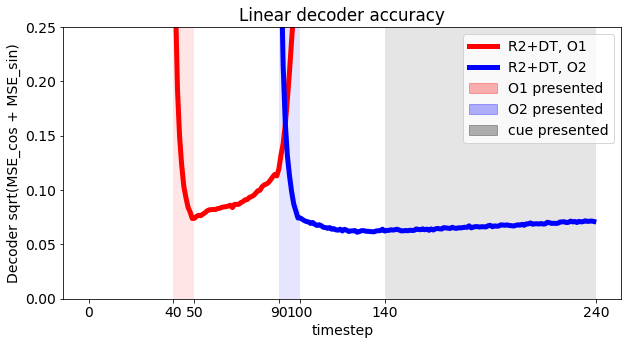

In [23]:
ALL_O1_L_S, ALL_O2_L_S, ALL_O1_E_S, ALL_O2_E_S = [], [], [], []
ALL_O1_L_C, ALL_O2_L_C, ALL_O1_E_C, ALL_O2_E_C = [], [], [], []
for t in range(total_time):
    if t % 20 == 0: print(t, end = " ")
    A = megabatch_output[1][:, t, :][:, torch.cat((R2_i, DT_i))]
    B = torch.ones((A.shape[0], 1))
    #A = torch.hstack((A, B))
    #print(A.shape)
    P = torch.linalg.pinv(A)
    P_O1_S = P @ O1_SET_S
    P_O1_C = P @ O1_SET_C
    P_O2_S = P @ O2_SET_S
    P_O2_C = P @ O2_SET_C
    ALL_O1_L_S.append(P_O1_S.unsqueeze(0))
    ALL_O1_L_C.append(P_O1_C.unsqueeze(0))
    ALL_O1_E_S.append( torch.mean((A@P_O1_S - O1_SET_S)**2) )
    ALL_O1_E_C.append( torch.mean((A@P_O1_C - O1_SET_C)**2) )
    ALL_O2_L_S.append(P_O2_S.unsqueeze(0))
    ALL_O2_L_C.append(P_O2_C.unsqueeze(0))
    ALL_O2_E_S.append( torch.mean((A@P_O2_S - O2_SET_S)**2) )
    ALL_O2_E_C.append( torch.mean((A@P_O2_C - O2_SET_C)**2) )
ALL_O1_L_S = torch.cat(ALL_O1_L_S)
ALL_O1_L_C = torch.cat(ALL_O1_L_C)
ALL_O1_E_S = torch.tensor(ALL_O1_E_S)
ALL_O1_E_C = torch.tensor(ALL_O1_E_C)
ALL_O2_L_S = torch.cat(ALL_O2_L_S)
ALL_O2_L_C = torch.cat(ALL_O2_L_C)
ALL_O2_E_S = torch.tensor(ALL_O2_E_S)
ALL_O2_E_C = torch.tensor(ALL_O2_E_C)
time = range(total_time)

plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(10, 5))
plt.plot(time, (ALL_O1_E_S + ALL_O1_E_C)**0.5, "r-", linewidth=5, markersize=10, label="R2+DT, O1")
plt.plot(time, (ALL_O2_E_S + ALL_O2_E_C)**0.5, "b-", linewidth=5, markersize=10, label="R2+DT, O2")
plt.xlabel('timestep')
plt.ylabel('Decoder sqrt(MSE_cos + MSE_sin)')
#plt.title(f'How does preferred orientation of unit {i} change?')
plt.legend()
plt.title("Linear decoder accuracy")
plt.ylim(0, 0.25)
annotate_task_on_plt(plt)

## Gross connectivity

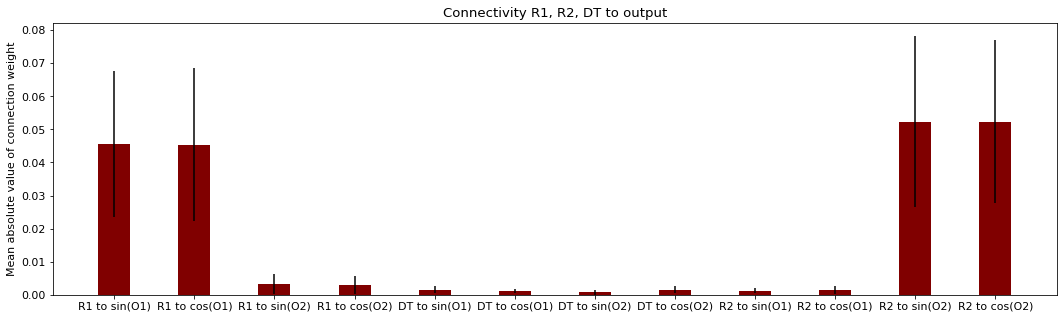

In [145]:
to_pow = 1.0
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 11})
fig = plt.figure(figsize = (18, 5)) 
# creating the bar plot
plt.bar(["R1 to sin(O1)", "R1 to cos(O1)", "R1 to sin(O2)", "R1 to cos(O2)",
        "DT to sin(O1)", "DT to cos(O1)", "DT to sin(O2)", "DT to cos(O2)",
        "R2 to sin(O1)", "R2 to cos(O1)", "R2 to sin(O2)", "R2 to cos(O2)"], 
        torch.cat([torch.mean(torch.abs(model.fc_h2y.weight[:, R1_i]), dim=1),
                  torch.mean(torch.abs(model.fc_h2y.weight[:, DT_i]), dim=1),
                  torch.mean(torch.abs(model.fc_h2y.weight[:, R2_i]), dim=1)]).cpu().detach().numpy(), 
        yerr=torch.cat([torch.std(torch.abs(model.fc_h2y.weight[:, R1_i]), dim=1),
                        torch.std(torch.abs(model.fc_h2y.weight[:, DT_i]), dim=1),
                        torch.std(torch.abs(model.fc_h2y.weight[:, R2_i]), dim=1)]).cpu().detach().numpy(), 
        color ='maroon',width = 0.4)
#plt.xlabel("Error")
plt.ylabel("Mean absolute value of connection weight")
plt.title("Connectivity R1, R2, DT to output")
plt.show()

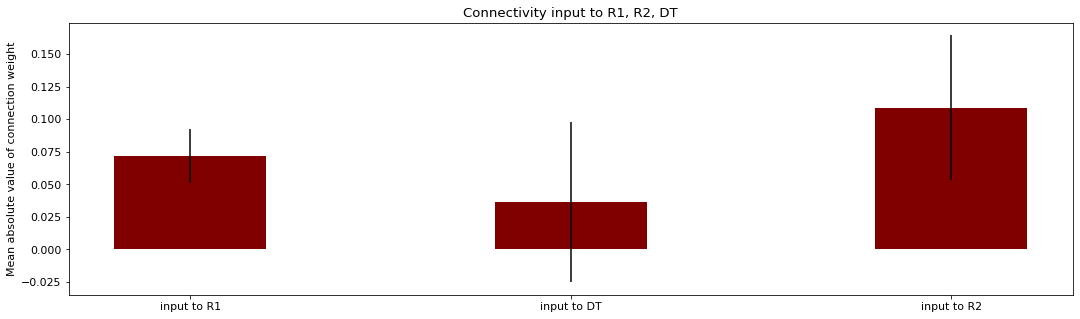

In [308]:
to_pow = 1.0
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 11})
fig = plt.figure(figsize = (18, 5)) 
# creating the bar plot
plt.bar(["input to R1", "input to DT", "input to R2"], 
        [torch.mean(torch.abs(model.fc_x2ah.weight[R1_indices[-1], :-1])).detach().numpy(),
        torch.mean(torch.abs(model.fc_x2ah.weight[DT_indices[-1], :-1])).detach().numpy(),
        torch.mean(torch.abs(model.fc_x2ah.weight[R2_i, :-1])).detach().numpy()], 
        yerr=[torch.std(torch.abs(model.fc_x2ah.weight[R1_i, :-1])).detach().numpy(),
        torch.std(torch.abs(model.fc_x2ah.weight[DT_i, :-1])).detach().numpy(),
        torch.std(torch.abs(model.fc_x2ah.weight[R2_i, :-1])).detach().numpy()], 
        color ='maroon',width = 0.4)
#plt.xlabel("Error")
plt.ylabel("Mean absolute value of connection weight")
plt.title("Connectivity input to R1, R2, DT")
plt.show()

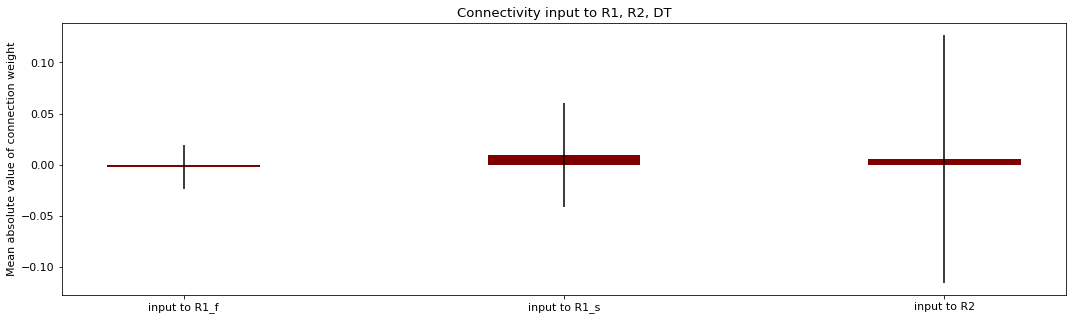

In [221]:
to_pow = 1.0
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 11})
fig = plt.figure(figsize = (18, 5)) 
# creating the bar plot
plt.bar(["input to R1_f", "input to R1_s", "input to R2"], 
        [torch.mean((model.fc_x2ah.weight[R1_f_i, :-1])).detach().numpy(),
        torch.mean((model.fc_x2ah.weight[R1_s_i, :-1])).detach().numpy(),
        torch.mean((model.fc_x2ah.weight[R2_i, :-1])).detach().numpy()], 
        yerr=[torch.std((model.fc_x2ah.weight[R1_f_i, :-1])).detach().numpy(),
        torch.std((model.fc_x2ah.weight[R1_s_i, :-1])).detach().numpy(),
        torch.std((model.fc_x2ah.weight[R2_i, :-1])).detach().numpy()], 
        color ='maroon',width = 0.4)
#plt.xlabel("Error")
plt.ylabel("Mean absolute value of connection weight")
plt.title("Connectivity input to R1, R2, DT")
plt.show()

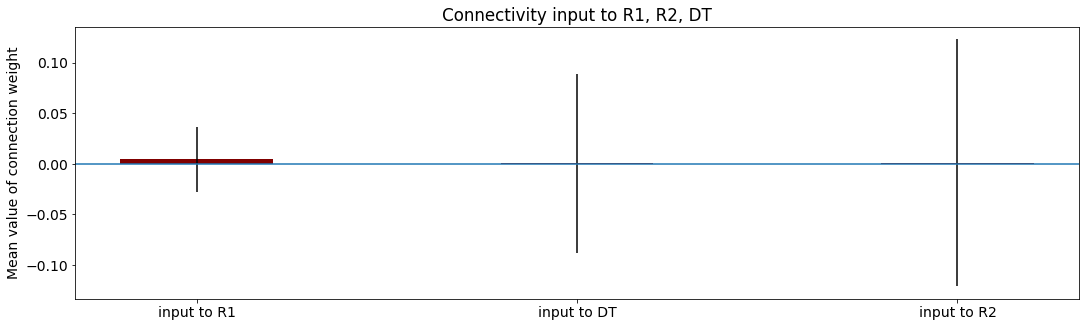

In [309]:
to_pow = 1.0
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize = (18, 5)) 
# creating the bar plot
plt.bar(["input to R1", "input to DT", "input to R2"], 
        [torch.mean((model.fc_x2ah.weight[R1_indices[-1], :-1])).detach().numpy(),
        torch.mean((model.fc_x2ah.weight[DT_indices[-1], :-1])).detach().numpy(),
        torch.mean((model.fc_x2ah.weight[R2_i, :-1])).detach().numpy()], 
        yerr=[torch.std((model.fc_x2ah.weight[R1_i, :-1])).detach().numpy(),
        torch.std((model.fc_x2ah.weight[DT_i, :-1])).detach().numpy(),
        torch.std((model.fc_x2ah.weight[R2_i, :-1])).detach().numpy()], 
        color ='maroon',width = 0.4)
#plt.xlabel("Error")
plt.ylabel("Mean value of connection weight")
plt.title("Connectivity input to R1, R2, DT")
plt.axhline(y=0, xmin=-4, xmax=4)
plt.show()

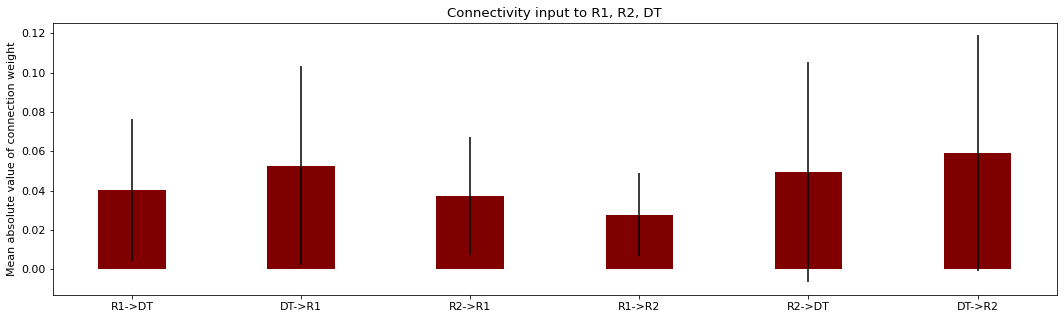

In [310]:
to_pow = 1.0
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 11})
fig = plt.figure(figsize = (18, 5)) 
# creating the bar plot
plt.bar(
[
    "R1->DT", 
    "DT->R1", 
    "R2->R1",
    "R1->R2",
    "R2->DT", 
    "DT->R2", 
], 
[
    torch.mean(torch.abs(model.fc_h2ah.weight[DT_i, :][:, R1_i])).detach().numpy(),
    torch.mean(torch.abs(model.fc_h2ah.weight.T[DT_i, :][:, R1_i])).detach().numpy(),
    torch.mean(torch.abs(model.fc_h2ah.weight[R1_i, :][:, R2_i])).detach().numpy(),
    torch.mean(torch.abs(model.fc_h2ah.weight.T[R1_i, :][:, R2_i])).detach().numpy(),
    torch.mean(torch.abs(model.fc_h2ah.weight[DT_i, :][:, R2_i])).detach().numpy(),
    torch.mean(torch.abs(model.fc_h2ah.weight.T[DT_i, :][:, R2_i])).detach().numpy(),
], 
yerr=[
    torch.std(torch.abs(model.fc_h2ah.weight[DT_i, :][:, R1_i])).detach().numpy(),
    torch.std(torch.abs(model.fc_h2ah.weight.T[DT_i, :][:, R1_i])).detach().numpy(),
    torch.std(torch.abs(model.fc_h2ah.weight[R1_i, :][:, R2_i])).detach().numpy(),
    torch.std(torch.abs(model.fc_h2ah.weight.T[R1_i, :][:, R2_i])).detach().numpy(),
    torch.std(torch.abs(model.fc_h2ah.weight[DT_i, :][:, R2_i])).detach().numpy(),
    torch.std(torch.abs(model.fc_h2ah.weight.T[DT_i, :][:, R2_i])).detach().numpy(),
], color ='maroon',width = 0.4)
#plt.xlabel("Error")
plt.ylabel("Mean absolute value of connection weight")
plt.title("Connectivity input to R1, R2, DT")
plt.show()

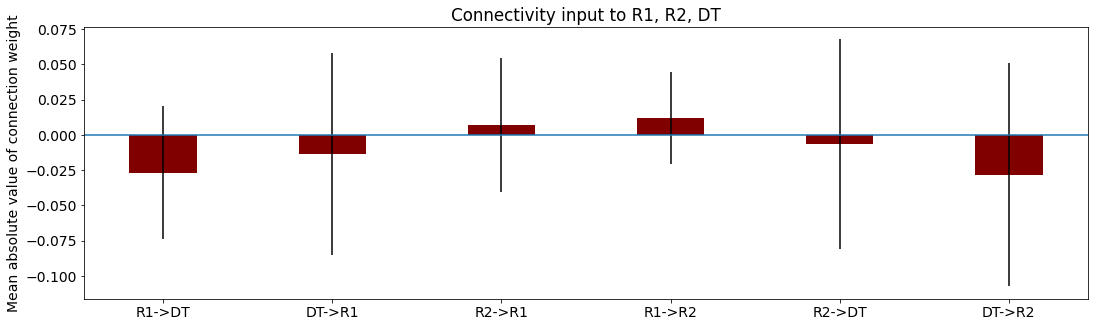

In [311]:
to_pow = 1.0
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize = (18, 5)) 
# creating the bar plot
plt.bar(
[
    "R1->DT", 
    "DT->R1", 
    "R2->R1",
    "R1->R2",
    "R2->DT", 
    "DT->R2", 
], 
[
    torch.mean((model.fc_h2ah.weight[DT_i, :][:, R1_i])).detach().numpy(),
    torch.mean((model.fc_h2ah.weight.T[DT_i, :][:, R1_i])).detach().numpy(),
    torch.mean((model.fc_h2ah.weight[R1_i, :][:, R2_i])).detach().numpy(),
    torch.mean((model.fc_h2ah.weight.T[R1_i, :][:, R2_i])).detach().numpy(),
    torch.mean((model.fc_h2ah.weight[DT_i, :][:, R2_i])).detach().numpy(),
    torch.mean((model.fc_h2ah.weight.T[DT_i, :][:, R2_i])).detach().numpy(),
], 
yerr=[
    torch.std((model.fc_h2ah.weight[DT_i, :][:, R1_i])).detach().numpy(),
    torch.std((model.fc_h2ah.weight.T[DT_i, :][:, R1_i])).detach().numpy(),
    torch.std((model.fc_h2ah.weight[R1_i, :][:, R2_i])).detach().numpy(),
    torch.std((model.fc_h2ah.weight.T[R1_i, :][:, R2_i])).detach().numpy(),
    torch.std((model.fc_h2ah.weight[DT_i, :][:, R2_i])).detach().numpy(),
    torch.std((model.fc_h2ah.weight.T[DT_i, :][:, R2_i])).detach().numpy(),
], color ='maroon',width = 0.4)
#plt.xlabel("Error")
plt.axhline(y=0, xmin=-4, xmax=4)
plt.ylabel("Mean absolute value of connection weight")
plt.title("Connectivity input to R1, R2, DT")
plt.show()

## Experiments

In [174]:
def step(h, ah, input, return_dah=False):
    dah = model.fc_h2ah(h) + model.fc_x2ah(input)
    ah = ah + (model.dt / model.Tau) * (-ah + dah)
    h = models.computef(ah, model.nonlinearity)
    if return_dah:
        return h, ah, dah
    else: 
        return h, ah
def step_log(h, ah, input, return_dah=False):
    dah = -ah + model.fc_h2ah(h) + model.fc_x2ah(input)
    ah = ah + (model.dt / model.Tau) * (dah)
    h = models.computef(ah, model.nonlinearity)
    if return_dah:
        return h, ah, dah
    else: 
        return h, ah
def output(h):
    return model.fc_h2y(h)
def output_graph(h, dotted=None, dotted_label="input", save=None):
    trig = output(h).cpu().detach().numpy()
    o1 = math.atan2( trig[0]/(trig[0]**2+trig[1]**2)**0.5, trig[1]/(trig[0]**2+trig[1]**2)**0.5 ) / 2
    o2 = math.atan2( trig[2]/(trig[2]**2+trig[3]**2)**0.5, trig[3]/(trig[2]**2+trig[3]**2)**0.5 ) / 2
    #return o1, o2#output(h)
    
    plt.figure(figsize=(3, 3))
    # plt.plot([-trig[1], trig[1]], [-trig[0], trig[0]], "r-", linewidth=3.5)
    # plt.plot([-trig[3], trig[3]], [-trig[2], trig[2]], "b-", linewidth=3.5)
    r1 = (trig[0]**2+trig[1]**2)**0.5
    r2 = (trig[2]**2+trig[3]**2)**0.5
    if dotted is not None:
        theta = dotted/180*math.pi
        plt.plot([-math.cos(theta), math.cos(theta)], [-math.sin(theta), math.sin(theta)], "k--", linewidth=3.5, label=dotted_label, alpha=0.7)
    plt.plot([-math.cos(o1)*r1, math.cos(o1)*r1], [-math.sin(o1)*r1, math.sin(o1)*r1], "r-", linewidth=3.5, label="O1")
    plt.plot([-math.cos(o2)*r2, math.cos(o2)*r2], [-math.sin(o2)*r2, math.sin(o2)*r2], "b-", linewidth=3.5, label="O2")
    plt.axis('equal')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.legend(loc='upper left')
    #plt.show()
    return o1 * 180 / math.pi, o2 * 180 / math.pi
def output_hr(h):
    trig = output(h).cpu().detach().numpy()
    o1 = math.atan2( trig[0]/(trig[0]**2+trig[1]**2)**0.5, trig[1]/(trig[0]**2+trig[1]**2)**0.5 ) / 2
    o2 = math.atan2( trig[2]/(trig[2]**2+trig[3]**2)**0.5, trig[3]/(trig[2]**2+trig[3]**2)**0.5 ) / 2
    #return o1, o2#output(h)
    return o1 * 180 / math.pi, o2 * 180 / math.pi 
def init():
    ah = torch.zeros(dim_recurrent)
    h = models.computef(ah, model.nonlinearity)
    return h, ah
def restore_model():
    model.load_state_dict(state_dict)
def hold(h, ah, orientation=None, cue=False, clamp_r1=False, clamp_dt=False, clamp_r2=False, t=50, return_graph=True):
    for i in range(t): 
        input = input_ori[orientation].clone() if orientation is not None else input_del.clone()
        #input = input.clone()
        if cue: input[-1] = 1
        
        h, ah = step(h, ah, input)
        if clamp_dt:
            ah[DT_indices[-1]] = 0
        if clamp_r1:
            ah[R1_indices[-1]] = 0
        if clamp_r2:
            ah[R2_indices[-1]] = 0
    return h, ah, output_graph(h, dotted=orientation) if return_graph else None
def hold_measure_error(h, ah, orientation=None, cue=False, clamp_r1=False, clamp_dt=False, clamp_r2=False, t=50, return_graph=True, o1_target=None, o2_target=None):
    error_o1 = 0
    error_o2 = 0
    for i in range(t): 
        input_s = input_ori[orientation].clone() if orientation is not None else input_del.clone()
        #input_s = input_s
        if cue: input_s[-1] = 1
        
        h, ah = step(h, ah, input_s)
        if clamp_dt:
            ah[DT_indices[-1]] = 0
        if clamp_r1:
            ah[R1_indices[-1]] = 0
        if clamp_r2:
            ah[R2_indices[-1]] = 0
        
        trig = output(h).cpu().detach().numpy()
        o1 = math.atan2( trig[0]/(trig[0]**2+trig[1]**2)**0.5, trig[1]/(trig[0]**2+trig[1]**2)**0.5 ) / 2 * 180 / math.pi
        o2 = math.atan2( trig[2]/(trig[2]**2+trig[3]**2)**0.5, trig[3]/(trig[2]**2+trig[3]**2)**0.5 ) / 2 * 180 / math.pi
        error_o1 += min((o1-o1_target)**2, (o1-o1_target+180)**2)
        error_o2 += min((o2-o2_target)**2, (o2-o2_target+180)**2)
    error_o1 = math.sqrt(error_o1 / t)
    error_o2 = math.sqrt(error_o2 / t)
    if o1_target is None: error_o1=0    
    if o2_target is None: error_o2=0    
    return h, ah, error_o1, error_o2, output_graph(h, dotted=orientation) if return_graph else None
def remove_connections(from_u, to_u):
    if type(from_u) is str and from_u=="IN":
        model.fc_x2ah.weight[to_u, :] = 0
        return
    if type(to_u) is str and to_u=="OUT":
        model.fc_h2y.weight[:, from_u] = 0
        return
    for i in (from_u):
        for j in (to_u):
            model.fc_h2ah.weight[j, i] = 0
input_ori = []
for i in range(181): input_ori.append(task._input_rates(i, simple=simple_input))
input_del = torch.zeros(orientation_neurons+1)
input_cue = torch.tensor([0]*orientation_neurons + [1.])
R1_i = R1_indices[-1-hold_cue_for]
R2_i = R2_indices[-1-hold_cue_for]
DT_i = DT_indices[-1-hold_cue_for]

In [190]:
trig = megabatch_output[0][:, t5+1:t6+1, :]
o1 = torch.atan2((trig[:, :, 0]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5), (trig[:, :, 1]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5)) / 2 * 180 / math.pi
o2 = torch.atan2((trig[:, :, 2]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5), (trig[:, :, 3]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5)) / 2 * 180 / math.pi

trig = megabatch_target[:, t5+1:t6+1, :]
o1_t = torch.atan2((trig[:, :, 0]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5), (trig[:, :, 1]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5)) / 2 * 180 / math.pi
o2_t = torch.atan2((trig[:, :, 2]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5), (trig[:, :, 3]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5)) / 2 * 180 / math.pi

In [218]:
error_o1 = torch.minimum(torch.minimum((o1-o1_t)**2, (o1-o1_t+180)**2), (o1-o1_t-180)**2)
error_o1 = torch.mean(error_o1).item()**0.5
error_o2 = torch.minimum(torch.minimum((o2-o2_t)**2, (o2-o2_t+180)**2), (o2-o2_t-180)**2)
error_o2 = torch.mean(error_o2).item()**0.5
error_o1, error_o2

(2.007381051459961, 1.5959797389482044)

### Measure current

In [181]:
use_delay=True
cue=True
res = 10
restore_model()
with torch.no_grad():
    pass
h_full = []
dah_full = []
for orientation1 in range(0, 180, res):
    for orientation2 in range(0, 180, res):
        h, ah = init()
        dah = 0
        hstore = []
        dahstore = []
        if use_delay: 
            for t in range(delay0):
                h, ah, dah = step(h, ah, input_del.clone(), return_dah=True)
                hstore.append(h)
                dahstore.append(dah)
        for t in range(hold_orientation_for):
            h, ah, dah = step(h, ah, input_ori[orientation1].clone(), return_dah=True)
            hstore.append(h)
            dahstore.append(dah)
        for t in range(delay1):
            h, ah, dah = step(h, ah, input_del.clone(), return_dah=True)
            hstore.append(h)
            dahstore.append(dah)
        for t in range(hold_orientation_for):
            h, ah, dah = step(h, ah, input_ori[orientation2].clone(), return_dah=True)
            hstore.append(h)
            dahstore.append(dah)
        for t in range(delay2):
            h, ah, dah = step(h, ah, input_del.clone(), return_dah=True)
            hstore.append(h)
            dahstore.append(dah)
        for t in range(hold_cue_for):
            h, ah, dah = step(h, ah, input_cue.clone(), return_dah=True)
            hstore.append(h)
            dahstore.append(dah)
        hstore = torch.stack(hstore, dim=1)
        dahstore = torch.stack(dahstore, dim=1)
        h_full.append(hstore)
        dah_full.append(dahstore)
dah_full = torch.stack(dah_full)
h_full = torch.stack(h_full)

In [168]:
torch.mean(torch.abs(dah_full[:, R1_i, :]), dim=[0, 1]).shape

torch.Size([240])

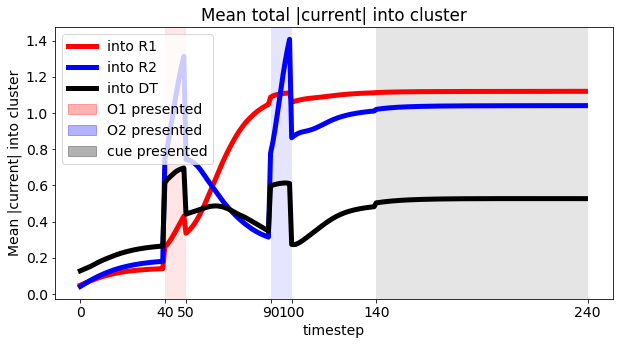

In [179]:
time = range(total_time)
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(10, 5))
plt.plot(time, torch.mean(torch.abs(dah_full[:, R1_i, :]), dim=[0, 1]).detach().numpy(), "r-", linewidth=5, markersize=10, label="into R1")
plt.plot(time, torch.mean(torch.abs(dah_full[:, R2_i, :]), dim=[0, 1]).detach().numpy(), "b-", linewidth=5, markersize=10, label="into R2")
plt.plot(time, torch.mean(torch.abs(dah_full[:, DT_i, :]), dim=[0, 1]).detach().numpy(), "k-", linewidth=5, markersize=10, label="into DT")
plt.xlabel('timestep')
plt.ylabel('Mean |current| into cluster')
plt.title(f'Mean total |current| into cluster')
plt.legend()
#plt.ylim(0, 180)
annotate_task_on_plt(plt)
#plt.ylim(0, 1)
#plt.xlim(delay0, total_time)
#img1 = plt_to_image(fig)

In [218]:
megabatch_output[1][:, :, from_units].shape

torch.Size([3600, 240, 47])

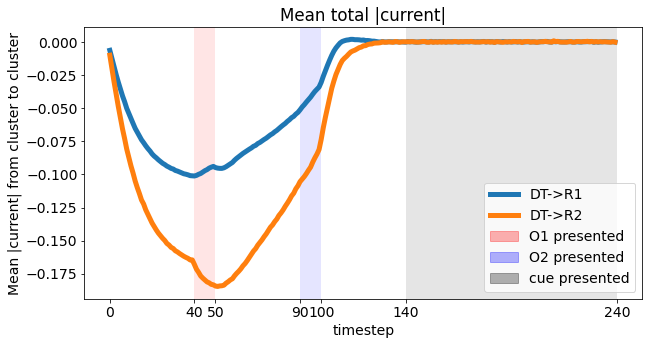

In [91]:
def _show_on_plot(from_units, from_units_desc, to_units, to_units_desc):
    currents = (model.fc_h2ah.weight[to_units, :][:, from_units] @ megabatch_output[1][:, :, from_units].reshape(-1, len(from_units)).T).reshape(len(to_units), -1, total_time)
    currents_mean = torch.mean((currents), dim=[0, 1])
    plt.plot(time, currents_mean.detach().numpy(), linewidth=5, markersize=10, label=f"{from_units_desc}->{to_units_desc}")
    #currents_err = torch.std((currents), dim=[0, 1])

time = range(total_time)
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(10, 5))
_show_on_plot(DT_i, "DT", R1_i, "R1")
_show_on_plot(DT_i, "DT", R2_i, "R2")
plt.xlabel('timestep')
plt.ylabel('Mean |current| from cluster to cluster')
plt.title(f'Mean total |current|')
plt.legend()
#plt.ylim(0, 180)
annotate_task_on_plt(plt)
#plt.ylim(0, 1)
#plt.xlim(delay0, total_time)
#img1 = plt_to_image(fig)

In [204]:
(model.fc_h2ah.weight[to_units, :][:, from_units] @ megabatch_output[1][:, :, from_units].reshape(-1, len(from_units)).T + model.fc_h2ah.bias[]).reshape(len(to_units), -1, total_time).shape

torch.Size([47, 3600, 240])

In [195]:
model.fc_h2ah.weight[to_units, :][:, from_units].shape

torch.Size([47, 12])

In [201]:
megabatch_output[1][:, :, from_units].shape

torch.Size([3600, 240, 12])

In [190]:
torch.mean(torch.abs(model.fc_x2ah(megabatch_input)[:, :, R1_i]), dim=[0, 2]).shape

torch.Size([240])

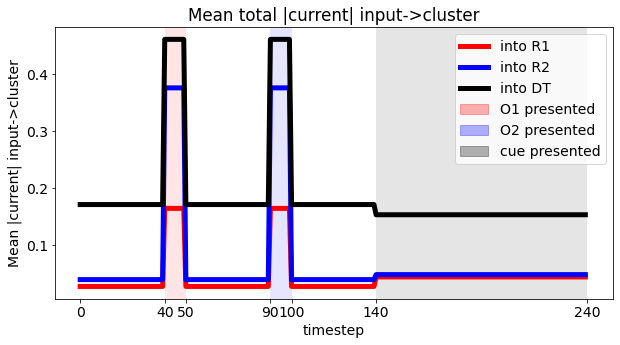

In [234]:
time = range(total_time)
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(10, 5))
plt.plot(time, torch.std(torch.abs(model.fc_x2ah(megabatch_input)[:, :, R1_i]), dim=[0, 2]).detach().numpy(), "r-", linewidth=5, markersize=10, label="into R1")
plt.plot(time, torch.std(torch.abs(model.fc_x2ah(megabatch_input)[:, :, R2_i]), dim=[0, 2]).detach().numpy(), "b-", linewidth=5, markersize=10, label="into R2")
plt.plot(time, torch.std(torch.abs(model.fc_x2ah(megabatch_input)[:, :, DT_i]), dim=[0, 2]).detach().numpy(), "k-", linewidth=5, markersize=10, label="into DT")
plt.xlabel('timestep')
plt.ylabel('Mean |current| input->cluster')
plt.title(f'Mean total |current| input->cluster')
plt.legend()
#plt.ylim(0, 180)
annotate_task_on_plt(plt)
#plt.ylim(0, 1)
#plt.xlim(delay0, total_time)
#img1 = plt_to_image(fig)

In [ ]:
time = range(total_time)
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(10, 5))
plt.plot(time, torch.mean(torch.abs(dah_full[:, R1_i, :]), dim=[0, 1]).detach().numpy(), "r-", linewidth=5, markersize=10, label="into R1")
plt.plot(time, torch.mean(torch.abs(dah_full[:, R2_i, :]), dim=[0, 1]).detach().numpy(), "b-", linewidth=5, markersize=10, label="into R2")
plt.plot(time, torch.mean(torch.abs(dah_full[:, DT_i, :]), dim=[0, 1]).detach().numpy(), "k-", linewidth=5, markersize=10, label="into DT")
plt.xlabel('timestep')
plt.ylabel('Mean |current| into cluster')
plt.title(f'Mean total |current| into cluster')
plt.legend()
#plt.ylim(0, 180)
annotate_task_on_plt(plt)
#plt.ylim(0, 1)
#plt.xlim(delay0, total_time)
#img1 = plt_to_image(fig)

### clamp DT

In [120]:
restore_model()
with torch.no_grad():
    #model.fc_h2y.weight[:, R2_indices[-1]] = 0
    pass
orientation = 70

h, ah = init()
h, ah, _ = hold(h, ah, orientation=None, clamp_dt=True)
h, ah, _ = hold(h, ah, orientation=orientation, clamp_dt=True)
h, ah, _ = hold(h, ah, orientation=None, clamp_dt=True)
h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=True, o1_target=orientation, o2_target=orientation)
plt.close('all')
e_o1, e_o2

NameError: name 'restore_model' is not defined

In [94]:
restore_model()
with torch.no_grad():
    #model.fc_h2y.weight[:, R2_indices[-1]] = 0
    pass

e_o1_t, e_o2_t = 0, 0
for orientation in range(180):
    h, ah = init()
    h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False, t=40)
    h, ah, _ = hold(h, ah, orientation=orientation, clamp_dt=False, return_graph=False, t=10)
    h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False, t=40)
    h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=True, o1_target=orientation, o2_target=orientation, return_graph=False, t=100, cue=1)
    e_o1_t += e_o1
    e_o2_t += e_o2
e_o1_t /= 180
e_o2_t /= 180
plt.close('all')
O1_error_no_clamp, O2_error_no_clamp = e_o1_t, e_o2_t

restore_model()
with torch.no_grad():
    #model.fc_h2y.weight[:, R2_indices[-1]] = 0
    pass

e_o1_t, e_o2_t = 0, 0
for orientation in range(180):
    h, ah = init()
    h, ah, _ = hold(h, ah, orientation=None, clamp_dt=True, return_graph=False, t=40)
    h, ah, _ = hold(h, ah, orientation=orientation, clamp_dt=True, return_graph=False, t=10)
    h, ah, _ = hold(h, ah, orientation=None, clamp_dt=True, return_graph=False, t=40)
    h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=True, o1_target=orientation, o2_target=orientation, return_graph=False, t=100, cue=1)
    e_o1_t += e_o1
    e_o2_t += e_o2
e_o1_t /= 180
e_o2_t /= 180
plt.close('all')
O1_error_DT_clamp, O2_error_DT_clamp = e_o1_t, e_o2_t

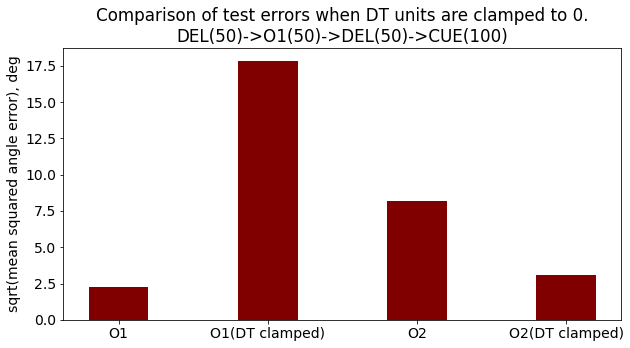

In [95]:
timestep = delay0 + hold_orientation_for*2 + delay1 + delay2//2
timestep = timestep // time_res #res
timestep_desc = "in middle of last delay"

to_pow = 1.0
fig = plt.figure(figsize = (10, 5)) 
# creating the bar plot
plt.bar(["O1", "O1(DT clamped)", "O2", "O2(DT clamped)"], 
        [O1_error_no_clamp, O1_error_DT_clamp, O2_error_no_clamp, O2_error_DT_clamp], 
        color ='maroon',width = 0.4)
#plt.xlabel("Error")
plt.ylabel("sqrt(mean squared angle error), deg")
plt.title("Comparison of test errors when DT units are clamped to 0.\nDEL(50)->O1(50)->DEL(50)->CUE(100)")
plt.show()

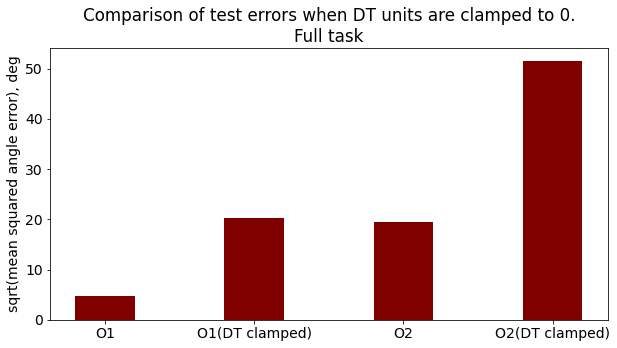

In [97]:
use_delay=True
cue=True
res = 10
restore_model()
with torch.no_grad():
    pass
e_o1_t, e_o2_t = 0, 0
for orientation1 in range(0, 181, res):
    for orientation2 in range(0, 181, res):
        h, ah = init()
        if use_delay: 
            h, ah, _ = hold(h, ah, orientation=None, clamp_dt=True, return_graph=False, t=delay0)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False, t=hold_orientation_for)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False, t=delay1)
        h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False, t=hold_orientation_for)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False, t=delay2)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue, t=hold_cue_for)
        e_o1_t += e_o1
        e_o2_t += e_o2
e_o1_t /= 180 * 180 / res / res
e_o2_t /= 180 * 180 / res / res
O1_error_no_clamp, O2_error_no_clamp = e_o1_t, e_o2_t

restore_model()
with torch.no_grad():
    pass
e_o1_t, e_o2_t = 0, 0
for orientation1 in range(0, 181, res):
    for orientation2 in range(0, 181, res):
        h, ah = init()
        if use_delay: 
            h, ah, _ = hold(h, ah, orientation=None, clamp_dt=True, return_graph=False, t=delay0)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=True, return_graph=False, t=hold_orientation_for)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=True, return_graph=False, t=delay1)
        h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=True, return_graph=False, t=hold_orientation_for)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=True, return_graph=False, t=delay2)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=True, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue, t=hold_cue_for)
        e_o1_t += e_o1
        e_o2_t += e_o2
e_o1_t /= 180 * 180 / res / res
e_o2_t /= 180 * 180 / res / res
O1_error_DT_clamp, O2_error_DT_clamp = e_o1_t, e_o2_t

fig = plt.figure(figsize = (10, 5)) 
# creating the bar plot
plt.bar(["O1", "O1(DT clamped)", "O2", "O2(DT clamped)"], 
        [O1_error_no_clamp, O1_error_DT_clamp, O2_error_no_clamp, O2_error_DT_clamp], 
        color ='maroon',width = 0.4)
#plt.xlabel("Error")
plt.ylabel("sqrt(mean squared angle error), deg")
plt.title("Comparison of test errors when DT units are clamped to 0.\nFull task")
plt.show()

### Exp 1

In [ ]:
restore_model()
with torch.no_grad():
    pass
e_o1_t, e_o2_t = 0, 0
for orientation1 in range(0, 181, res):
    for orientation2 in range(0, 181, res):
        h, ah = init()
        if use_delay: 
            for i in range(50): h, ah = step(h, ah, input_del)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
        e_o1_t += e_o1
        e_o2_t += e_o2
e_o1_t /= 180 * 180 / res / res
e_o2_t /= 180 * 180 / res / res

### Exp

In [124]:
restore_model()
use_delay=True
cue=True
res = 10
DATA_FULL_TASK = {}
print(f"FULL TASK: {'DEL->' if use_delay else ''}O1->DEL->O2->DEL->ASK {'(with cue)' if cue else '(no cue)'}")
print (" --- ")
restore_model()
with torch.no_grad():
    pass
e_o1_t, e_o2_t = 0, 0
for orientation1 in range(0, 181, res):
    for orientation2 in range(0, 181, res):
        h, ah = init()
        if use_delay: 
            for i in range(delay0): h, ah = step(h, ah, input_del)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
        e_o1_t += e_o1
        e_o2_t += e_o2
e_o1_t /= 180 * 180 / res / res
e_o2_t /= 180 * 180 / res / res
DATA_FULL_TASK["baseline"] = e_o1_t, e_o2_t
print(f"baseline: {e_o1_t, e_o2_t}")
print (" --- ")
restore_model()
with torch.no_grad():
    model.fc_h2y.weight[:, DT_i] = 0
    #for i in (DT_indices[-1]):
    #    for j in (u2):
    #        model.fc_h2ah.weight[j, i] = 0
    pass
e_o1_t, e_o2_t = 0, 0
for orientation1 in range(0, 181, res):
    for orientation2 in range(0, 181, res):
        h, ah = init()
        if use_delay: 
            for i in range(50): h, ah = step(h, ah, input_del)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
        e_o1_t += e_o1
        e_o2_t += e_o2
e_o1_t /= 180 * 180 / res / res
e_o2_t /= 180 * 180 / res / res
print("removed DT->OUT:", (e_o1_t, e_o2_t))
print (" --- ")
restore_model()
with torch.no_grad():
    #model.fc_h2y.weight[:, DT_i] = 0
    model.fc_x2ah.weight[R1_indices[-1], :] = 0
    pass
e_o1_t, e_o2_t = 0, 0
for orientation1 in range(0, 181, res):
    for orientation2 in range(0, 181, res):
        h, ah = init()
        if use_delay: 
            for i in range(50): h, ah = step(h, ah, input_del)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
        e_o1_t += e_o1
        e_o2_t += e_o2
e_o1_t /= 180 * 180 / res / res
e_o2_t /= 180 * 180 / res / res
print("removed IN->R1:", (e_o1_t, e_o2_t))
print (" --- ")
restore_model()
with torch.no_grad():
    model.fc_h2y.weight[:, DT_i] = 0
    model.fc_x2ah.weight[R1_indices[-1], :] = 0
    pass
e_o1_t, e_o2_t = 0, 0
for orientation1 in range(0, 181, res):
    for orientation2 in range(0, 181, res):
        h, ah = init()
        if use_delay: 
            for i in range(50): h, ah = step(h, ah, input_del)
        h, ah, _ = hold(h, ah, orientation=orientation1, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=orientation2, clamp_dt=False, return_graph=False)
        h, ah, _ = hold(h, ah, orientation=None, clamp_dt=False, return_graph=False)
        h, ah, e_o1, e_o2, _ = hold_measure_error(h, ah, orientation=None, clamp_dt=False, o1_target=orientation1, o2_target=orientation2, return_graph=False, cue=cue)
        e_o1_t += e_o1
        e_o2_t += e_o2
e_o1_t /= 180 * 180 / res / res
e_o2_t /= 180 * 180 / res / res
print("removed IN->R1 and DT->OUT:", (e_o1_t, e_o2_t))
print (" --- ")

FULL TASK: DEL->O1->DEL->O2->DEL->ASK (with cue)
 --- 
baseline: (4.8851066165095265, 3.122145348107869)
 --- 


KeyboardInterrupt: 

## Merge PDF

In [24]:
files = [f for f in os.listdir(make_saving_path("")) if f.endswith('.pdf')]
files.sort(key=lambda x: os.path.getmtime(make_saving_path(x)))
files

['pca_R2_49to249_explainedvariance.pdf',
 'pca_R2_49to249_plots.pdf',
 'pca_R1,R2,DT_249to250_explainedvariance.pdf',
 'pca_R1,R2,DT_249to250_plots.pdf',
 'pca_R1,R2,DT_149to150_explainedvariance.pdf',
 'pca_R1,R2,DT_149to150_plots.pdf',
 'pca_R1,R2,DT_199to200_explainedvariance.pdf',
 'pca_R1,R2,DT_199to200_plots.pdf',
 'pca_R1,R2,DT_174to175_explainedvariance.pdf',
 'pca_R1,R2,DT_174to175_plots.pdf',
 'pca_R1,R2,DT_49to249_explainedvariance.pdf',
 'pca_R1,R2,DT_49to249_plots.pdf',
 'tunings.pdf',
 'ring_output_connectivity.pdf',
 'clustering.pdf',
 'clustering_abs.pdf',
 'clustering_opentsne.pdf',
 'clustering_opentsne_abs.pdf',
 'ring_connectivity.pdf',
 'r1_r2_connectivity.pdf',
 'ring_input_connectivity_1.pdf',
 'ring_input_connectivity_2.pdf',
 'ring_input_connectivity_3.pdf',
 'R1_similarity.pdf',
 'pca_R1_49to249_explainedvariance.pdf',
 'pca_R1_49to249_plots.pdf',
 'testing.pdf']

In [25]:
from PyPDF2 import PdfMerger

files = [f for f in os.listdir(make_saving_path("")) if f.endswith('.pdf')]
files.sort(key=lambda x: os.path.getmtime(make_saving_path(x)))
pdfs = [make_saving_path(i) for i in files]

merger = PdfMerger()

for pdf in pdfs:
    merger.append(pdf)

merger.write(make_saving_path("RESULT.pdf"))
merger.close()

## Clamp R2

In [302]:
res = 1
t_from = t1
t_to = t5
units_i=torch.cat((R2_i,))

reset_to=torch.mean(megabatch_output[1][:, :, :], dim=0)

batch = megabatch_input, megabatch_target, megabatch_mask
sbatch = batch
soutput = megabatch_output[0][::res], megabatch_output[1][::res]
sbatch = batch[0][::res], batch[1][::res], batch[2][::res]
reset_mean = torch.zeros(total_time, dim_recurrent, dtype=int)
reset_mean[t_from:t_to, units_i] = 1
#soutput_reset = model._forward(sbatch[0], bhneverlearn=torch.zeros(model.get_noise_shape(sbatch[0])), reset_units=reset_mean, reset_to=reset_to)
soutput_reset = model._forward(sbatch[0], bhneverlearn=noise_amplitude*torch.randn(model.get_noise_shape(sbatch[0])), reset_units=reset_mean, reset_to=reset_to)
error = torch.sum((soutput_reset[0][sbatch[2] == 1] - sbatch[1][sbatch[2] == 1]) ** 2, dim=0) / torch.sum(
        sbatch[2] == 1)
#print(error.shape)
error_o1_reset = (error[0]+error[1]).item()
error_o2_reset = (error[2]+error[3]).item()

data_all_reset = torch.zeros((total_time, dim_recurrent, ORI_SET_SIZE, ORI_SET_SIZE))
for orientation1 in range(ORI_SET_SIZE):
    for orientation2 in range(ORI_SET_SIZE):
        o = soutput_reset[1][orientation1 * ORI_SET_SIZE + orientation2]
        data_all_reset[:, :, orientation1, orientation2] = o

print(f"MSE: {error_o1_reset}, {error_o2_reset}")
trig = soutput_reset[0][:, t5+1:t6+1, :]
o1 = torch.atan2((trig[:, :, 0]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5), (trig[:, :, 1]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5)) / 2 * 180 / math.pi
o2 = torch.atan2((trig[:, :, 2]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5), (trig[:, :, 3]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5)) / 2 * 180 / math.pi
trig = sbatch[1][:, t5+1:t6+1, :]
o1_t = torch.atan2((trig[:, :, 0]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5), (trig[:, :, 1]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5)) / 2 * 180 / math.pi
o2_t = torch.atan2((trig[:, :, 2]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5), (trig[:, :, 3]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5)) / 2 * 180 / math.pi
error_o1 = torch.minimum(torch.minimum((o1-o1_t)**2, (o1-o1_t+180)**2), (o1-o1_t-180)**2)
error_o1 = torch.mean(error_o1).item()**0.5
error_o2 = torch.minimum(torch.minimum((o2-o2_t)**2, (o2-o2_t+180)**2), (o2-o2_t-180)**2)
error_o2 = torch.mean(error_o2).item()**0.5
print(f"MSA: {error_o1}, {error_o2}")

MSE: 2.055091619491577, 0.9671870470046997
MSA: 50.95409766014285, 39.95724338374865


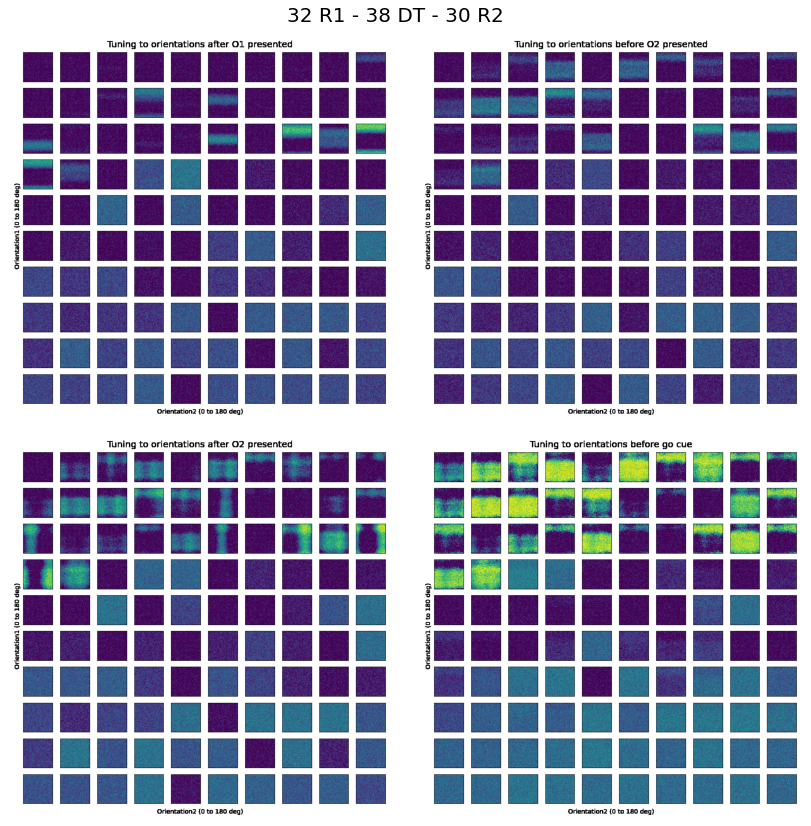

In [300]:
t=t6
images_side_by_side((
    plt_to_image(get_tuning_heatmaps(t2, t2d, sor_i=megabatch_tuningindices[t], data_all=data_all_reset)),
    plt_to_image(get_tuning_heatmaps(t3, t3d, sor_i=megabatch_tuningindices[t], data_all=data_all_reset)),
    plt_to_image(get_tuning_heatmaps(t4, t4d, sor_i=megabatch_tuningindices[t], data_all=data_all_reset)),
    plt_to_image(get_tuning_heatmaps(t5, t5d, sor_i=megabatch_tuningindices[t], data_all=data_all_reset)),
), save_to=make_saving_path("tunings.pdf"), title=f"{R1_num} R1 - {DT_num} DT - {R2_num} R2")

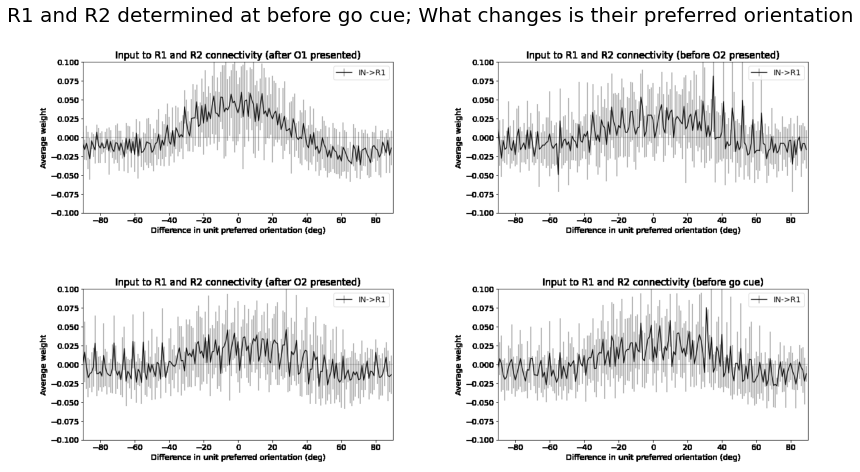

In [23]:
R1_i = megabatch_tuningindices[t5][:R1_ends_at_i]
R2_i = megabatch_tuningindices[t5][R2_starts_from_i:]
imagess = []
for i, x in enumerate([(t2, t2d), (t3, t3d), (t4, t4d), (t5, t5d)]):
    timestep, timestep_desc = x
    R1_pref = calc_pref(R1_i, timestep, to=1, data_all=data_all_reset)
    R2_pref = calc_pref(R2_i, timestep, to=2)
    R2_O1_pref = calc_pref(R2_i, timestep, to=1)

    sm=0
    o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph(R1_i, R1_pref, timestep, sm=sm)
    o2_distances, o2_weights, o2_weights_std = get_connplot_iu_graph(R2_i, R2_pref, timestep, sm=sm)
    fig = plt.figure(figsize=(10, 5))
    markers, caps, bars = plt.errorbar(o1_distances, o1_weights, o1_weights_std, color='k', markersize=10, label="IN->R1", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    if False:
        if timestep >= t4:
            markers, caps, bars = plt.errorbar(o2_distances, o2_weights, o2_weights_std, color='r', markersize=10, label="IN->R2", capsize=0)
            [bar.set_alpha(0.4) for bar in bars]
            [cap.set_alpha(0.4) for cap in caps]
        else:
            o2_distances, o2_weights, o2_weights_std = get_connplot_iu_graph(R2_i, R2_O1_pref, timestep, sm=sm)
            markers, caps, bars = plt.errorbar(o2_distances, o2_weights, o2_weights_std, color='r', markersize=10, label="IN->R2(O1)", capsize=0)
            [bar.set_alpha(0.4) for bar in bars]
            [cap.set_alpha(0.4) for cap in caps]
    plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
    plt.xlabel('Difference in unit preferred orientation (deg)')
    plt.ylabel('Average weight')
    plt.title(f'Input to R1 and R2 connectivity ({timestep_desc})')
    plt.legend()
    plt.xlim(-90, 90)
    plt.ylim(-0.1, 0.1)
    imagess.append(plt_to_image(fig))
images_side_by_side(imagess, 
                    save_to=make_saving_path("ring_input_connectivity_1.pdf"), 
                    title="R1 and R2 determined at before go cue; What changes is their preferred orientation",
                    figsize=(12, 7))

In [85]:
def get_connplot_iu_graph_new(units_id, unit_pref, timestep, sm=0):
    distances_weights = {}
    distances = []
    weights = []
    for i in range(len(units_id)):
        for j in range(orientation_neurons):
            for k in range(-sm//2, sm//2+1):
                if j == i: continue
                diff = (unit_pref[i]-round(180*j/orientation_neurons)).item()
                if diff > 90: diff -= 180
                if diff < -90: diff += 180
                diff += k
                #print(diff, end=" ")
                #diff = (diff + 180 + 90) % 180 - 90
                w_ij = model.fc_x2ah.weight[units_id[i], j] # weight from i to j 
                distances.append(diff)
                weights.append(w_ij.item())
                if diff not in distances_weights: distances_weights[diff] = []
                distances_weights[diff].append(w_ij.item())
    
    #print(distances_weights)
    o1_distances = np.array(sorted(distances_weights.keys()))
    o1_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in o1_distances]
    o1_weights_std = [np.std(distances_weights[diff]) for diff in o1_distances]
    return distances, weights, o1_distances, o1_weights, o1_weights_std

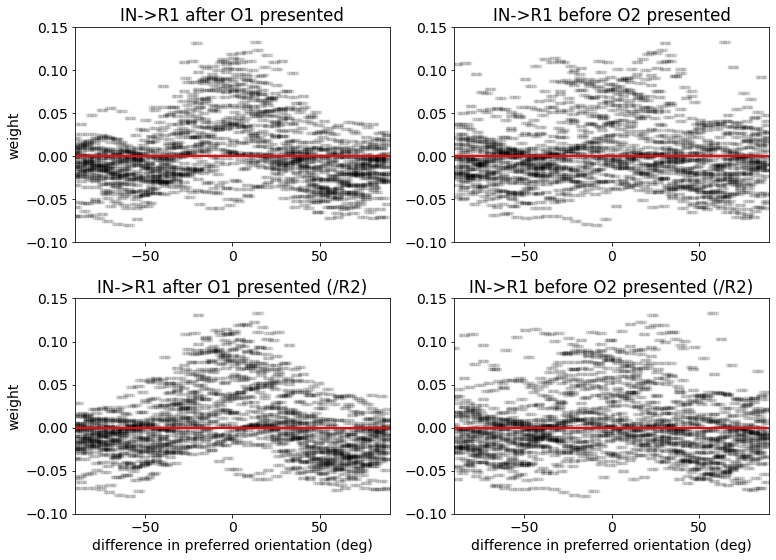

In [95]:
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(2, 2, 1)
t, t_d = t2, t2d
R1_pref = calc_pref(R1_i, t, to=1)
distances, weights, _, _, _ = get_connplot_iu_graph_new(R1_i, R1_pref, t, sm=5)
ax.scatter(distances, weights, 10, alpha=0.1, color="k")
ax.axhline(y=0.0, color='r', linestyle='-', linewidth=2)
ax.set_ylim(-0.1, 0.15)
ax.set_xlim(-90, 90)
ax.set_title(f"IN->R1 {t_d}")
#ax.set_xlabel("difference in preferred orientation (deg)")
ax.set_ylabel("weight")

ax = fig.add_subplot(2, 2, 2)
t, t_d = t3, t3d
R1_pref = calc_pref(R1_i, t, to=1)
distances, weights, _, _, _ = get_connplot_iu_graph_new(R1_i, R1_pref, t, sm=5)
ax.scatter(distances, weights, 10, alpha=0.1, color="k")
ax.axhline(y=0.0, color='r', linestyle='-', linewidth=2)
ax.set_ylim(-0.1, 0.15)
ax.set_xlim(-90, 90)
ax.set_title(f"IN->R1 {t_d}")
#ax.set_xlabel("difference in preferred orientation (deg)")
#ax.set_ylabel("weight")
plt.tight_layout()

ax = fig.add_subplot(2, 2, 3)
t, t_d = t2, t2d
R1_pref = calc_pref(R1_i, t, to=1, data_all=data_all_reset)
distances, weights, _, _, _ = get_connplot_iu_graph_new(R1_i, R1_pref, t, sm=5)
ax.scatter(distances, weights, 10, alpha=0.1, color="k")
ax.axhline(y=0.0, color='r', linestyle='-', linewidth=2)
ax.set_ylim(-0.1, 0.15)
ax.set_xlim(-90, 90)
ax.set_title(f"IN->R1 {t_d} (/R2)")
ax.set_xlabel("difference in preferred orientation (deg)")
ax.set_ylabel("weight")

ax = fig.add_subplot(2, 2, 4)
t, t_d = t3, t3d
R1_pref = calc_pref(R1_i, t, to=1, data_all=data_all_reset)
distances, weights, _, _, _ = get_connplot_iu_graph_new(R1_i, R1_pref, t, sm=5)
ax.scatter(distances, weights, 10, alpha=0.1, color="k")
ax.axhline(y=0.0, color='r', linestyle='-', linewidth=2)
ax.set_ylim(-0.1, 0.15)
ax.set_xlim(-90, 90)
ax.set_title(f"IN->R1 {t_d} (/R2)")
ax.set_xlabel("difference in preferred orientation (deg)")
#ax.set_ylabel("weight")
plt.tight_layout()
plt.show()

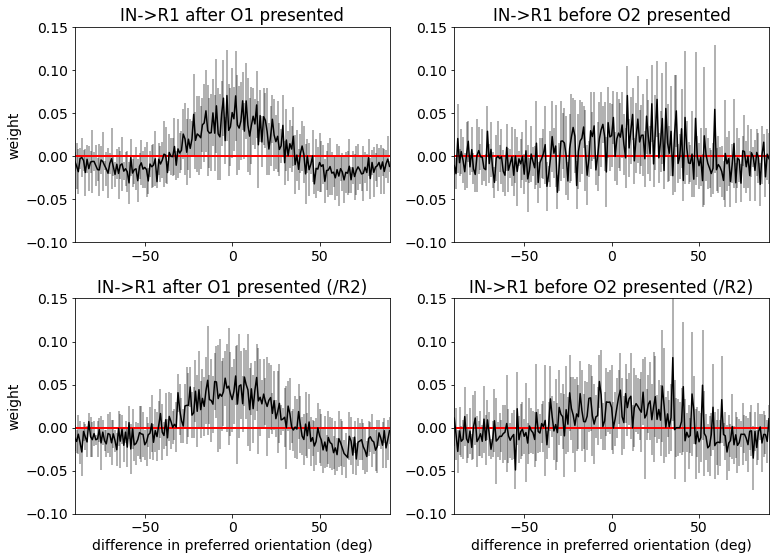

In [87]:
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(2, 2, 1)
t, t_d = t2, t2d
R1_pref = calc_pref(R1_i, t, to=1)
distances, weights, o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph_new(R1_i, R1_pref, t, sm=0)
markers, caps, bars = ax.errorbar(o1_distances, o1_weights, o1_weights_std, color='k', markersize=10, label="IN->R1", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
ax.axhline(y=0.0, color='r', linestyle='-', linewidth=2)
ax.set_ylim(-0.1, 0.15)
ax.set_xlim(-90, 90)
ax.set_title(f"IN->R1 {t_d}")
#ax.set_xlabel("difference in preferred orientation (deg)")
ax.set_ylabel("weight")

ax = fig.add_subplot(2, 2, 2)
t, t_d = t3, t3d
R1_pref = calc_pref(R1_i, t, to=1)
distances, weights, o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph_new(R1_i, R1_pref, t, sm=0)
markers, caps, bars = ax.errorbar(o1_distances, o1_weights, o1_weights_std, color='k', markersize=10, label="IN->R1", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
ax.axhline(y=0.0, color='r', linestyle='-', linewidth=2)
ax.set_ylim(-0.1, 0.15)
ax.set_xlim(-90, 90)
ax.set_title(f"IN->R1 {t_d}")
#ax.set_xlabel("difference in preferred orientation (deg)")
#ax.set_ylabel("weight")
plt.tight_layout()

ax = fig.add_subplot(2, 2, 3)
t, t_d = t2, t2d
R1_pref = calc_pref(R1_i, t, to=1, data_all=data_all_reset)
distances, weights, o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph_new(R1_i, R1_pref, t, sm=0)
markers, caps, bars = ax.errorbar(o1_distances, o1_weights, o1_weights_std, color='k', markersize=10, label="IN->R1", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
ax.axhline(y=0.0, color='r', linestyle='-', linewidth=2)
ax.set_ylim(-0.1, 0.15)
ax.set_xlim(-90, 90)
ax.set_title(f"IN->R1 {t_d} (/R2)")
ax.set_xlabel("difference in preferred orientation (deg)")
ax.set_ylabel("weight")

ax = fig.add_subplot(2, 2, 4)
t, t_d = t3, t3d
R1_pref = calc_pref(R1_i, t, to=1, data_all=data_all_reset)
distances, weights, o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph_new(R1_i, R1_pref, t, sm=0)
markers, caps, bars = ax.errorbar(o1_distances, o1_weights, o1_weights_std, color='k', markersize=10, label="IN->R1", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
ax.axhline(y=0.0, color='r', linestyle='-', linewidth=2)
ax.set_ylim(-0.1, 0.15)
ax.set_xlim(-90, 90)
ax.set_title(f"IN->R1 {t_d} (/R2)")
ax.set_xlabel("difference in preferred orientation (deg)")
#ax.set_ylabel("weight")
plt.tight_layout()
plt.show()

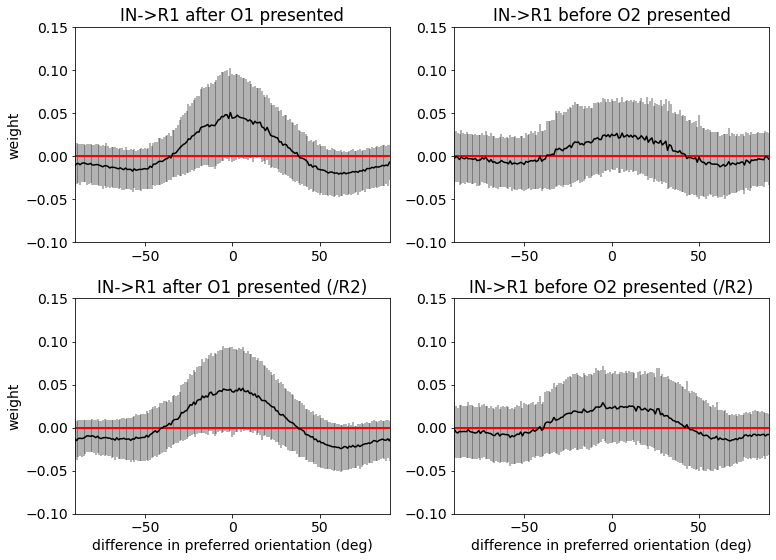

In [90]:
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(2, 2, 1)
t, t_d = t2, t2d
R1_pref = calc_pref(R1_i, t, to=1)
distances, weights, o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph_new(R1_i, R1_pref, t, sm=5)
markers, caps, bars = ax.errorbar(o1_distances, o1_weights, o1_weights_std, color='k', markersize=10, label="IN->R1", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
ax.axhline(y=0.0, color='r', linestyle='-', linewidth=2)
ax.set_ylim(-0.1, 0.15)
ax.set_xlim(-90, 90)
ax.set_title(f"IN->R1 {t_d}")
#ax.set_xlabel("difference in preferred orientation (deg)")
ax.set_ylabel("weight")

ax = fig.add_subplot(2, 2, 2)
t, t_d = t3, t3d
R1_pref = calc_pref(R1_i, t, to=1)
distances, weights, o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph_new(R1_i, R1_pref, t, sm=5)
markers, caps, bars = ax.errorbar(o1_distances, o1_weights, o1_weights_std, color='k', markersize=10, label="IN->R1", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
ax.axhline(y=0.0, color='r', linestyle='-', linewidth=2)
ax.set_ylim(-0.1, 0.15)
ax.set_xlim(-90, 90)
ax.set_title(f"IN->R1 {t_d}")
#ax.set_xlabel("difference in preferred orientation (deg)")
#ax.set_ylabel("weight")
plt.tight_layout()

ax = fig.add_subplot(2, 2, 3)
t, t_d = t2, t2d
R1_pref = calc_pref(R1_i, t, to=1, data_all=data_all_reset)
distances, weights, o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph_new(R1_i, R1_pref, t, sm=5)
markers, caps, bars = ax.errorbar(o1_distances, o1_weights, o1_weights_std, color='k', markersize=10, label="IN->R1", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
ax.axhline(y=0.0, color='r', linestyle='-', linewidth=2)
ax.set_ylim(-0.1, 0.15)
ax.set_xlim(-90, 90)
ax.set_title(f"IN->R1 {t_d} (/R2)")
ax.set_xlabel("difference in preferred orientation (deg)")
ax.set_ylabel("weight")

ax = fig.add_subplot(2, 2, 4)
t, t_d = t3, t3d
R1_pref = calc_pref(R1_i, t, to=1, data_all=data_all_reset)
distances, weights, o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph_new(R1_i, R1_pref, t, sm=5)
markers, caps, bars = ax.errorbar(o1_distances, o1_weights, o1_weights_std, color='k', markersize=10, label="IN->R1", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
ax.axhline(y=0.0, color='r', linestyle='-', linewidth=2)
ax.set_ylim(-0.1, 0.15)
ax.set_xlim(-90, 90)
ax.set_title(f"IN->R1 {t_d} (/R2)")
ax.set_xlabel("difference in preferred orientation (deg)")
#ax.set_ylabel("weight")
plt.tight_layout()
plt.show()

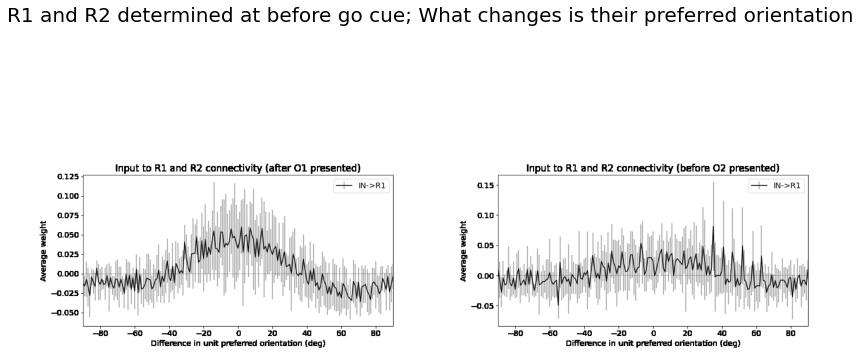

In [51]:
R1_i = megabatch_tuningindices[t5][:R1_ends_at_i]
R2_i = megabatch_tuningindices[t5][R2_starts_from_i:]
imagess = []
for i, x in enumerate([(t2, t2d), (t3, t3d)]):
    timestep, timestep_desc = x
    R1_pref = calc_pref(R1_i, timestep, to=1, data_all=data_all_reset)
    R2_pref = calc_pref(R2_i, timestep, to=2)
    R2_O1_pref = calc_pref(R2_i, timestep, to=1)

    sm=0
    _, _, o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph_new(R1_i, R1_pref, timestep, sm=sm)
    _, _, o2_distances, o2_weights, o2_weights_std = get_connplot_iu_graph_new(R2_i, R2_pref, timestep, sm=sm)
    fig = plt.figure(figsize=(10, 5))
    markers, caps, bars = plt.errorbar(o1_distances, o1_weights, o1_weights_std, color='k', markersize=10, label="IN->R1", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    if False:
        if timestep >= t4:
            markers, caps, bars = plt.errorbar(o2_distances, o2_weights, o2_weights_std, color='r', markersize=10, label="IN->R2", capsize=0)
            [bar.set_alpha(0.4) for bar in bars]
            [cap.set_alpha(0.4) for cap in caps]
        else:
            o2_distances, o2_weights, o2_weights_std = get_connplot_iu_graph(R2_i, R2_O1_pref, timestep, sm=sm)
            markers, caps, bars = plt.errorbar(o2_distances, o2_weights, o2_weights_std, color='r', markersize=10, label="IN->R2(O1)", capsize=0)
            [bar.set_alpha(0.4) for bar in bars]
            [cap.set_alpha(0.4) for cap in caps]
    plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
    plt.xlabel('Difference in unit preferred orientation (deg)')
    plt.ylabel('Average weight')
    plt.title(f'Input to R1 and R2 connectivity ({timestep_desc})')
    plt.legend()
    plt.xlim(-90, 90)
    #plt.ylim(-0.1, 0.1)
    imagess.append(plt_to_image(fig))
images_side_by_side(imagess, 
                    save_to=make_saving_path("ring_input_connectivity_1.pdf"), 
                    title="R1 and R2 determined at before go cue; What changes is their preferred orientation",
                    figsize=(12, 7))

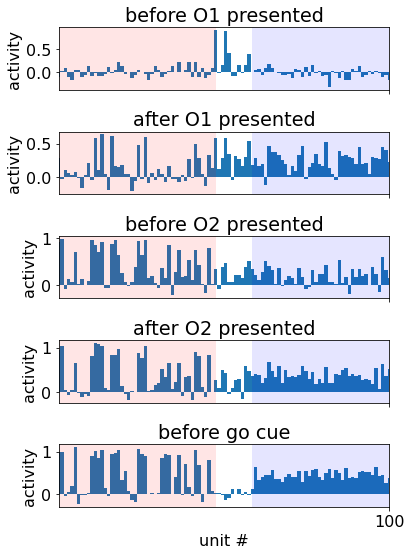

In [42]:
timesteps = {t1-1:t1d, t2:t2d, t3:t3d, t4:t4d, t5:t5d}
indices = torch.cat((R1_i, DT_i, R2_i))
o1, o2 = 90, 90
o1, o2 = o1//ORI_RES, o2//ORI_RES
out = soutput_reset[1].reshape(180//ORI_RES, 180//ORI_RES, total_time, dim_recurrent)[:, :, :, indices]
fig = plt.figure(figsize=(6, 8))
N = len(timesteps.items())
for i in range(N):
    t, t_d = list(timesteps.items())[i]
    ax = fig.add_subplot(N, 1, i+1)
    ax.bar(range(1, len(indices)+1), out[o1, o2, t, :].detach().numpy(), 1)
    ax.set_xlabel("unit #")
    ax.set_ylabel(f"activity")
    ax.set_xticks([0, R1_ends_at_i, R2_starts_from_i, 100])
    ax.set_xticks([0, 100])
    ax.set_title(f"{t_d}")
    ax.axvspan(0, R1_ends_at_i+1, facecolor="r", alpha=0.1)
    ax.axvspan(R2_starts_from_i, 100, facecolor="b", alpha=0.1)
    ax.set_xlim(1, 100)
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in fig.axes:
    ax.label_outer()
plt.tight_layout()
plt.show()

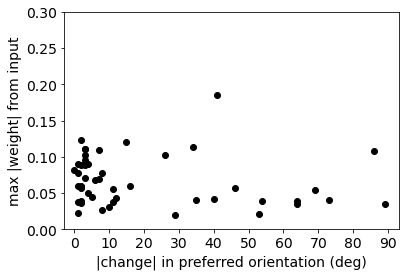

In [188]:
units_i = torch.cat((R1_i, ))
da = megabatch_tuningdata
da = data_all_reset
prefc = calc_pref(units_i, t2+5, to=1, data_all=da)-calc_pref(units_i, t3-1, to=1, data_all=da)
prefc[prefc<-90] = prefc[prefc<-90]+180
prefc[prefc>90] = prefc[prefc>90]-180
prefc = torch.abs(prefc)

strengthin = torch.max(torch.abs(model.fc_x2ah.weight[units_i, :-1]), dim=1).values

plt.scatter(prefc.detach().numpy(), strengthin.detach().numpy(), color="k", alpha=1.0)
plt.xlim(-3, 93)
plt.ylim(0, 0.3)#torch.max(strengthin).item()*1.1)
plt.xlabel("|change| in preferred orientation (deg)")
plt.ylabel("max |weight| from input")
plt.xticks(range(0, 100, 10))
plt.show()

## P results

In [208]:
a, b = 50, 53
def generate_5053batch(N=100, task=task, delay0=delay0, delay1=delay1, delay2=delay2):
    batch = []
    batch_labels = []
    output_masks = []

    for i in range(N):
        to_batch, to_batch_labels, to_mask = task._make_trial(a, b, delay0, delay1, delay2)
        batch.append(to_batch.unsqueeze(0))
        batch_labels.append(to_batch_labels.unsqueeze(0))
        output_masks.append(to_mask.unsqueeze(0))
        to_batch, to_batch_labels, to_mask = task._make_trial(b, a, delay0, delay1, delay2)
        batch.append(to_batch.unsqueeze(0))
        batch_labels.append(to_batch_labels.unsqueeze(0))
        output_masks.append(to_mask.unsqueeze(0))

    return torch.cat(batch).to(config.device), torch.cat(batch_labels).to(config.device), torch.cat(
        output_masks).to(config.device)

In [209]:
sbatch = generate_5053batch(N=100)

t_bhneverlearn = 0.1 * torch.randn(model.get_noise_shape(sbatch[0]))
bhneverlearn = torch.zeros(t_bhneverlearn.shape)
bhneverlearn[:, t4:t5, :] = t_bhneverlearn[:, t4:t5, :]

soutput_reset = model._forward(sbatch[0], bhneverlearn=bhneverlearn)
error = torch.sum((soutput_reset[0][sbatch[2] == 1] - sbatch[1][sbatch[2] == 1]) ** 2, dim=0) / torch.sum(
        sbatch[2] == 1)
#print(error.shape)
error_o1_reset = (error[0]+error[1]).item()
error_o2_reset = (error[2]+error[3]).item()

print(f"MSE: {error_o1_reset}, {error_o2_reset}")
trig = soutput_reset[0][:, t5+1:t6+1, :]
o1 = torch.atan2((trig[:, :, 0]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5), (trig[:, :, 1]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5)) / 2 * 180 / math.pi
o2 = torch.atan2((trig[:, :, 2]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5), (trig[:, :, 3]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5)) / 2 * 180 / math.pi
od = trig[:, :, 4]
trig = sbatch[1][:, t5+1:t6+1, :]
o1_t = torch.atan2((trig[:, :, 0]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5), (trig[:, :, 1]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5)) / 2 * 180 / math.pi
o2_t = torch.atan2((trig[:, :, 2]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5), (trig[:, :, 3]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5)) / 2 * 180 / math.pi
od_t = trig[:, :, 4]
error_o1 = torch.minimum(torch.minimum((o1-o1_t)**2, (o1-o1_t+180)**2), (o1-o1_t-180)**2)
error_o1 = torch.mean(error_o1).item()**0.5
error_o2 = torch.minimum(torch.minimum((o2-o2_t)**2, (o2-o2_t+180)**2), (o2-o2_t-180)**2)
error_o2 = torch.mean(error_o2).item()**0.5
print(f"MSA: {error_o1}, {error_o2}")

MSE: 0.00714250560849905, 0.01528052520006895
MSA: 2.2620775534424293, 3.4395253543753843


In [210]:
o1_output50_wheno2_53 = o1[::2]
o2_output53_wheno1_50 = o2[::2]
o1_output53_wheno2_50 = o1[1::2]
o2_output50_wheno1_53 = o2[1::2]
od_5053 = od[::2]
od_5350 = od[1::2]
torch.mean(od_5053).item(), torch.mean(od_5350).item()

(0.07934843748807907, 1.0021419525146484)

Text(0, 0.5, 'reported O2 for 53 when O1 is 50')

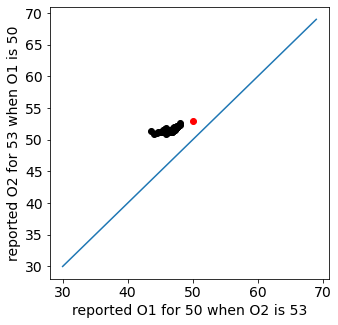

In [211]:
plt.figure(figsize=(5, 5))
im = plt.scatter(o1_output50_wheno2_53[:, -1].detach().numpy(), o2_output53_wheno1_50[:, -1].detach().numpy(), color="k", alpha=1)
plt.scatter([a], [b], color="r", alpha=1)
plt.plot(range(30, 70, 1), range(30, 70, 1))
#plt.ylim(30, 70)
#plt.xlim(30, 70)
plt.xlabel("reported O1 for 50 when O2 is 53")
plt.ylabel("reported O2 for 53 when O1 is 50")

Text(0, 0.5, 'reported O2 for 50 when O1 is 53')

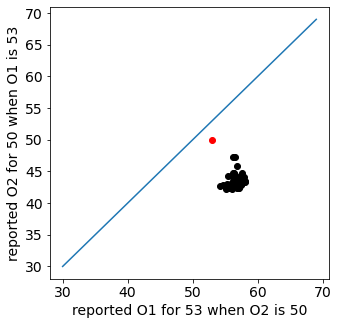

In [212]:
plt.figure(figsize=(5, 5))
im = plt.scatter(o1_output53_wheno2_50[:, -1].detach().numpy(), o2_output50_wheno1_53[:, -1].detach().numpy(), color="k", alpha=1)
plt.scatter([b], [a], color="r", alpha=1)
plt.plot(range(30, 70, 1), range(30, 70, 1))
#plt.ylim(30, 70)
#plt.xlim(30, 70)
plt.xlabel("reported O1 for 53 when O2 is 50")
plt.ylabel("reported O2 for 50 when O1 is 53")

Text(0, 0.5, 'reported O2 for 53 when O1 is 50')

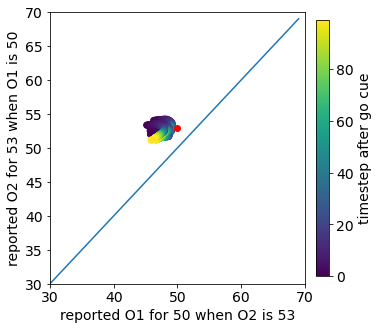

In [190]:
plt.figure(figsize=(5, 5))
for i in range(10):
    im = plt.scatter(o1_output50_wheno2_53[i].detach().numpy(), o2_output53_wheno1_50[i].detach().numpy(), c=range(len(o1_output53_wheno2_50[0])), alpha=1)
plt.colorbar(im, orientation="vertical",fraction=0.046, pad=0.04, label="timestep after go cue")
plt.scatter([a], [b], color="r", alpha=1)
plt.plot(range(30, 70, 1), range(30, 70, 1))
plt.ylim(30, 70)
plt.xlim(30, 70)
plt.xlabel("reported O1 for 50 when O2 is 53")
plt.ylabel("reported O2 for 53 when O1 is 50")

Text(0, 0.5, 'reported O2 for 50 when O1 is 53')

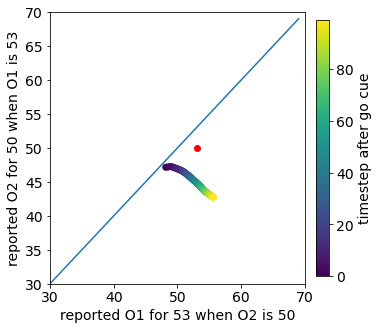

In [137]:
plt.figure(figsize=(5, 5))
im = plt.scatter(o1_output53_wheno2_50[0].detach().numpy(), o2_output50_wheno1_53[0].detach().numpy(), c=range(len(o1_output53_wheno2_50[0])), alpha=1)
plt.colorbar(im, orientation="vertical",fraction=0.046, pad=0.04, label="timestep after go cue")
plt.scatter([b], [a], color="r", alpha=1)
plt.plot(range(30, 70, 1), range(30, 70, 1))
plt.ylim(30, 70)
plt.xlim(30, 70)
plt.xlabel("reported O1 for 53 when O2 is 50")
plt.ylabel("reported O2 for 50 when O1 is 53")

Text(0, 0.5, 'reported O2 for 53 when O1 is 50')

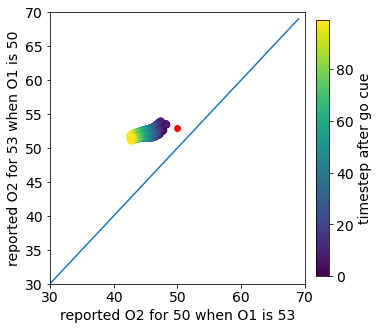

In [138]:
plt.figure(figsize=(5, 5))
for i in range(10):
    im = plt.scatter(o2_output50_wheno1_53[i].detach().numpy(), o2_output53_wheno1_50[i].detach().numpy(), c=range(len(o1_output53_wheno2_50[0])), alpha=1)
plt.colorbar(im, orientation="vertical",fraction=0.046, pad=0.04, label="timestep after go cue")
plt.scatter([a], [b], color="r", alpha=1)
plt.plot(range(30, 70, 1), range(30, 70, 1))
plt.ylim(30, 70)
plt.xlim(30, 70)
plt.xlabel("reported O2 for 50 when O1 is 53")
plt.ylabel("reported O2 for 53 when O1 is 50")

In [67]:
reported_for_50.shape

NameError: name 'reported_for_50' is not defined

(30.0, 70.0)

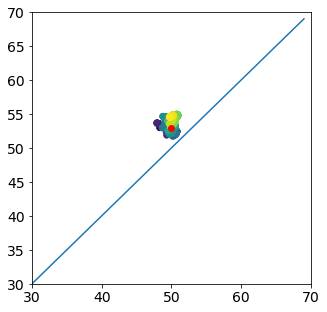

In [68]:
plt.figure(figsize=(5, 5))
reported_for_50 = o2[o2_t==50]
reported_for_53 = o2[o2_t==53]
#plt.scatter(o1_t[:, -1].detach().numpy(), o1[:, -1].detach().numpy(), color="k", alpha=0.3)
plt.scatter(reported_for_50.detach().numpy(), reported_for_53.detach().numpy(), c=range(len(reported_for_50)), alpha=1)
plt.scatter([50], [53], color="r", alpha=1)
plt.plot(range(30, 70, 1), range(30, 70, 1))
plt.ylim(30, 70)
plt.xlim(30, 70)

## o_spikes

In [409]:
def o_spikes(pref, stim, exponent, maxSpike, k):
    # o_spikes: spike numbers per trial for orientation tuning cells
    # r = o_spikes(pref, stim, exponent, k) 
    # pref: row vec for cells' preferred orientations
    # stim: column vec for stimulus orientations
    # exponent: scalar determining the widths of tuning. larger value for sharper tuning
    # maxSpike: scalar for mean max spike number when pref = stim
    # k: scalar for determining variance = k * mean
    # spikes: different columuns for cells with different pref orintations
    #         different rows for different stim orientations
    np_ = pref.shape[0]# number of elements in pref
    ns = stim.shape[0]# number of elements in stim
    
    prefs = np.ones((ns,1)) @ pref[None,:]# ns x np array, (ns x 1) @ (1 x np) 
    stims = stim[:,None] @ np.ones((1,np_))# ns x np array, (ns x 1) @ (1 x np) 
    
    # mean spike numbers
    meanSpike = maxSpike * (0.5*(np.cos(2*(prefs-stims)) + 1)) ** exponent# ns x np array
    
    # sigma for noise
    sigmaSpike = np.sqrt(k * meanSpike)
    
    #spikes = normrnd(meanSpike, sigmaSpike)# ns x np array, matlab
    spikes = np.random.normal(meanSpike, sigmaSpike)# ns x np array, python
    
    # no negative spike numbers
    spikes[spikes < 0] = 0# ns x np array
    return spikes

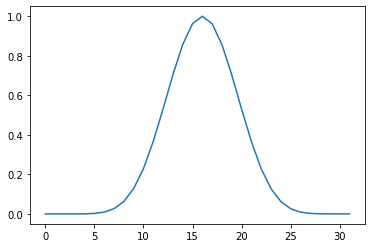

In [420]:
pref = np.pi * np.arange(orientation_neurons) / orientation_neurons
stim = np.array([90 / 180 * 3.14])
exponent = 4
maxSpike = 1
k = 0
plt.plot(range(32), o_spikes(pref, stim, exponent, maxSpike, k)[0])